# Fault Classification (Extracted)
This notebook is extracted from the original `Main.ipynb` and includes all required setup so the Fault Classification section runs standalone.

## Table of Contents
1. [Setup](#setup)
   - [Dependencies](#dependencies)
   - [Data Loading](#data-loading)
   - [Configuration](#configuration)
   - [Helper Functions](#helper-functions)
2. [Data Preparation](#data-preparation)
   - [Data Filtering](#data-filtering)
   - [Feature Engineering](#feature-engineering)
3. [Model Training](#model-training)
   - [XGBoost](#xgboost)
   - [Random Forest](#random-forest)
   - [Neural Network](#neural-network)
4. [Model Evaluation](#model-evaluation)
   - [Performance Metrics](#performance-metrics)
   - [Confusion Matrices](#confusion-matrices)
5. [Results Visualization](#results-visualization)
6. [Conclusion](#conclusion)

In [1]:
# Core Python libraries
import os
import sys
from datetime import datetime
from typing import Union, List, Dict

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Data loading
import pyreadr  # For reading R data files

# Machine learning libraries
## Preprocessing and metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)

## Models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Deep learning
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

## Setup <a id="setup"></a>

This section contains all the necessary setup for the notebook, including importing required libraries, loading data, and defining configuration parameters.

### Dependencies <a id="dependencies"></a>

The following cell imports all required libraries for this analysis.

In [2]:
# Load data (.RData) -> DataFrames
fault_free_training_dict = pyreadr.read_r("data/TEP_FaultFree_Training.RData")
fault_free_testing_dict  = pyreadr.read_r("data/TEP_FaultFree_Testing.RData")
faulty_training_dict     = pyreadr.read_r("data/TEP_Faulty_Training.RData")
faulty_testing_dict      = pyreadr.read_r("data/TEP_Faulty_Testing.RData")

DF_FF_TRAINING_RAW = fault_free_training_dict["fault_free_training"]
DF_FF_TEST_RAW     = fault_free_testing_dict["fault_free_testing"]
DF_F_TRAINING_RAW  = faulty_training_dict["faulty_training"]
DF_F_TEST_RAW      = faulty_testing_dict["faulty_testing"]

### Data Loading <a id="data-loading"></a>

The following cell loads the Tennessee Eastman Process (TEP) dataset from R data files. The dataset includes:
- Fault-free training data
- Fault-free testing data
- Faulty training data
- Faulty testing data

In [3]:
# Global configuration
VERSION = "1.00"
OUTPUT_PATH = "output/fault_classification"

# Model names
XGBOOST = "XGBoost"
RANDOM_FOREST = "Random Forest"
NEURAL_NET = "Neural Net"

# Data column names and options
TARGET_VARIABLE_COLUMN_NAME = "faultNumber"
SIMULATION_RUN_COLUMN_NAME = "simulationRun"
COLUMNS_TO_REMOVE = ["simulationRun", "sample"]
SKIPED_FAULTS = []
FAULTS_TO_BE_MERGED_TOGETHER = [3, 8, 9, 18, 15]
MERGE_FAUTS_TO_NUMBER = 3
FAULT_INJECTION_STARTING_POINT = 25

### Configuration <a id="configuration"></a>

This section defines global configuration parameters for the analysis, including:
- Version tracking
- Output paths
- Model names
- Data processing parameters

In [4]:
# Helpers for saving artifacts
def save_plot(plot_name: str, suffix: str = "", plot_path: str = "default") -> None:
    timestamp: str = ""  # keep names stable
    base_dir: str = os.path.join(OUTPUT_PATH, VERSION, plot_path)
    os.makedirs(base_dir, exist_ok=True)
    filename: str = f"{plot_name}_{suffix}_v{VERSION}_{timestamp}.png" if suffix else f"{plot_name}_v{VERSION}_{timestamp}.png"
    filepath: str = os.path.join(base_dir, filename)
    plt.savefig(filepath, bbox_inches="tight")

def save_dataframe(df: pd.DataFrame, name: str, suffix: str = "") -> None:
    timestamp: str = ""
    base_dir: str = os.path.join(OUTPUT_PATH, VERSION)
    os.makedirs(base_dir, exist_ok=True)
    filename: str = f"{name}_{suffix}_v{VERSION}_{timestamp}.csv" if suffix else f"{name}_v{VERSION}_{timestamp}.csv"
    filepath: str = os.path.join(base_dir, filename)
    df.to_csv(filepath, index=True)

### Helper Functions <a id="helper-functions"></a>

This section defines utility functions used throughout the notebook:
- Functions for saving plots with version tracking
- Functions for saving DataFrames with version tracking

In [5]:
# Prepare data (balanced reduction, scaling, encoding)
DF_F_TRAIN_SKIPPED_FAULTS = DF_F_TRAINING_RAW[~DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME].isin(SKIPED_FAULTS)].reset_index(drop=True)
DF_F_TEST_SKIPPED_FAULTS  = DF_F_TEST_RAW[~DF_F_TEST_RAW[TARGET_VARIABLE_COLUMN_NAME].isin(SKIPED_FAULTS)].reset_index(drop=True)

# Reduce training data
DF_FF_TRAINING_REDUCED = DF_FF_TRAINING_RAW[(DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] > 0) & (DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] < 2)].drop(columns=COLUMNS_TO_REMOVE, axis=1)
DF_F_TRAINING_REDUCED  = DF_F_TRAIN_SKIPPED_FAULTS[(DF_F_TRAIN_SKIPPED_FAULTS[SIMULATION_RUN_COLUMN_NAME] > 4) & (DF_F_TRAIN_SKIPPED_FAULTS[SIMULATION_RUN_COLUMN_NAME] < 6) & (DF_F_TRAIN_SKIPPED_FAULTS['sample'] > FAULT_INJECTION_STARTING_POINT)].drop(columns=COLUMNS_TO_REMOVE, axis=1)

# Reduce test data
DF_FF_TEST_REDUCED = DF_FF_TEST_RAW[(DF_FF_TEST_RAW[SIMULATION_RUN_COLUMN_NAME] > 2) & (DF_FF_TEST_RAW[SIMULATION_RUN_COLUMN_NAME] < 4)].drop(columns=COLUMNS_TO_REMOVE, axis=1)
DF_F_TEST_REDUCED  = DF_F_TEST_SKIPPED_FAULTS[(DF_F_TEST_SKIPPED_FAULTS[SIMULATION_RUN_COLUMN_NAME] > 5) & (DF_F_TEST_SKIPPED_FAULTS[SIMULATION_RUN_COLUMN_NAME] < 7) & (DF_F_TEST_SKIPPED_FAULTS['sample'] > FAULT_INJECTION_STARTING_POINT)].drop(columns=COLUMNS_TO_REMOVE, axis=1)

# Concatenate for supervised setup
DF_TRAINING_REDUCED_CONCATED = pd.concat([DF_FF_TRAINING_REDUCED, DF_F_TRAINING_REDUCED])
DF_TEST_REDUCED_CONCATED    = pd.concat([DF_FF_TEST_REDUCED, DF_F_TEST_REDUCED])

# Standardize features
sc = StandardScaler()
sc.fit(DF_TRAINING_REDUCED_CONCATED.drop(columns=[TARGET_VARIABLE_COLUMN_NAME], axis=1))
X_TRAIN = sc.transform(DF_TRAINING_REDUCED_CONCATED.drop(columns=[TARGET_VARIABLE_COLUMN_NAME], axis=1))
Y_TRAIN_DF = DF_TRAINING_REDUCED_CONCATED[TARGET_VARIABLE_COLUMN_NAME]

# Label encode (note: original notebook fits on each set separately)
le = LabelEncoder()
Y_TRAIN = le.fit_transform(Y_TRAIN_DF)

X_TEST_REDUCED   = sc.transform(DF_TEST_REDUCED_CONCATED.drop(columns=[TARGET_VARIABLE_COLUMN_NAME], axis=1))
Y_TEST_REDUCED_DF = DF_TEST_REDUCED_CONCATED[TARGET_VARIABLE_COLUMN_NAME]
Y_TEST_REDUCED    = le.fit_transform(Y_TEST_REDUCED_DF)

# OneHot for NN
encoder_1 = OneHotEncoder(sparse_output=False)
Y_ENC_TRAIN = encoder_1.fit_transform(DF_TRAINING_REDUCED_CONCATED[TARGET_VARIABLE_COLUMN_NAME].to_numpy().reshape(-1, 1))
Y_ENC_TEST_REDUCED = encoder_1.transform(DF_TEST_REDUCED_CONCATED[TARGET_VARIABLE_COLUMN_NAME].to_numpy().reshape(-1, 1))

print("Training/Test classes:", DF_TEST_REDUCED_CONCATED[TARGET_VARIABLE_COLUMN_NAME].unique())

Training/Test classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


## Data Preparation <a id="data-preparation"></a>

This section processes the raw data for modeling:
- Filtering out skipped faults
- Reducing the dataset to a balanced subset
- Standardizing features
- Preparing train/test splits

In [6]:
# Utility used in evaluation later
def compute_first_detection_delay(y_true: Union[List[int], np.ndarray], y_pred: Union[List[int], np.ndarray]) -> pd.DataFrame:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    fault_labels = sorted(np.unique(y_true[y_true > 0]))
    results = []
    for fault in fault_labels:
        fault_mask = y_true == fault
        fault_indices = np.where(fault_mask)[0]
        if len(fault_indices) == 0:
            delay = None
        else:
            start_index = fault_indices[0]
            detection_indices = np.where((y_pred == fault) & (np.arange(len(y_pred)) >= start_index))[0]
            delay = (detection_indices[0] - start_index) if len(detection_indices) > 0 else None
        results.append({"Fault": fault, "First Detection Delay": delay if (delay is not None and delay >= 0) else np.nan})
    return pd.DataFrame(results)

### Evaluation Utilities <a id="evaluation-utilities"></a>

This section defines utility functions for model evaluation:
- Computing detection delay metrics
- Performance score calculation functions

## Model Training <a id="model-training"></a>

This section trains different classification models on the prepared data:
- Random Forest classifier
- XGBoost classifier
- Neural Network with multiple hidden layers

In [7]:
# Fit baseline ML models (RF, XGBoost)
rf = RandomForestClassifier()
xg = xgb.XGBClassifier()
rf.fit(X_TRAIN, Y_TRAIN_DF)
xg.fit(X_TRAIN, Y_TRAIN_DF)
y_pred_rf = rf.predict(X_TEST_REDUCED)
y_pred_xg = xg.predict(X_TEST_REDUCED)

### Traditional ML Models <a id="traditional-ml"></a>

Training traditional machine learning models:
- Random Forest: tree-based ensemble method for classification
- XGBoost: gradient boosting implementation with high performance

In [8]:
# Neural Network (multiclass)
inputs = Input(shape=(X_TRAIN.shape[1],))
hidden = Dense(100, activation="selu")(inputs)
hidden = Dense(100, activation="selu")(hidden)
hidden = Dense(100, activation="selu")(hidden)
hidden = Dense(100, activation="selu")(hidden)
hidden = Dense(100, activation="selu")(hidden)
hidden = Dense(100, activation="selu")(hidden)
outputs = Dense(Y_ENC_TRAIN.shape[1], activation="softmax")(hidden)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
early_stop = EarlyStopping(monitor="val_loss", patience=5)
history = model.fit(X_TRAIN, Y_ENC_TRAIN, epochs=200, batch_size=256, validation_data=(X_TEST_REDUCED, Y_ENC_TEST_REDUCED), callbacks=[early_stop])
# Predictions
nn_results = model.predict(X_TEST_REDUCED, verbose=0)
y_pred_nn = encoder_1.inverse_transform(nn_results)
y_true_nn = encoder_1.inverse_transform(Y_ENC_TEST_REDUCED)
y_score_nn = model.predict(X_TEST_REDUCED, verbose=0)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3603 - loss: 2.1216 - val_accuracy: 0.3934 - val_loss: 2.0322
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5558 - loss: 1.3980 - val_accuracy: 0.4439 - val_loss: 1.9069
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6242 - loss: 1.1639 - val_accuracy: 0.4638 - val_loss: 1.9404
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6647 - loss: 1.0311 - val_accuracy: 0.4845 - val_loss: 1.9745
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6955 - loss: 0.9166 - val_accuracy: 0.5039 - val_loss: 2.0244
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7158 - loss: 0.8392 - val_accuracy: 0.4987 - val_loss: 2.0798
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7252 - loss: 0.8023 - val_accuracy: 0.5081 - val_loss: 2.1620


### Neural Network Model <a id="neural-network"></a>

Building and training a deep neural network for fault classification:
- Multiple hidden layers with SELU activation
- Early stopping to prevent overfitting
- Softmax output layer for multiclass classification

In [9]:
# Evaluation helpers and evaluation
models_results_list: list[dict] = []
arl_tables_dict: dict[str, pd.DataFrame] = {}
fdr_far_dict: dict[str, pd.DataFrame] = {}
delay_tables_dict: dict[str, pd.DataFrame] = {}
classification_scores_per_fault_tables_dict: dict[str, pd.DataFrame] = {}
fpr_per_class_tables_dict: dict[str, pd.DataFrame] = {}
positive_alarm_rate_per_class_table_dict: dict[str, pd.DataFrame] = {}

def segment_faults(y_true: List[int]) -> List[tuple[int, int, int]]:
    segments = []
    n = len(y_true)
    start = None
    current_fault = 0
    for i in range(n):
        if y_true[i] != 0:
            if current_fault != y_true[i]:
                if current_fault != 0:
                    segments.append((current_fault, start, i - 1))
                current_fault = y_true[i]
                start = i
        else:
            if current_fault != 0:
                segments.append((current_fault, start, i - 1))
                current_fault = 0
                start = None
    if current_fault != 0:
        segments.append((current_fault, start, n - 1))
    return segments

def compute_arl_df(y_true: List[int], y_pred: List[int]) -> pd.DataFrame:
    fault_segments = segment_faults(y_true)
    delays_per_fault: dict[int, List[int]] = {}
    for fault_label, start, end in fault_segments:
        detection_times = [t for t in range(start, end + 1) if y_pred[t] == fault_label]
        delay = (detection_times[0] - start) if detection_times else (end - start + 1)
        delays_per_fault.setdefault(fault_label, []).append(delay)
    arl1_per_fault = {fault: np.mean(delays) for fault, delays in delays_per_fault.items()}
    all_delays = [delay for delays in delays_per_fault.values() for delay in delays]
    weighted_overall_arl1 = float(np.mean(all_delays)) if all_delays else np.nan
    unweighted_overall_arl1 = float(np.mean(list(arl1_per_fault.values()))) if arl1_per_fault else np.nan
    normal_indices = [i for i, v in enumerate(y_true) if v == 0]
    false_alarm_times = [i for i in normal_indices if y_pred[i] != 0]
    if len(false_alarm_times) < 2:
        arl0 = float('inf') if len(false_alarm_times) == 0 else normal_indices[-1] - false_alarm_times[0]
    else:
        intervals = [j - i for i, j in zip(false_alarm_times[:-1], false_alarm_times[1:])]
        arl0 = float(np.mean(intervals)) if intervals else float('inf')
    df = pd.DataFrame({'Fault': list(arl1_per_fault.keys()), 'ARL1': list(arl1_per_fault.values()), 'ARL0': [arl0] * len(arl1_per_fault)}).set_index('Fault')
    avg_row = pd.DataFrame({'ARL1': [unweighted_overall_arl1], 'ARL0': [arl0]}, index=['Average (unweighted)'])
    weighted_row = pd.DataFrame({'ARL1': [weighted_overall_arl1], 'ARL0': [arl0]}, index=['Average (weighted)'])
    return pd.concat([df, avg_row, weighted_row])

def compute_fdr_far(y_true: List[int], y_pred: List[int]) -> pd.DataFrame:
    y_true_arr = np.array(y_true)
    y_pred_arr = np.array(y_pred)
    classes = sorted(set(y_true_arr) | set(y_pred_arr))
    classes = [c for c in classes if c != 0]
    results: Dict[str, List[float]] = {"Class": [], "FDR": [], "FAR": [], "Support": []}
    for c in classes:
        tp = np.sum((y_true_arr == c) & (y_pred_arr == c))
        fp = np.sum((y_true_arr != c) & (y_pred_arr == c))
        fn = np.sum((y_true_arr == c) & (y_pred_arr != c))
        support = tp + fn
        fdr = fp / (tp + fp) if (tp + fp) > 0 else np.nan
        far = fp / np.sum(y_pred_arr != 0) if np.sum(y_pred_arr != 0) > 0 else np.nan
        results["Class"].append(c)
        results["FDR"].append(fdr)
        results["FAR"].append(far)
        results["Support"].append(support)
    df = pd.DataFrame(results).set_index("Class")
    avg_row = pd.DataFrame({"FDR": [df["FDR"].mean()], "FAR": [df["FAR"].mean()], "Support": [df["Support"].sum()]}, index=["Average (unweighted)"])
    weights = df["Support"] / df["Support"].sum()
    weighted_row = pd.DataFrame({"FDR": [(df["FDR"] * weights).sum()], "FAR": [(df["FAR"] * weights).sum()], "Support": [df["Support"].sum()]}, index=["Average (weighted)"])
    return pd.concat([df, avg_row, weighted_row])

def compute_classification_scores_per_fault(y_true: Union[List[int], np.ndarray], y_pred: Union[List[int], np.ndarray]) -> pd.DataFrame:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    fault_types = np.unique(y_true[y_true > 0])
    scores_per_fault = {}
    for fault in fault_types:
        y_true_binary = (y_true == fault).astype(int)
        y_pred_binary = (y_pred == fault).astype(int)
        accuracy = accuracy_score(y_true_binary, y_pred_binary)
        precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
        scores_per_fault[fault] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-score": f1}
    return pd.DataFrame(scores_per_fault)

def macro_false_alarm_rate(y_true: Union[list[int], np.ndarray], y_pred: Union[list[int], np.ndarray]) -> float:
    cm: np.ndarray = confusion_matrix(y_true, y_pred)
    n_classes: int = cm.shape[0]
    fpr_list: list[float] = []
    for i in range(n_classes):
        fp: int = cm[:, i].sum() - cm[i, i]
        tn: int = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fpr: float = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fpr_list.append(fpr)
    return float(np.mean(fpr_list).item())

def false_alarm_rate_per_class(y_true: Union[list[int], np.ndarray], y_pred: Union[list[int], np.ndarray]) -> pd.DataFrame:
    cm: np.ndarray = confusion_matrix(y_true, y_pred)
    n_classes: int = cm.shape[0]
    fpr_per_class: dict[int, float] = {}
    for i in range(n_classes):
        fp: int = cm[:, i].sum() - cm[i, i]
        tn: int = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fpr: float = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fpr_per_class[i] = fpr
    return pd.DataFrame.from_dict(fpr_per_class, orient="index", columns=["FPR"])

def positive_alarm_rate_per_class(y_true: Union[list[int], np.ndarray], y_pred: Union[list[int], np.ndarray]) -> pd.DataFrame:
    cm: np.ndarray = confusion_matrix(y_true, y_pred)
    n_classes: int = cm.shape[0]
    par_per_class: dict[int, float] = {}
    for i in range(n_classes):
        tp: int = cm[i, i]
        fn: int = cm[i, :].sum() - tp
        par: float = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        par_per_class[i] = par
    return pd.DataFrame.from_dict(par_per_class, orient="index", columns=["PAR"])

def evaluate_model(model_name: str, y_true, y_pred) -> None:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    far = macro_false_alarm_rate(y_true, y_pred)
    models_results_list.append({"Model": model_name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1, "False Alarm Rate": far})
    arl_tables_dict[model_name] = compute_arl_df(y_true, y_pred)
    fdr_far_dict[model_name] = compute_fdr_far(y_true, y_pred)
    delay_tables_dict[model_name] = compute_first_detection_delay(y_true, y_pred)
    classification_scores_per_fault_tables_dict[model_name] = compute_classification_scores_per_fault(y_true, y_pred)
    fpr_per_class_tables_dict[model_name] = false_alarm_rate_per_class(y_true, y_pred)
    positive_alarm_rate_per_class_table_dict[model_name] = positive_alarm_rate_per_class(y_true, y_pred)

# Evaluate (note: NN preds are inverse-transformed original labels)
evaluate_model("Random Forest", Y_TEST_REDUCED, y_pred_rf)
evaluate_model("XGBoost", Y_TEST_REDUCED, y_pred_xg)
evaluate_model("Neural Net", Y_TEST_REDUCED, y_pred_nn.ravel())

## Model Evaluation <a id="model-evaluation"></a>

This section evaluates the performance of all trained models:
- Classification metrics (accuracy, precision, recall, F1-score)
- Per-fault performance analysis
- Detection delay analysis
- False alarm rates

### Average metrics table

In [10]:
model_classification_average = pd.DataFrame(models_results_list)
save_dataframe(df=model_classification_average, name="Model Results average comparing")
model_classification_average.head()

,Model,Accuracy,Precision,Recall,F1-Score,False Alarm Rate
0,Random Forest,0.530468,0.614533,0.530626,0.558140,0.023486
1,XGBoost,0.554730,0.651162,0.555067,0.589364,0.022270
2,Neural Net,0.508087,0.563458,0.508407,0.526853,0.024600


### Plot average metrics

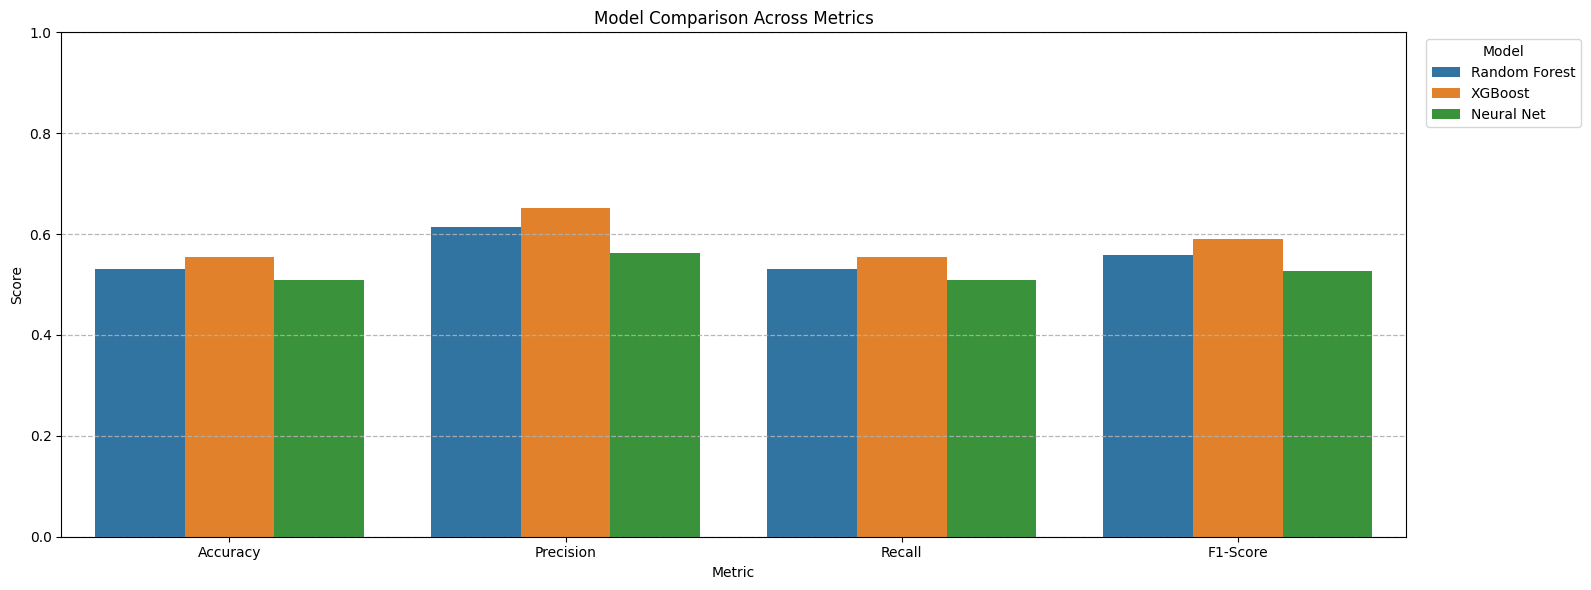

In [11]:
def plot_models_metrics_compareing(models_results, plot_name: str = "metric_average") -> None:
    results_df = pd.DataFrame(models_results)
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    melted_df = results_df.melt(id_vars="Model", value_vars=metrics, var_name="Metric", value_name="Score")
    plt.figure(figsize=(16, 6))
    ax = sns.barplot(data=melted_df, x="Metric", y="Score", hue="Model")
    ax.grid(axis="y", linestyle="--", linewidth=0.9, alpha=0.9)
    plt.title("Model Comparison Across Metrics")
    plt.ylim(0, 1.0)
    plt.legend(title="Model", bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.tight_layout()
    save_plot(plot_name=plot_name, plot_path="average")
    plt.show()

plot_models_metrics_compareing(models_results_list)

### Extended metrics (macro-average)

In [12]:
def compute_average_classification_metrics(y_true: Union[list[int], np.ndarray], y_pred: Union[list[int], np.ndarray]) -> pd.DataFrame:
    cm: np.ndarray = confusion_matrix(y_true, y_pred)
    n_classes: int = cm.shape[0]
    acc_list: list[float] = []
    prec_list: list[float] = []
    rec_list: list[float] = []
    tnr_list: list[float] = []
    fpr_list: list[float] = []
    fnr_list: list[float] = []
    npv_list: list[float] = []
    fdr_list: list[float] = []
    bal_acc_list: list[float] = []
    f1_list: list[float] = []
    for i in range(n_classes):
        tp: int = cm[i, i]
        fn: int = cm[i, :].sum() - tp
        fp: int = cm[:, i].sum() - tp
        tn: int = cm.sum() - (tp + fp + fn)
        acc: float = ((tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0)
        prec: float = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec: float = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        tnr: float = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        fpr: float = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fnr: float = fn / (tp + fn) if (tp + fn) > 0 else 0.0
        npv: float = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        fdr: float = fp / (tp + fp) if (tp + fp) > 0 else 0.0
        bal_acc: float = (rec + tnr) / 2
        f1: float = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0
        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        tnr_list.append(tnr)
        fpr_list.append(fpr)
        fnr_list.append(fnr)
        npv_list.append(npv)
        fdr_list.append(fdr)
        bal_acc_list.append(bal_acc)
        f1_list.append(f1)
    metrics: dict[str, float] = {
        "Macro accuracy": float(np.mean(acc_list)),
        "Precision": float(np.mean(prec_list)),
        "Recall / TPR": float(np.mean(rec_list)),
        "F1-Score": float(np.mean(f1_list)),
        "FPR": float(np.mean(fpr_list)),
        "NPV (Negative Predictive Value)": float(np.mean(npv_list)),
        "Balanced Accuracy": float(np.mean(bal_acc_list)),
    }
    return pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])

metrics_xg = compute_average_classification_metrics(Y_TEST_REDUCED, y_pred_xg)
metrics_rf = compute_average_classification_metrics(Y_TEST_REDUCED, y_pred_rf)
metrics_nn = compute_average_classification_metrics(Y_TEST_REDUCED, y_pred_nn)
metrics_xg.columns = [XGBOOST]; metrics_rf.columns = [RANDOM_FOREST]; metrics_nn.columns = [NEURAL_NET]
concated_average_scores_metrics = pd.concat([metrics_xg, metrics_rf, metrics_nn], axis=1)
print(tabulate(concated_average_scores_metrics, headers="keys", tablefmt="grid", showindex=True))
save_dataframe(df=concated_average_scores_metrics, name="score average")

+---------------------------------+-----------+-----------------+--------------+
|                                 |   XGBoost |   Random Forest |   Neural Net |
+=================================+===========+=================+==============+
| Macro accuracy                  |  0.957593 |        0.955283 |    0.953151  |
+---------------------------------+-----------+-----------------+--------------+
| Precision                       |  0.651162 |        0.614533 |    0.563458  |
+---------------------------------+-----------+-----------------+--------------+
| Recall / TPR                    |  0.555067 |        0.530626 |    0.508407  |
+---------------------------------+-----------+-----------------+--------------+
| F1-Score                        |  0.589364 |        0.55814  |    0.526853  |
+---------------------------------+-----------+-----------------+--------------+
| FPR                             |  0.02227  |        0.023486 |    0.0245997 |
+---------------------------

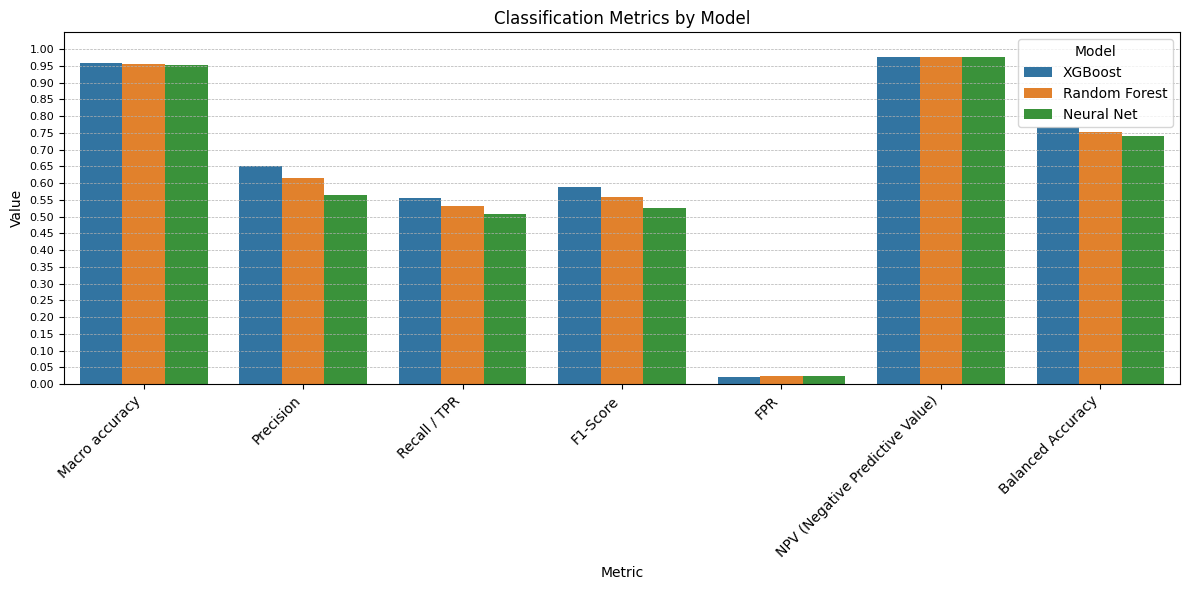

In [13]:
def plot_score_metrics(metrics_df: pd.DataFrame) -> None:
    df: pd.DataFrame = metrics_df.reset_index().melt(id_vars="index", var_name="Model", value_name="Value")
    df.rename(columns={"index": "Metric"}, inplace=True)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x="Metric", y="Value", hue="Model")
    plt.title("Classification Metrics by Model")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(np.linspace(0, 1, 21))
    plt.yticks(fontsize=8)
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.ylim(0, 1.05)
    plt.legend(title="Model")
    plt.tight_layout()
    save_plot(plot_name="score average", plot_path="average")
    plt.show()

plot_score_metrics(concated_average_scores_metrics)

### Metrics per fault (tables)

In [14]:
def compute_classification_metrics_per_class(y_true: Union[list[int], np.ndarray], y_pred: Union[list[int], np.ndarray]) -> pd.DataFrame:
    cm: np.ndarray = confusion_matrix(y_true, y_pred)
    n_classes: int = cm.shape[0]
    metrics: list[dict] = []
    for i in range(n_classes):
        tp: int = cm[i, i]
        fn: int = cm[i, :].sum() - tp
        fp: int = cm[:, i].sum() - tp
        tn: int = cm.sum() - (tp + fp + fn)
        acc: float = ((tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0)
        prec: float = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec: float = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        tnr: float = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        fpr: float = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fnr: float = fn / (tp + fn) if (tp + fn) > 0 else 0.0
        npv: float = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        fdr: float = fp / (tp + fp) if (tp + fp) > 0 else 0.0
        bal_acc: float = (rec + tnr) / 2
        f1: float = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0
        metrics.append({
            "Class": i,
            "Accuracy": acc,
            "Precision": prec,
            "Recall / TPR": rec,
            "F1-Score": f1,
            "FPR": fpr,
            "NPV (Negative Predictive Value)": npv,
            "Balanced Accuracy": bal_acc,
        })
    return pd.DataFrame(metrics).set_index("Class")

classification_results_per_model: dict[str, pd.DataFrame] = {
    "Random Forest": compute_classification_metrics_per_class(Y_TEST_REDUCED, y_pred_rf),
    "XGBoost": compute_classification_metrics_per_class(Y_TEST_REDUCED, y_pred_xg),
    "Neural Net": compute_classification_metrics_per_class(Y_TEST_REDUCED, y_pred_nn),
}

for model_name, df in classification_results_per_model.items():
    average_row = df.mean(axis=0).to_frame().T
    average_row.index = ["Average"]
    df_out = pd.concat([df, average_row])
    save_dataframe(df=df_out, name=model_name, suffix="metrics")
    print(f"Classification Metrics for {model_name}:")
    print(tabulate(df_out, headers="keys", tablefmt="grid"))
    print("\n")

Classification Metrics for Random Forest:
+---------+------------+-------------+----------------+------------+-------------+-----------------------------------+---------------------+
|         |   Accuracy |   Precision |   Recall / TPR |   F1-Score |         FPR |   NPV (Negative Predictive Value) |   Balanced Accuracy |
+=========+============+=============+================+============+=============+===================================+=====================+
| 0       |   0.808037 |    0.108514 |      0.40625   |  0.171278  | 0.171337    |                          0.964521 |            0.617457 |
+---------+------------+-------------+----------------+------------+-------------+-----------------------------------+---------------------+
| 1       |   0.991963 |    0.994904 |      0.835294  |  0.90814   | 0.000213618 |                          0.991841 |            0.91754  |
+---------+------------+-------------+----------------+------------+-------------+------------------------------

### Plots per class

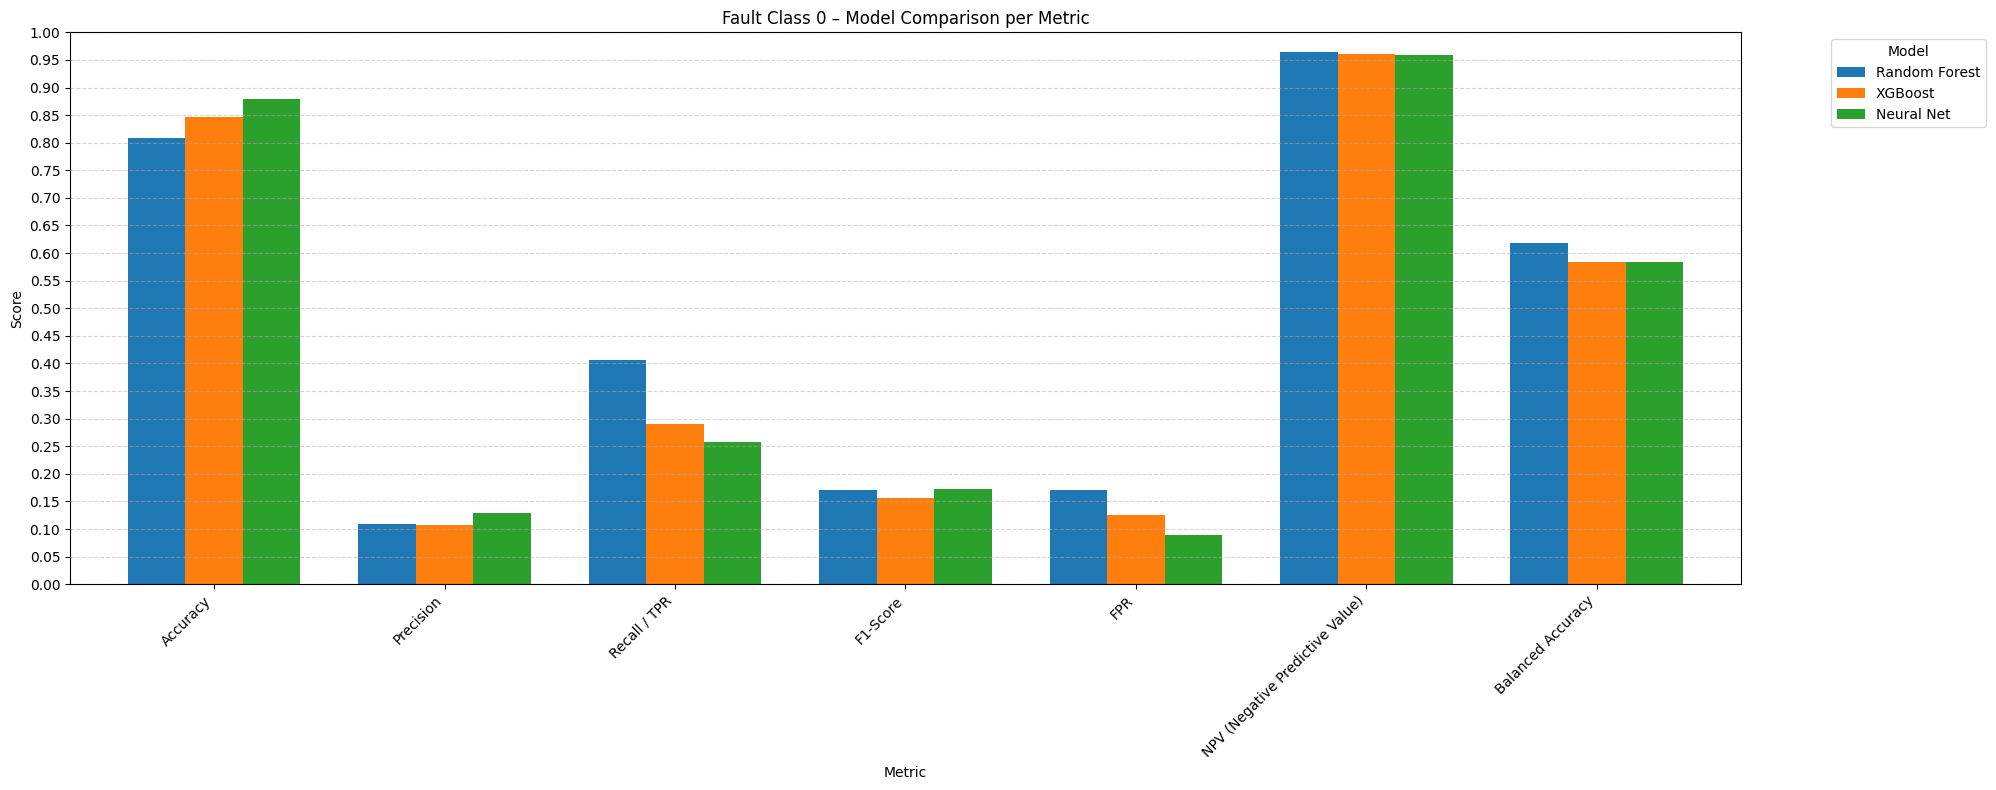

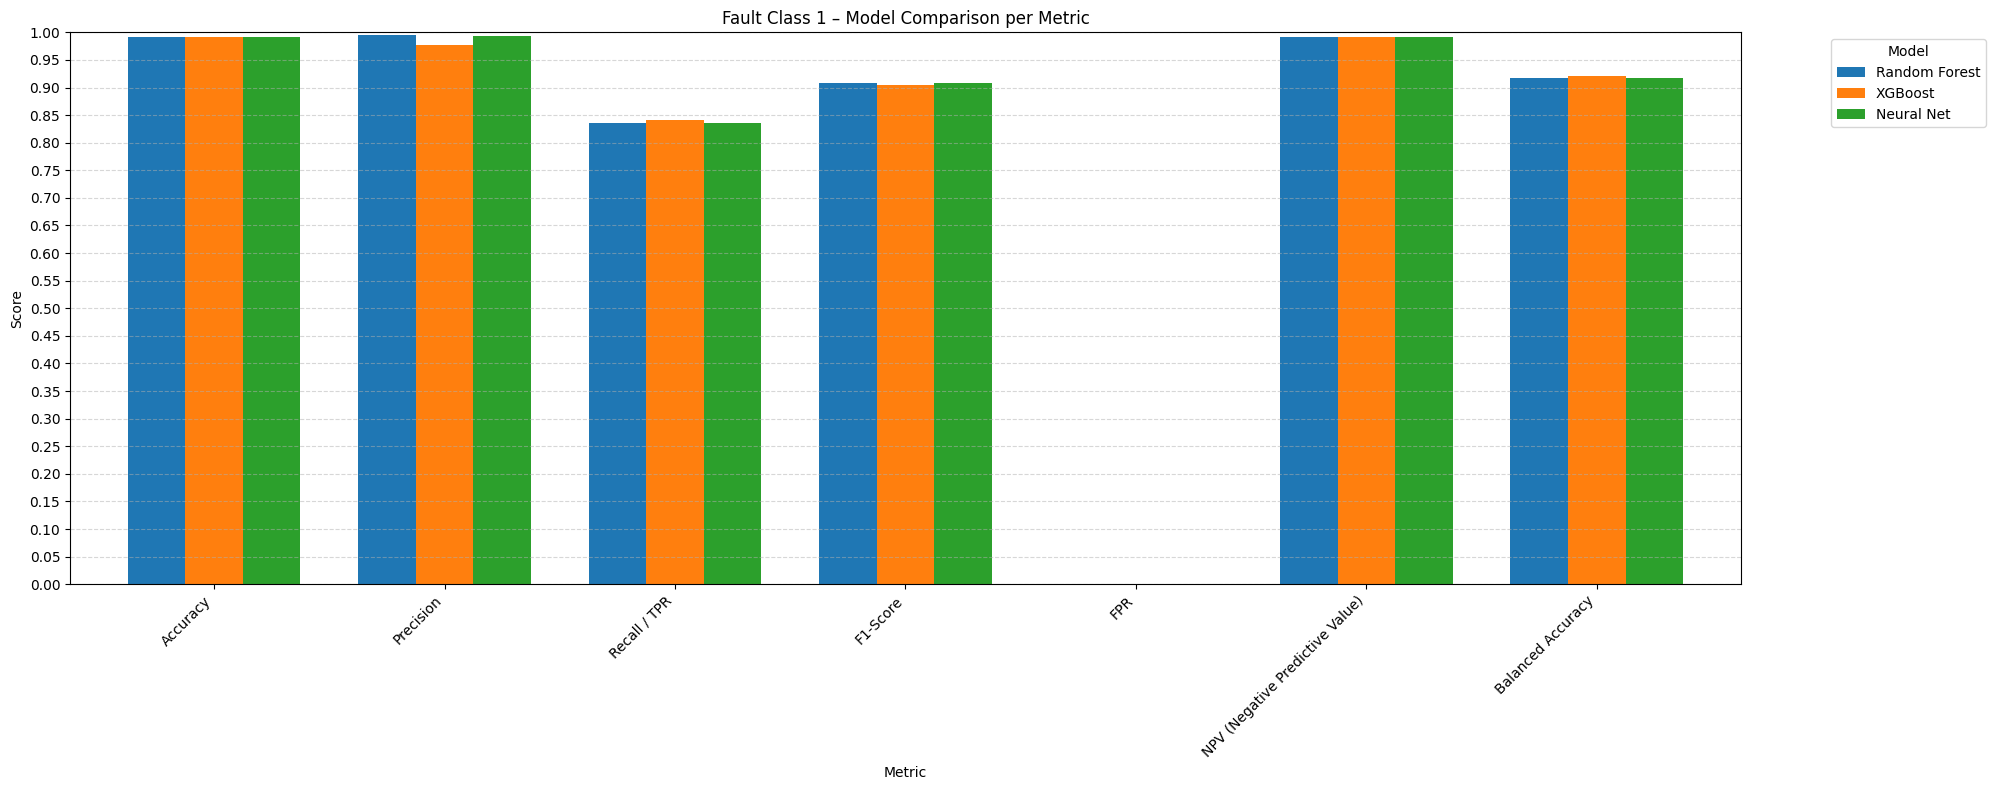

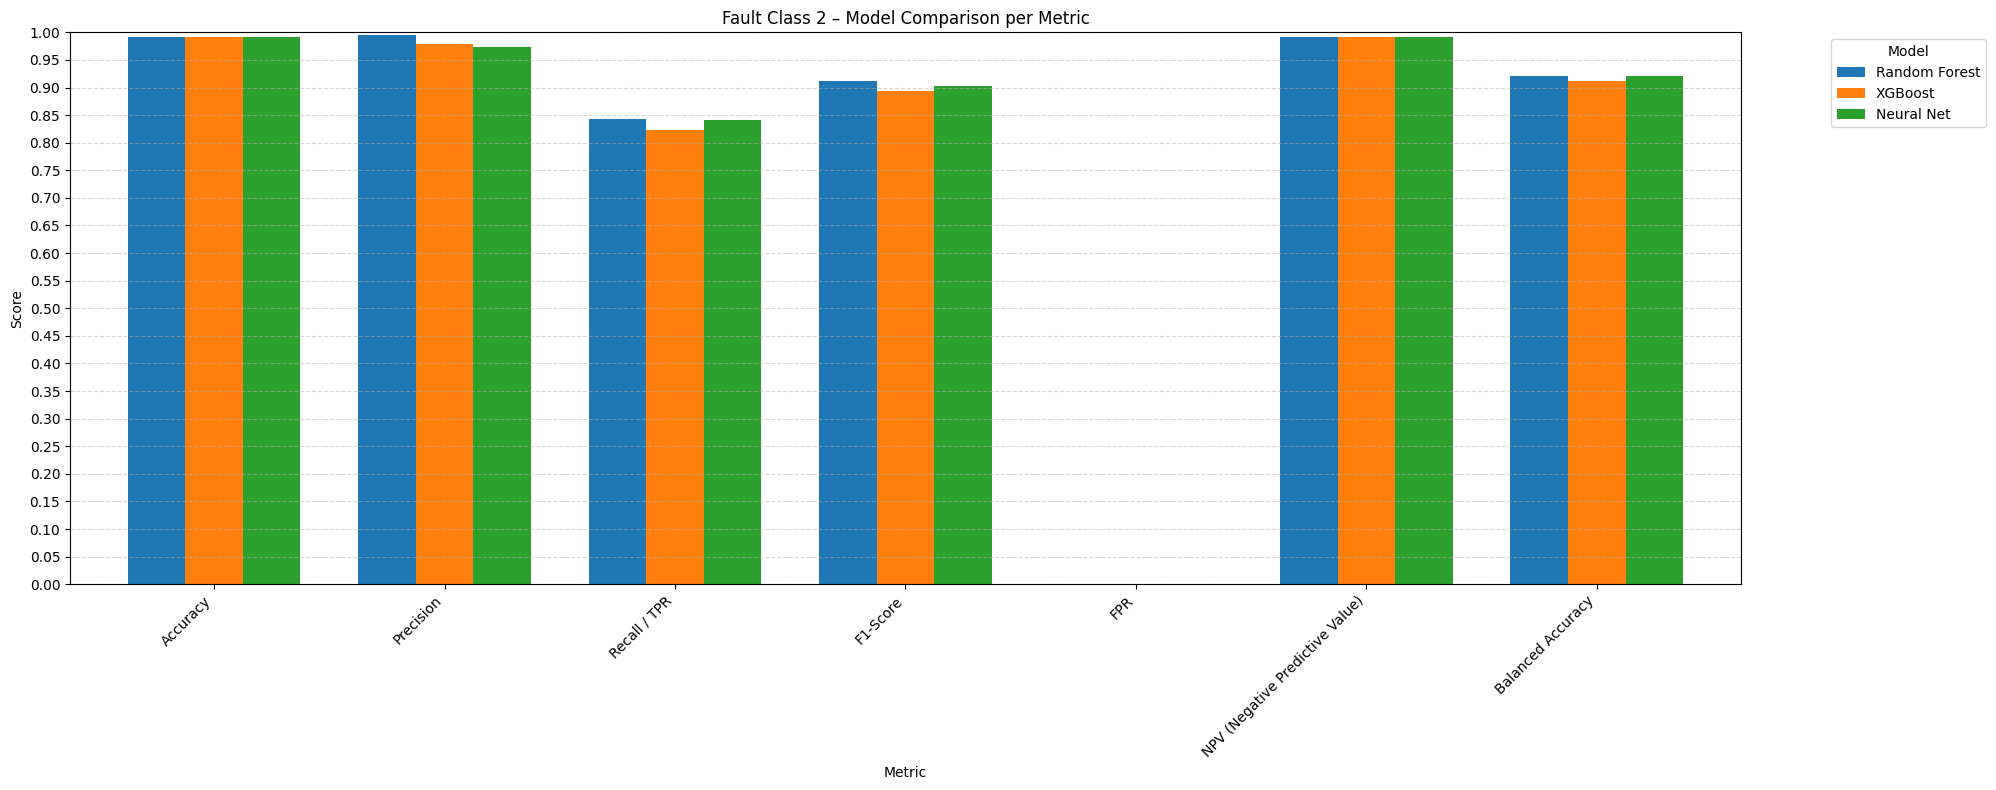

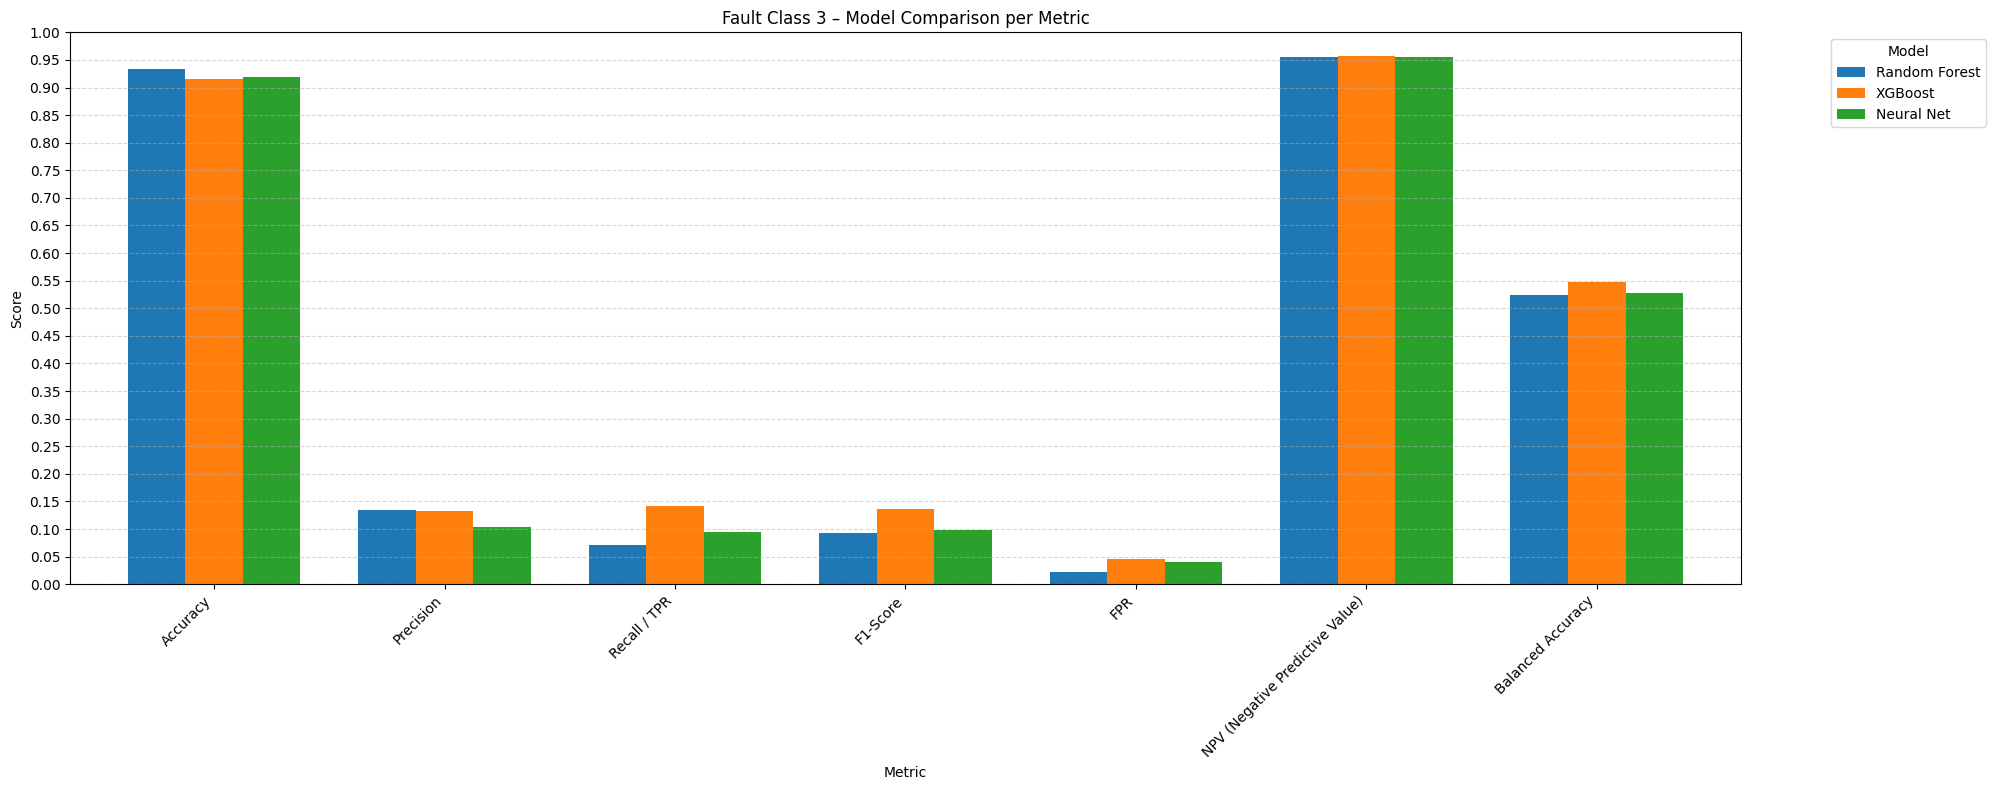

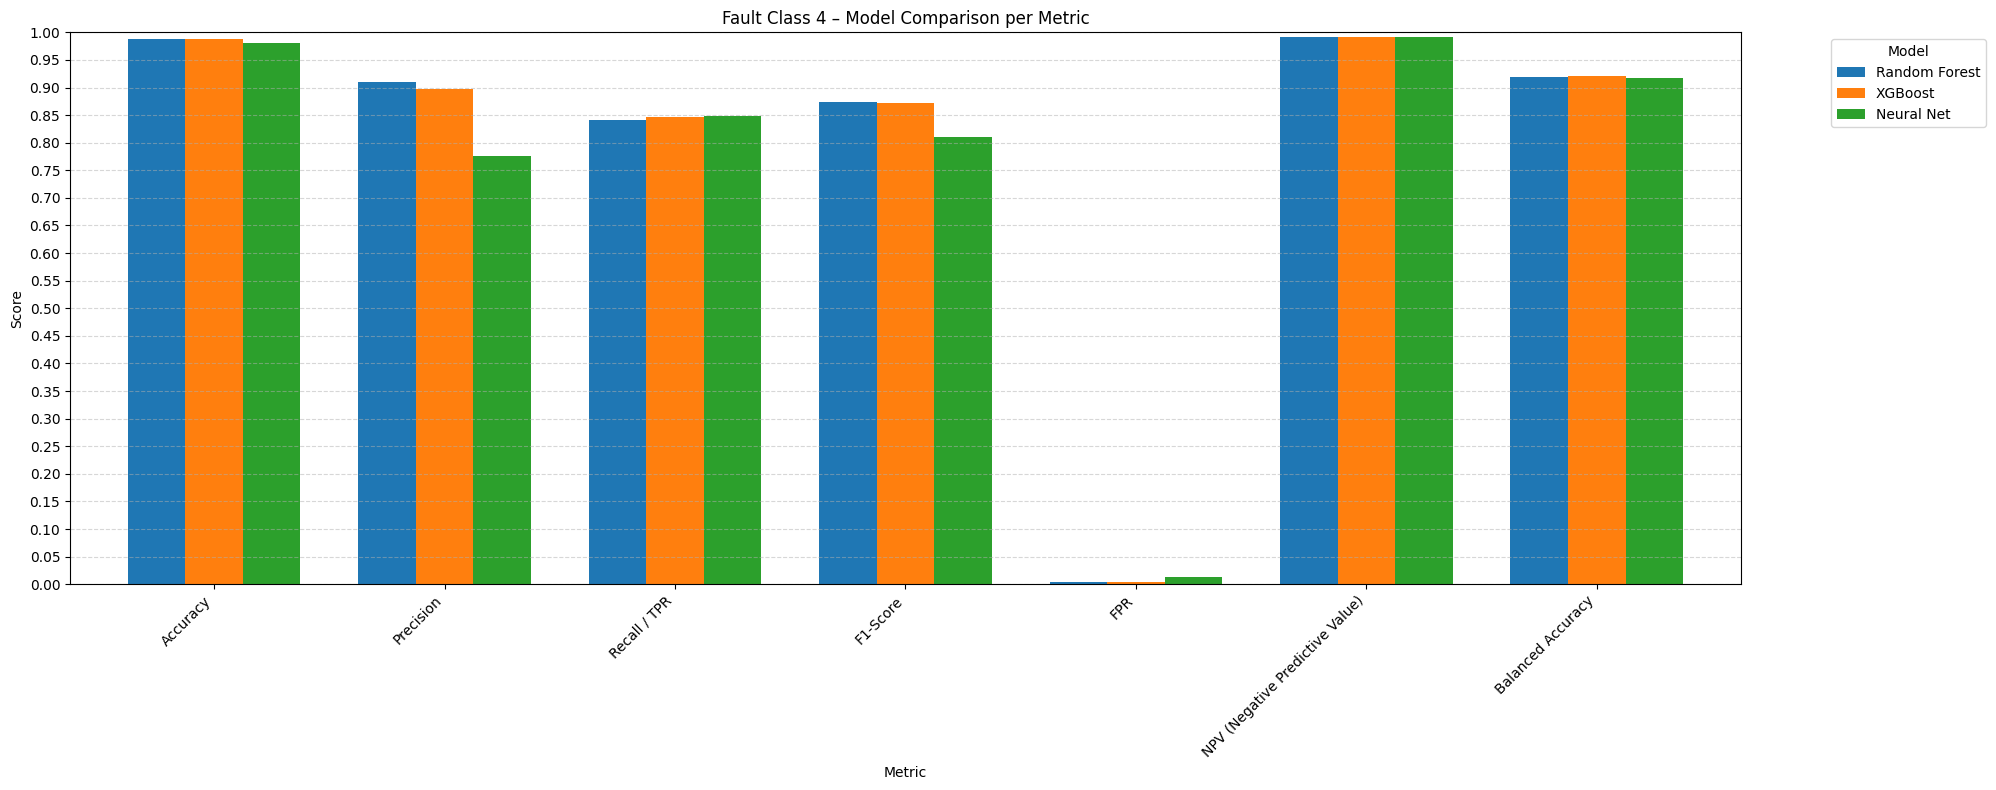

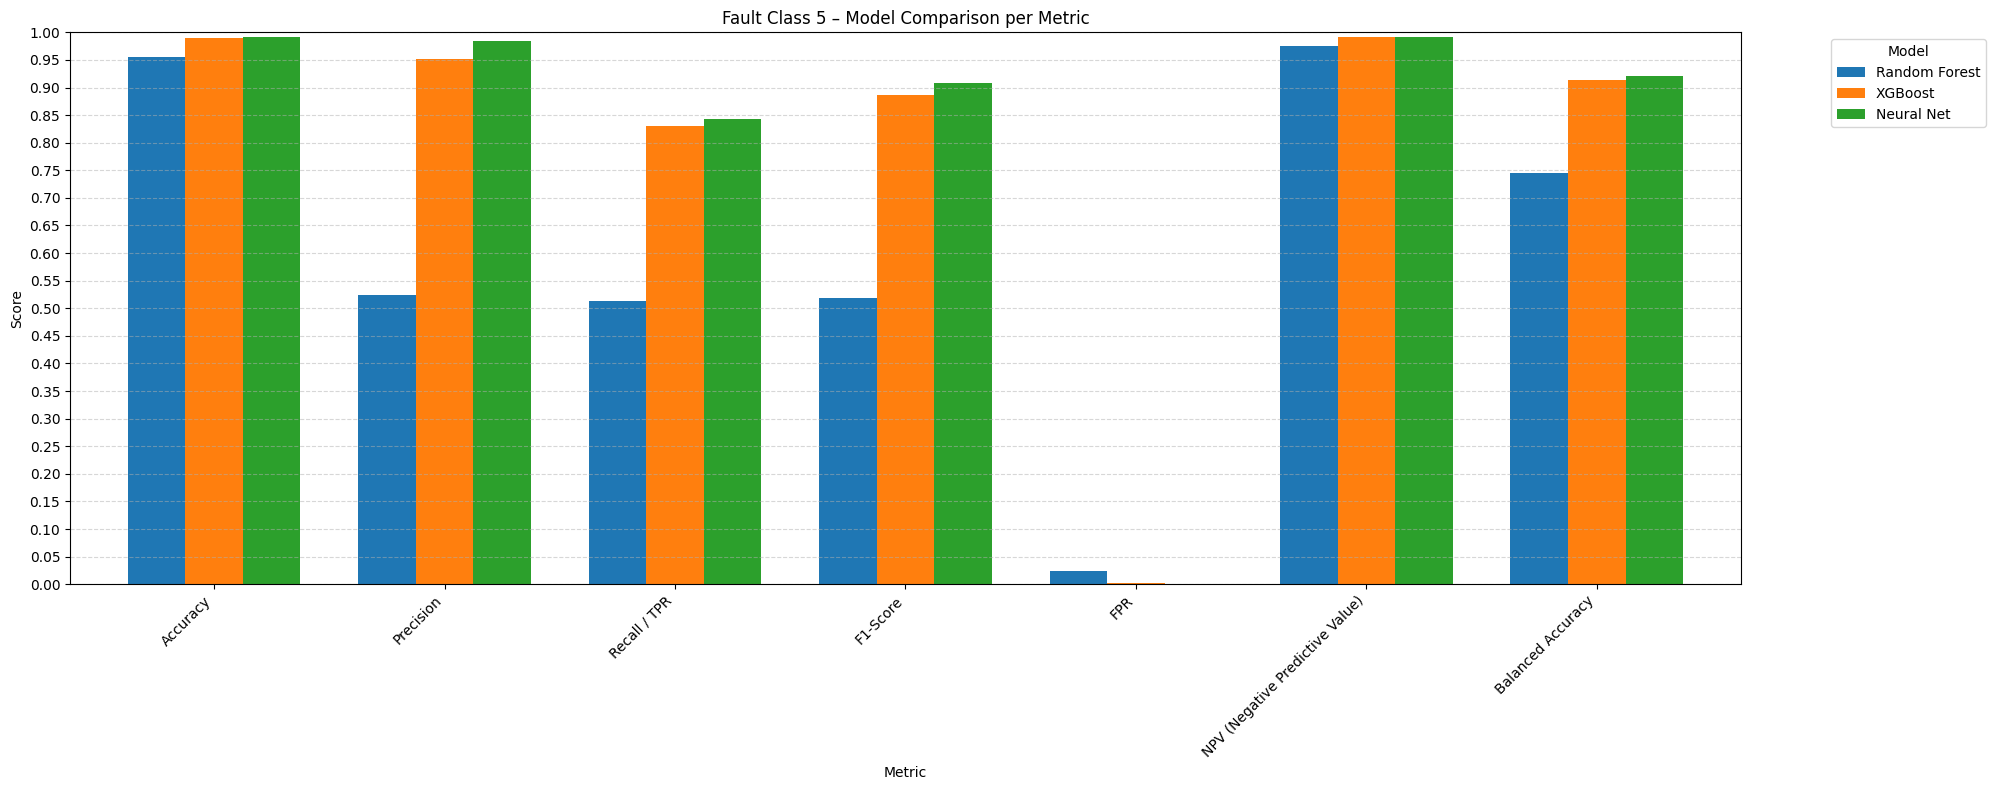

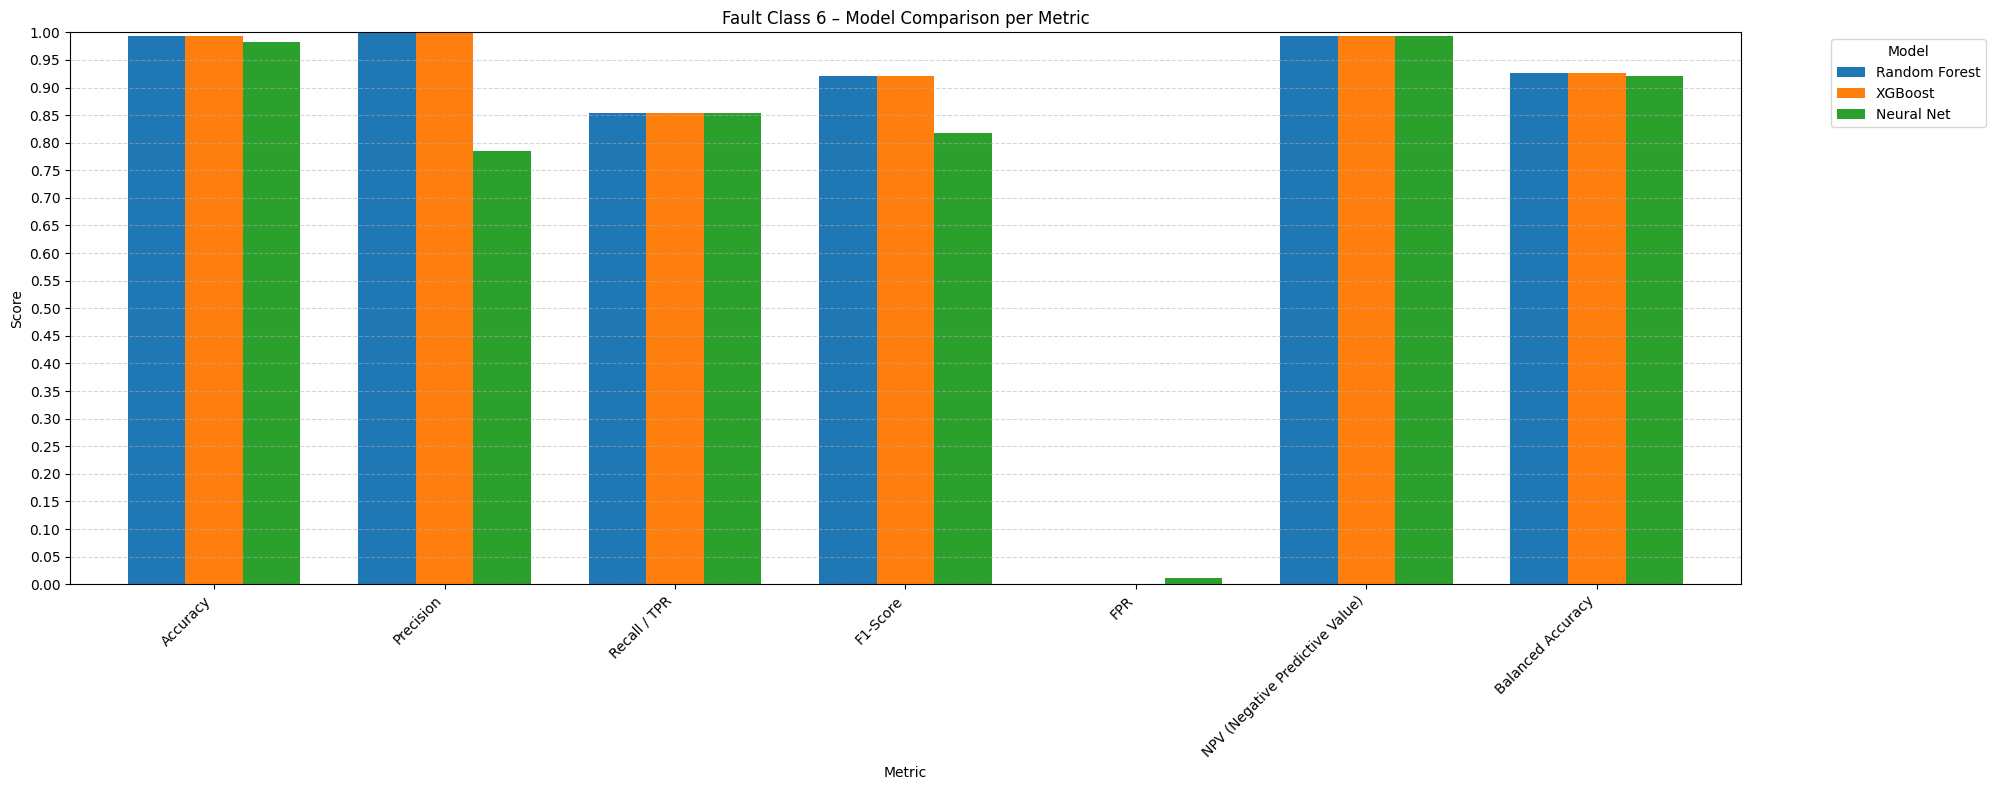

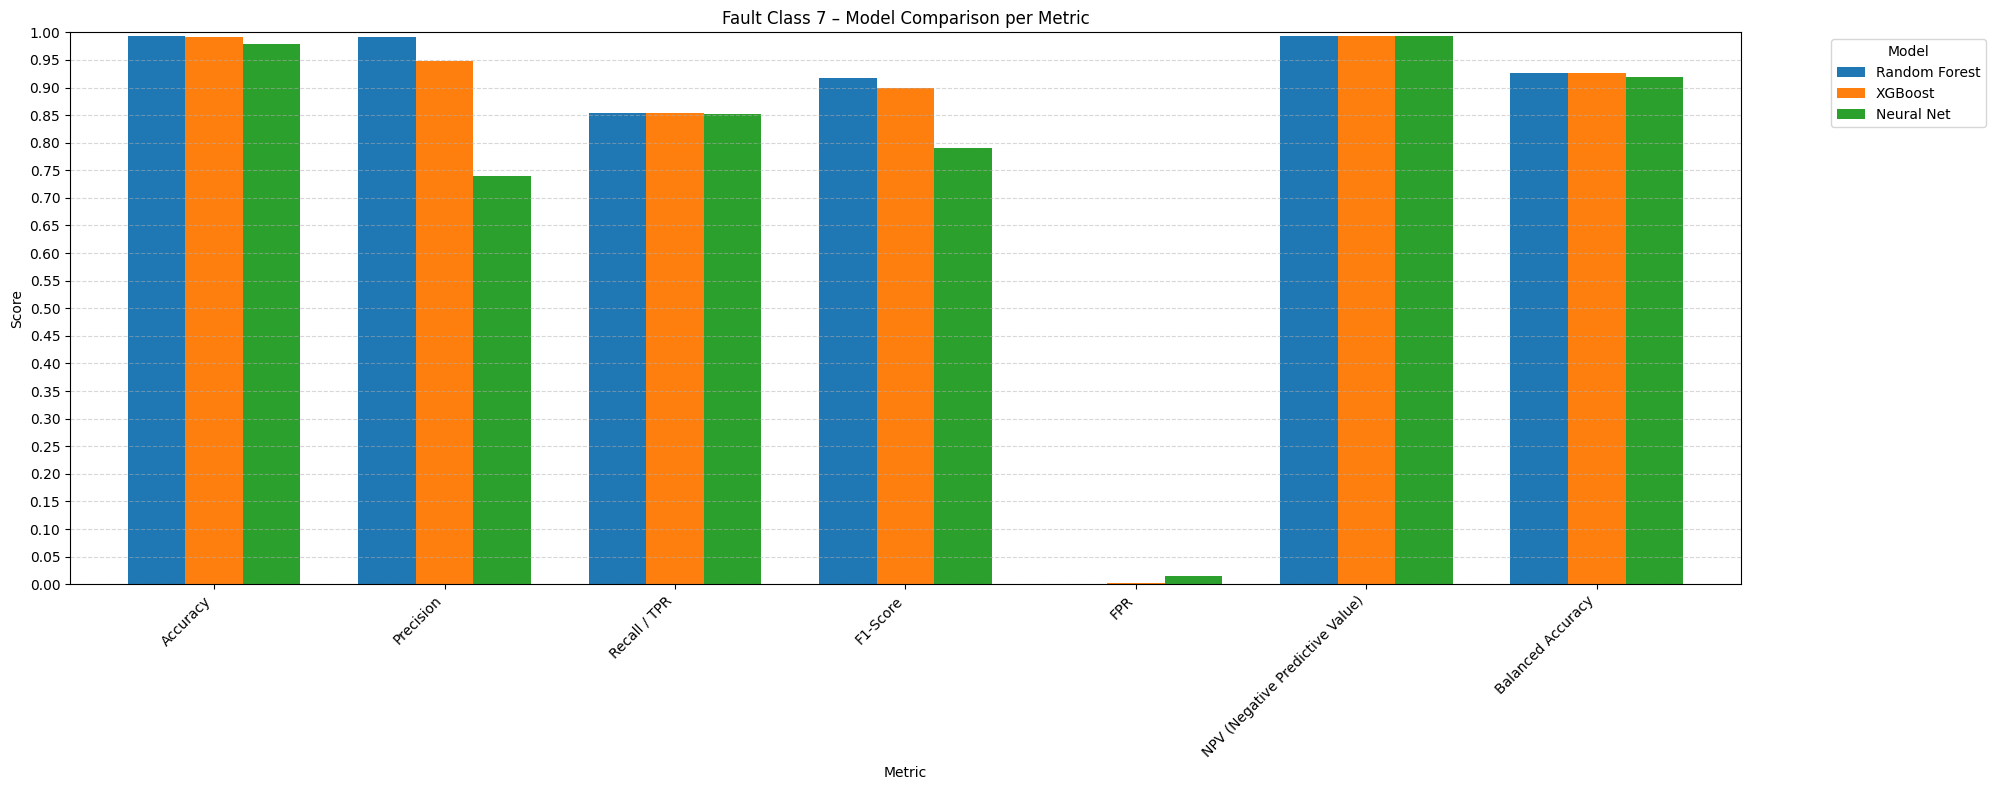

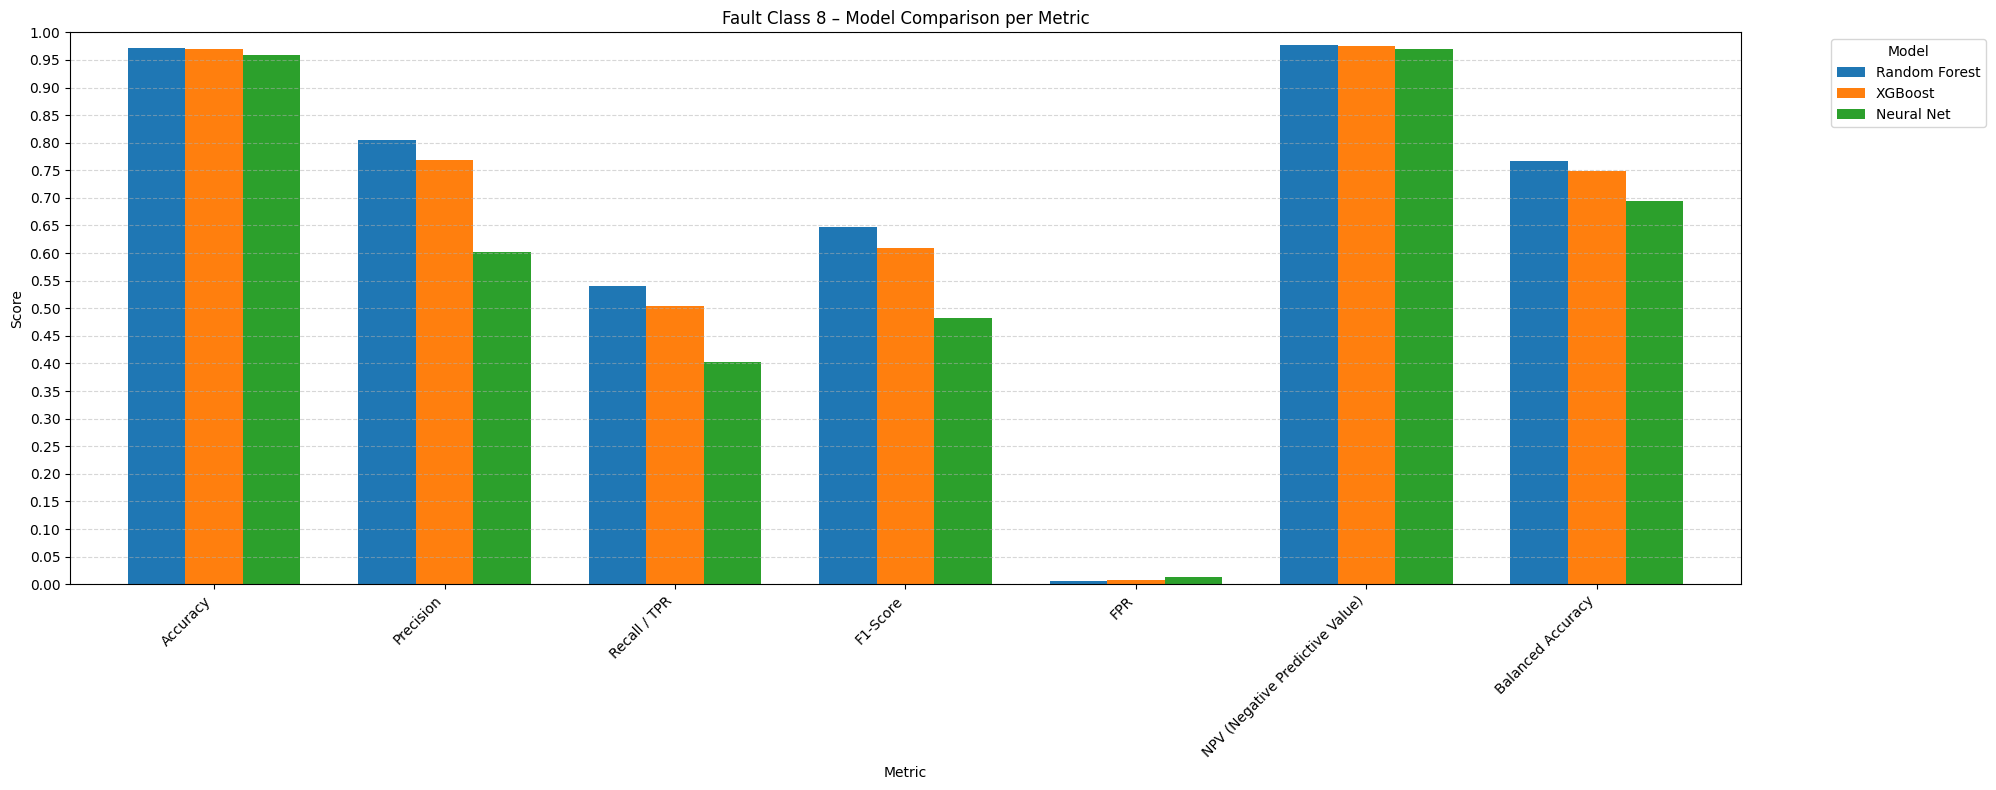

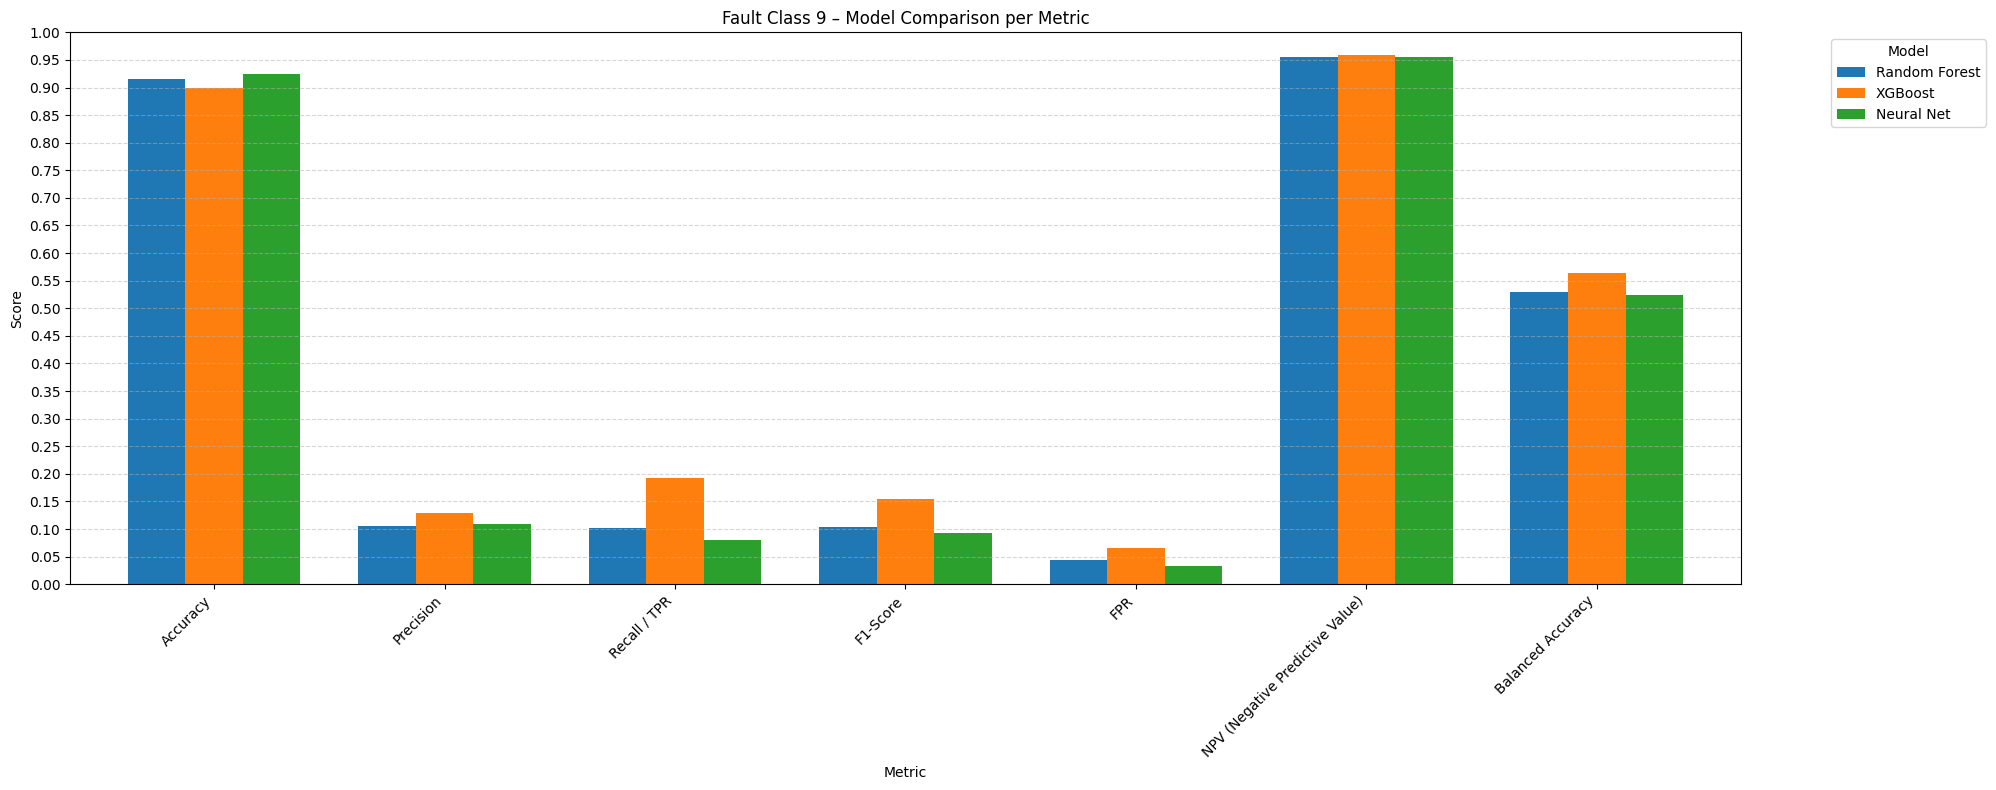

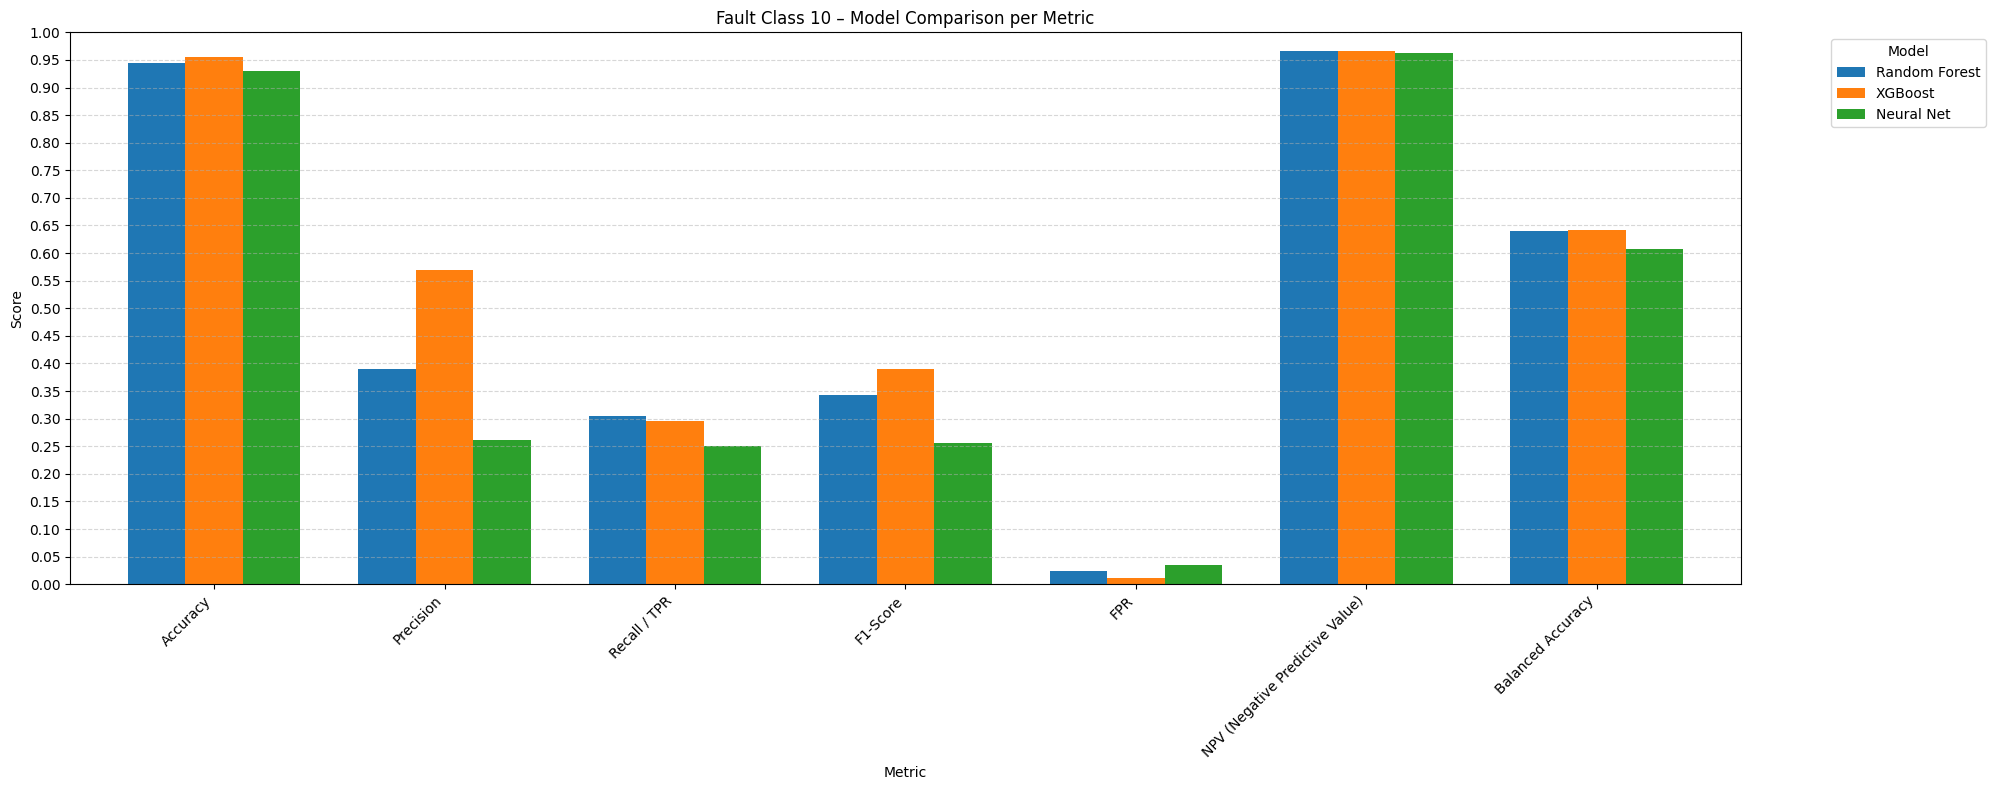

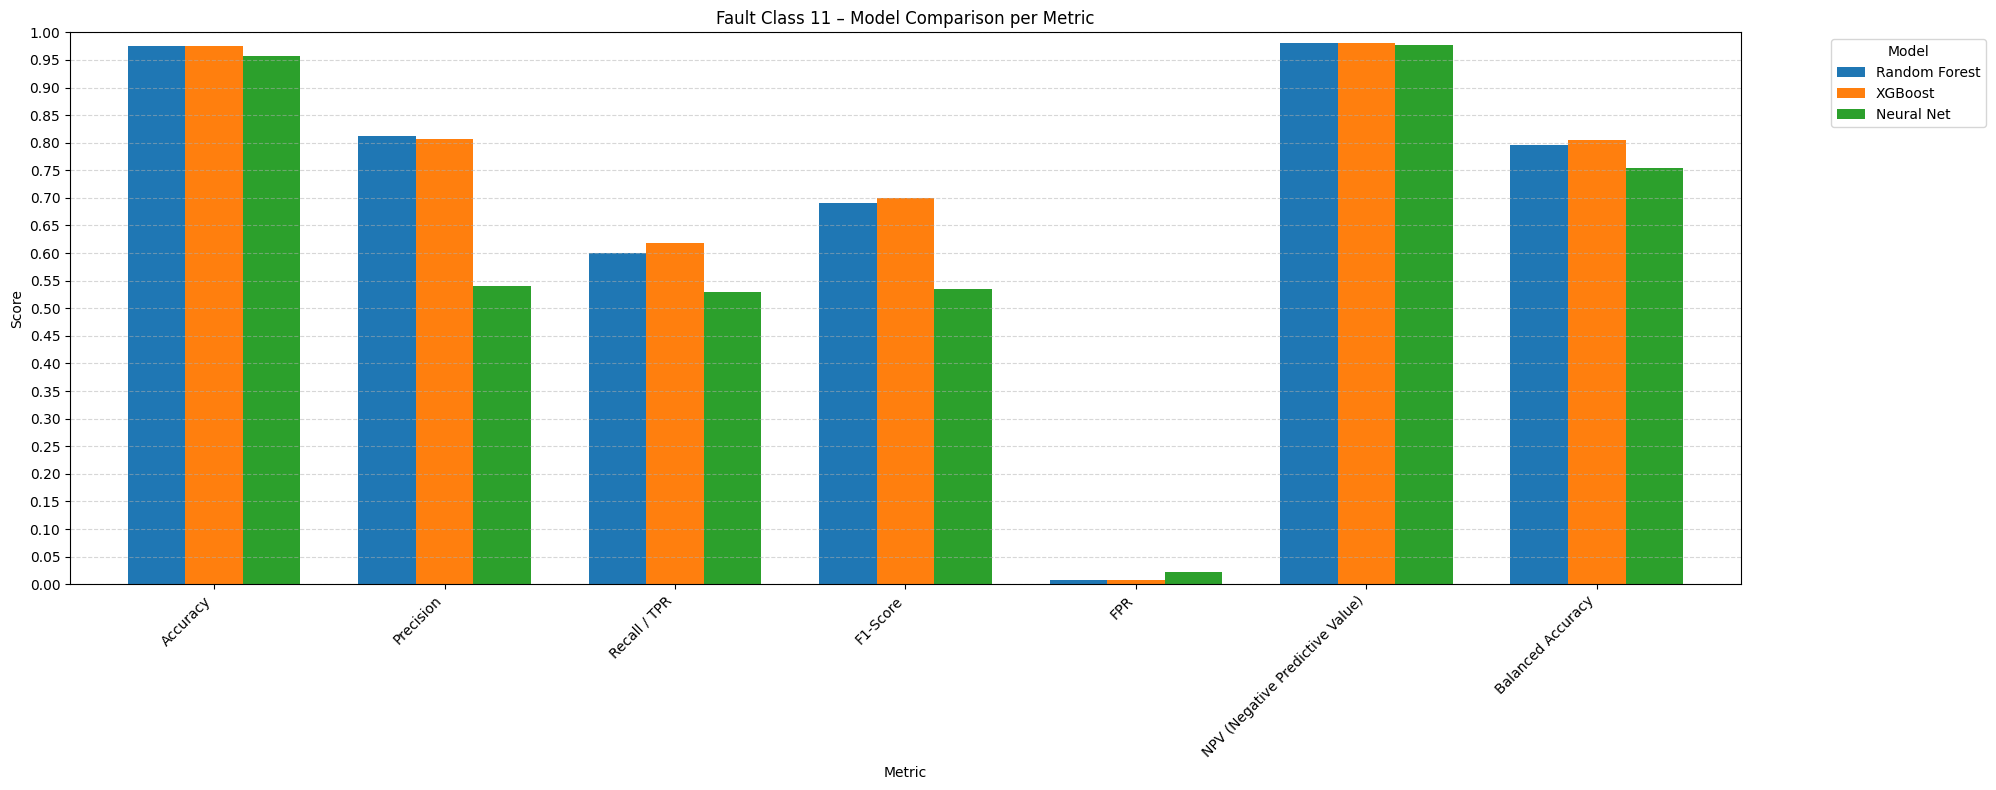

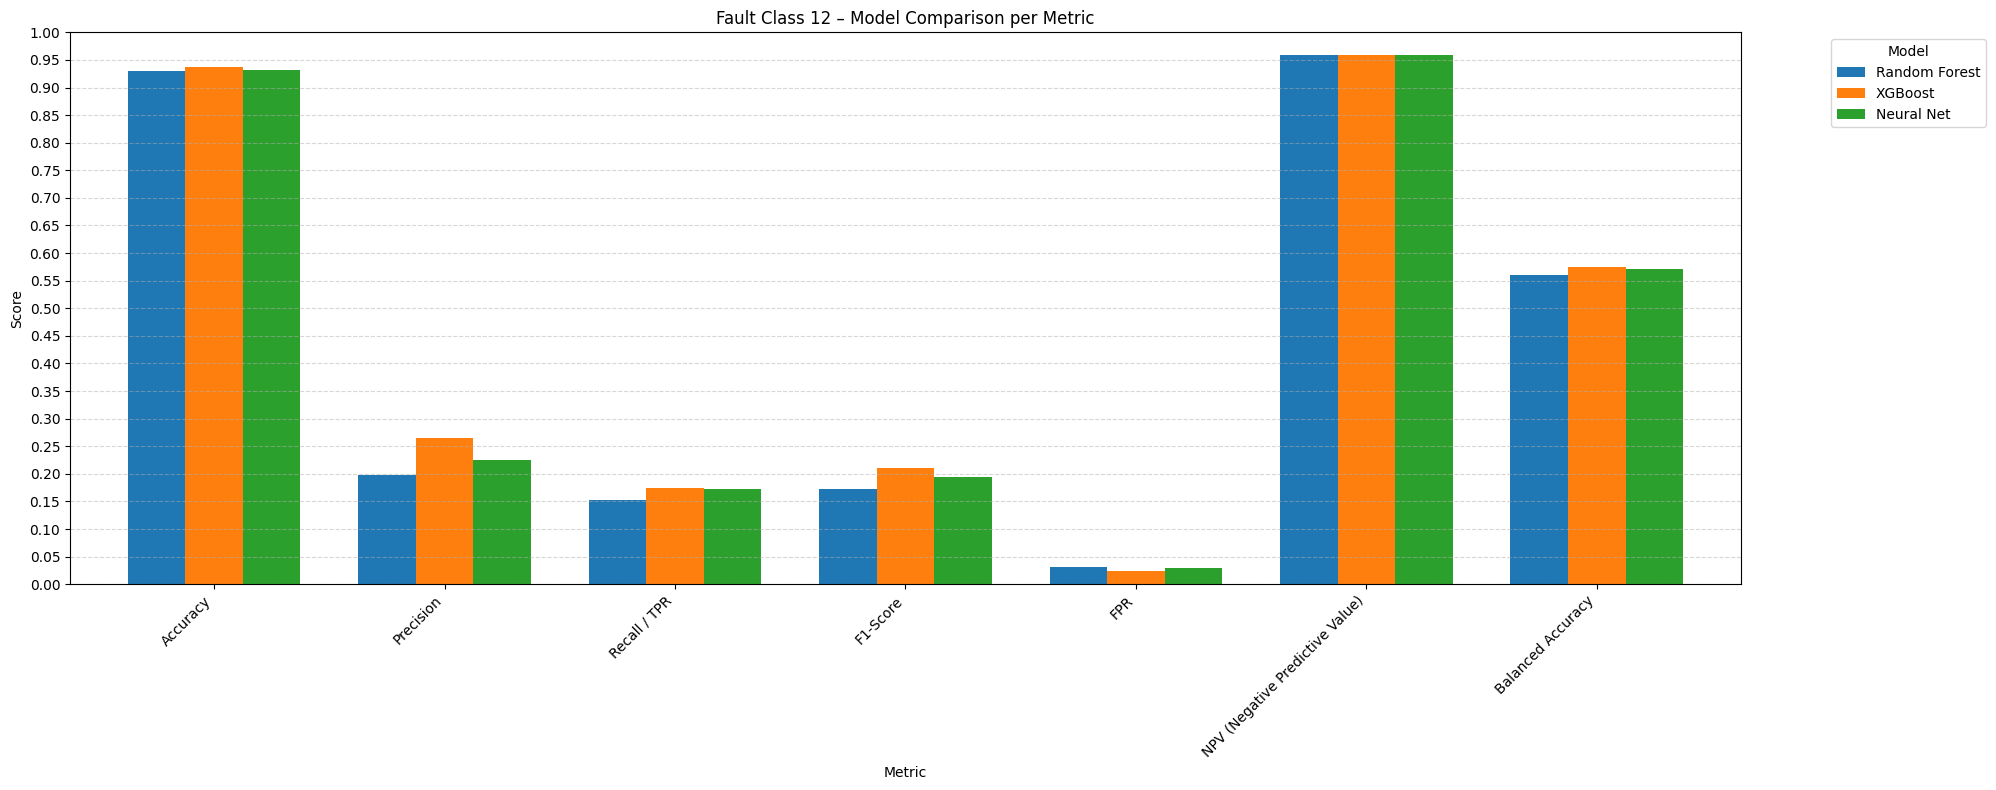

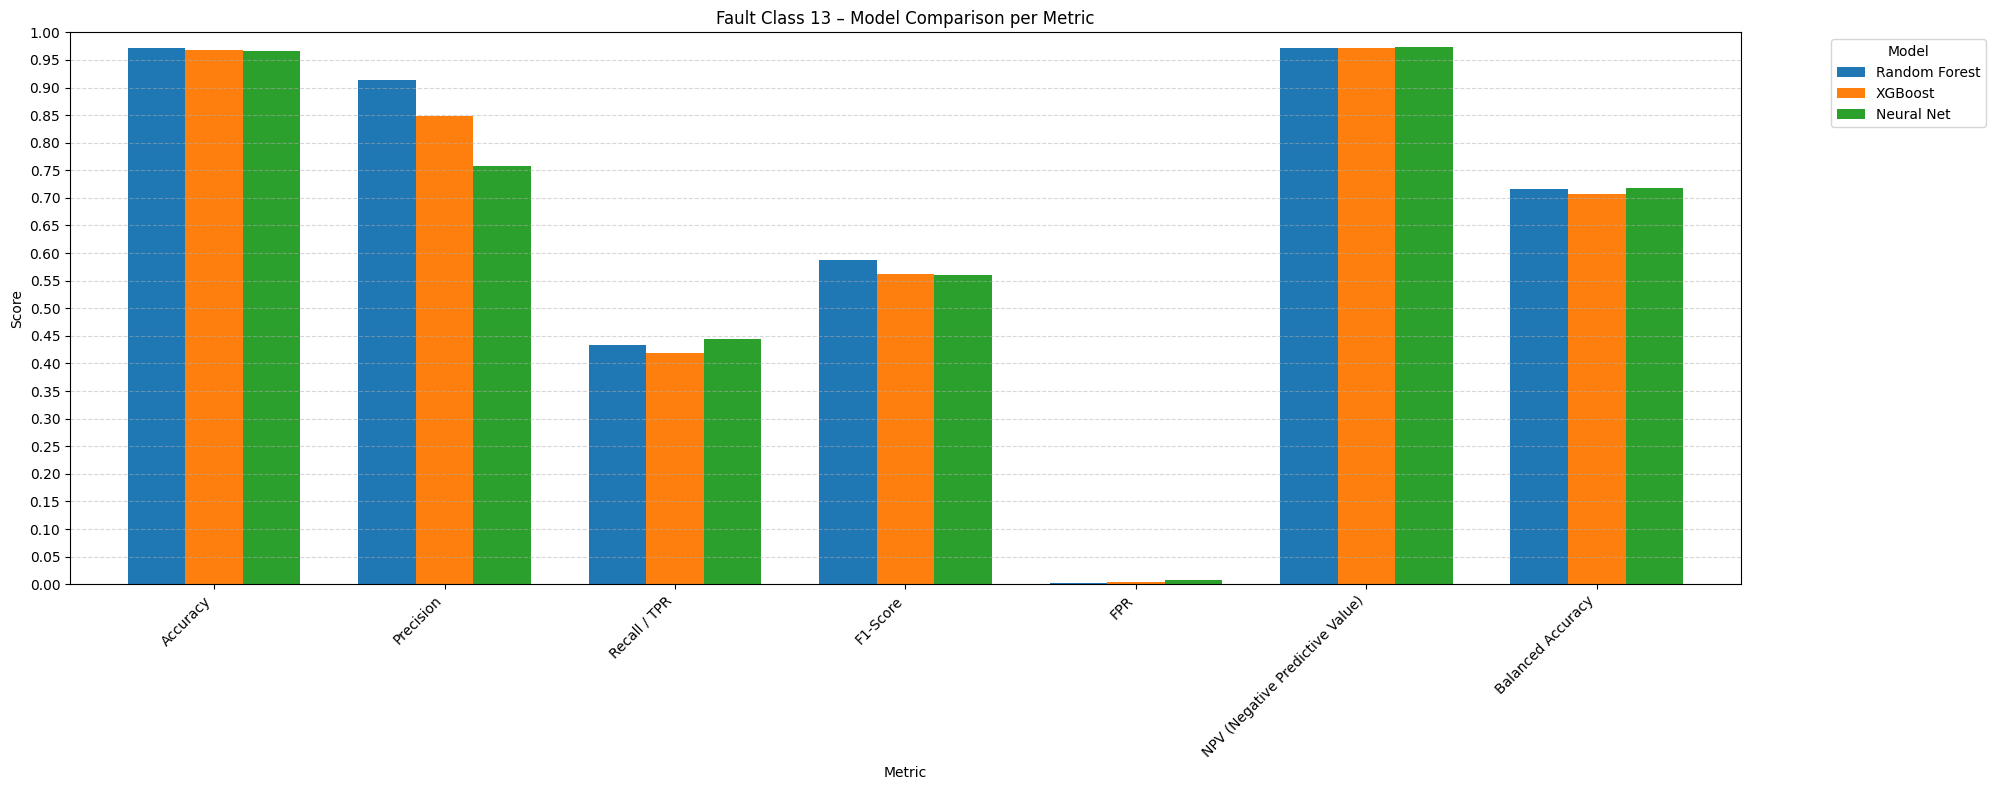

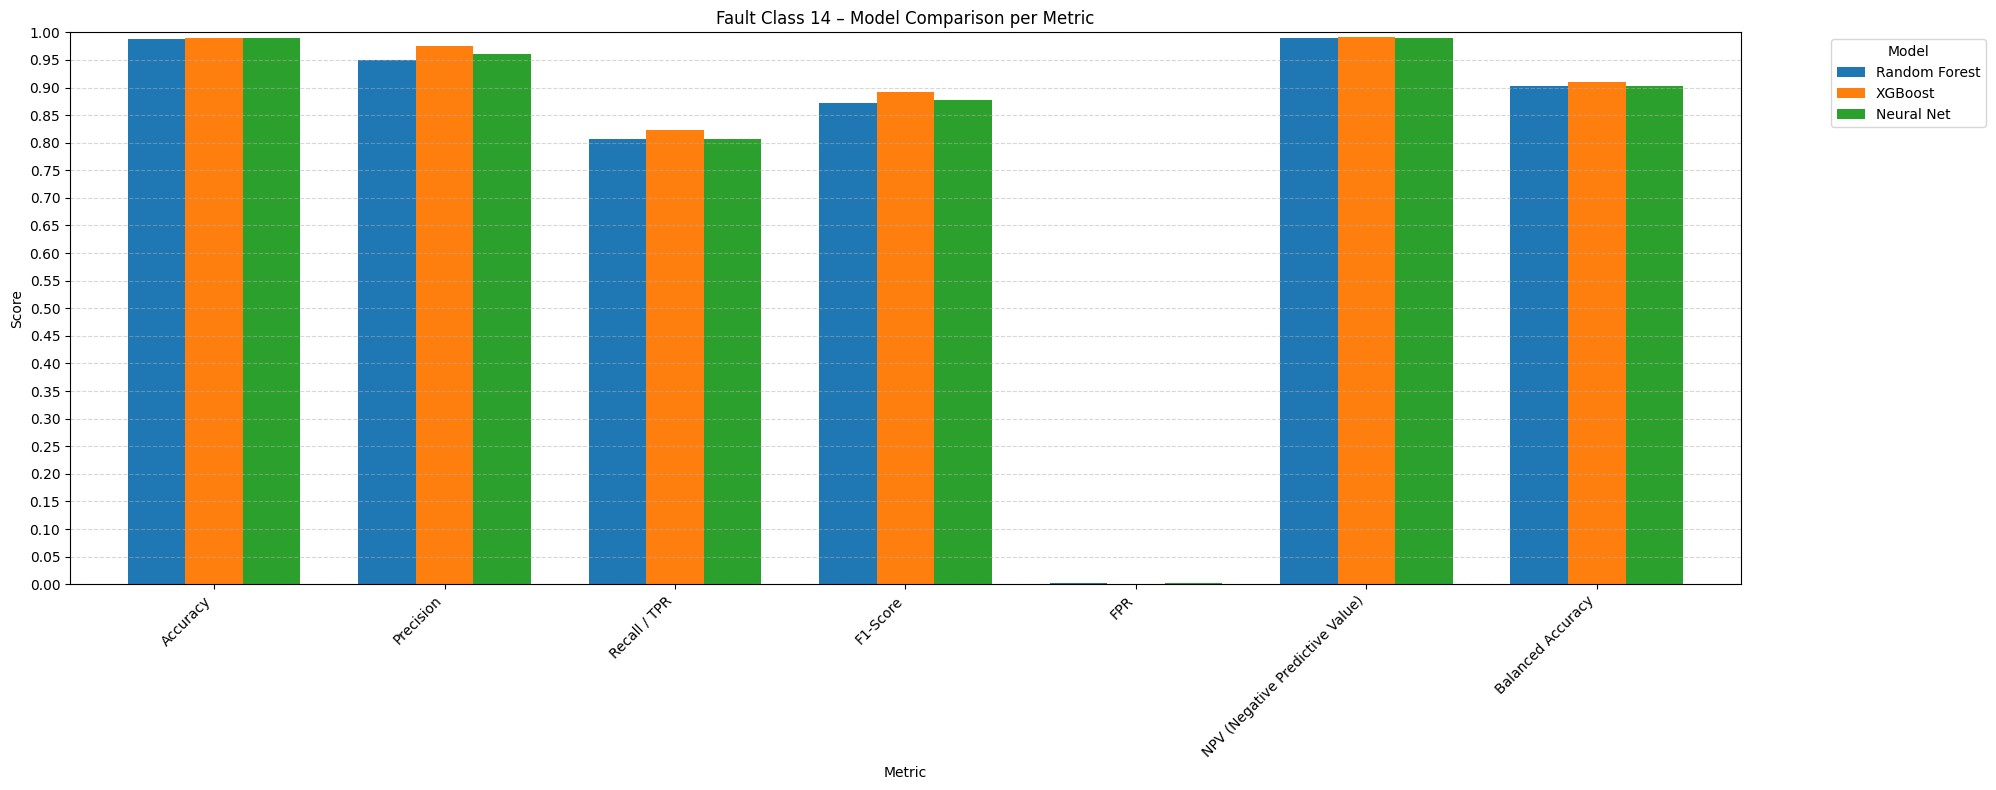

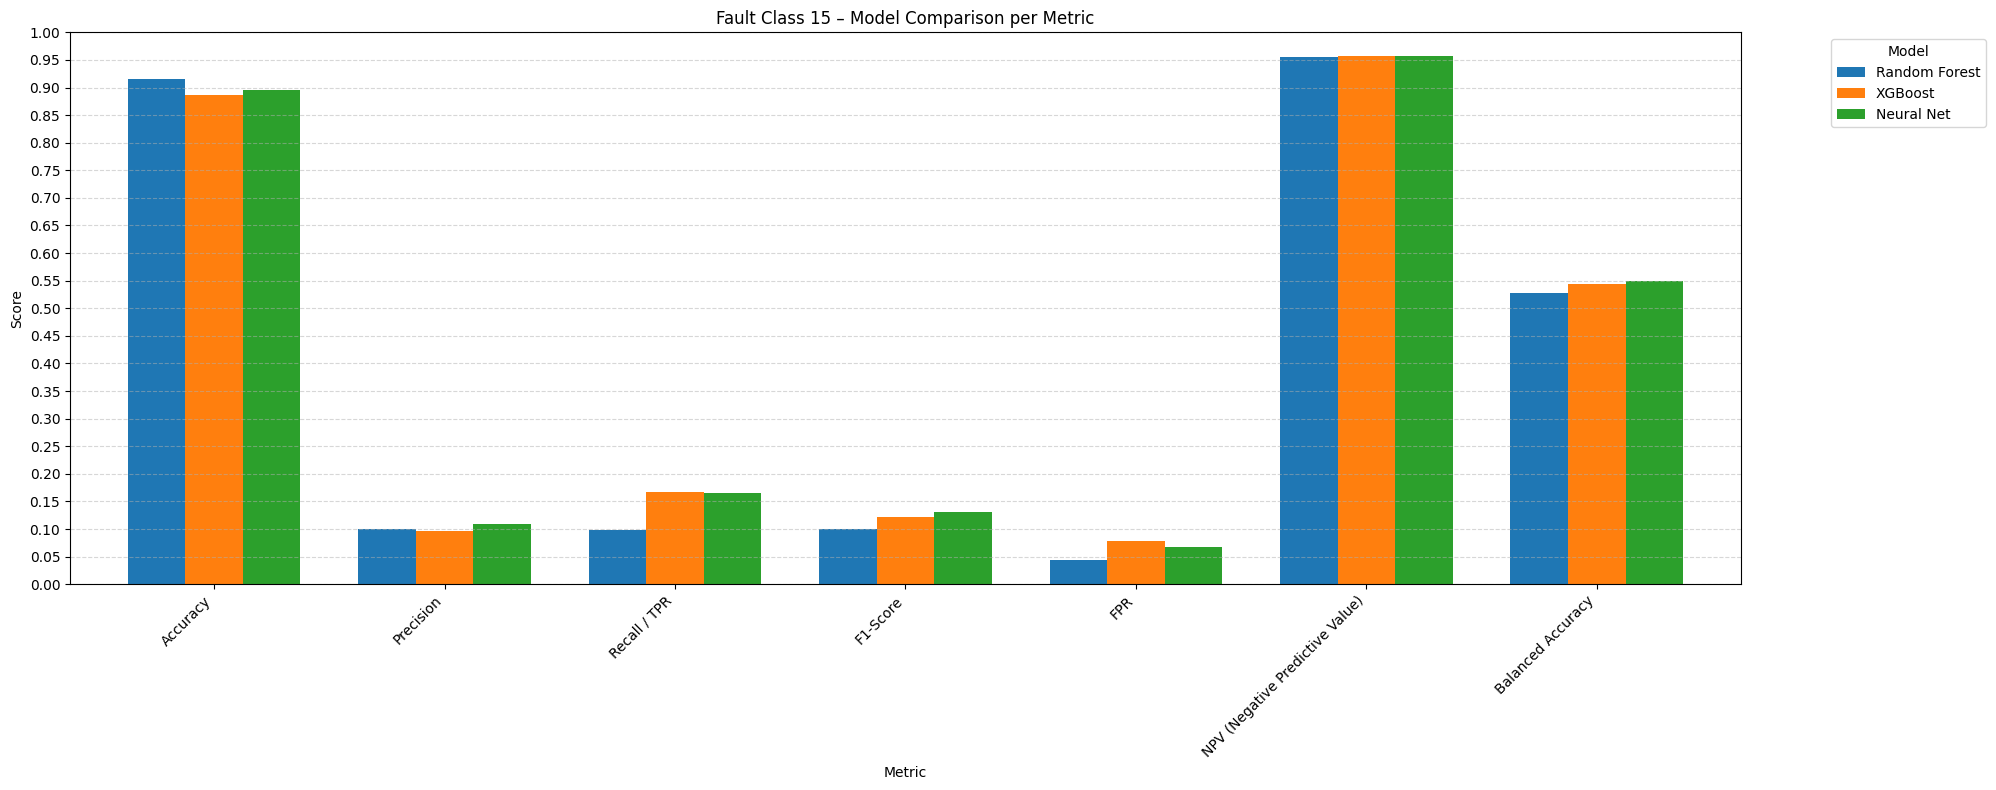

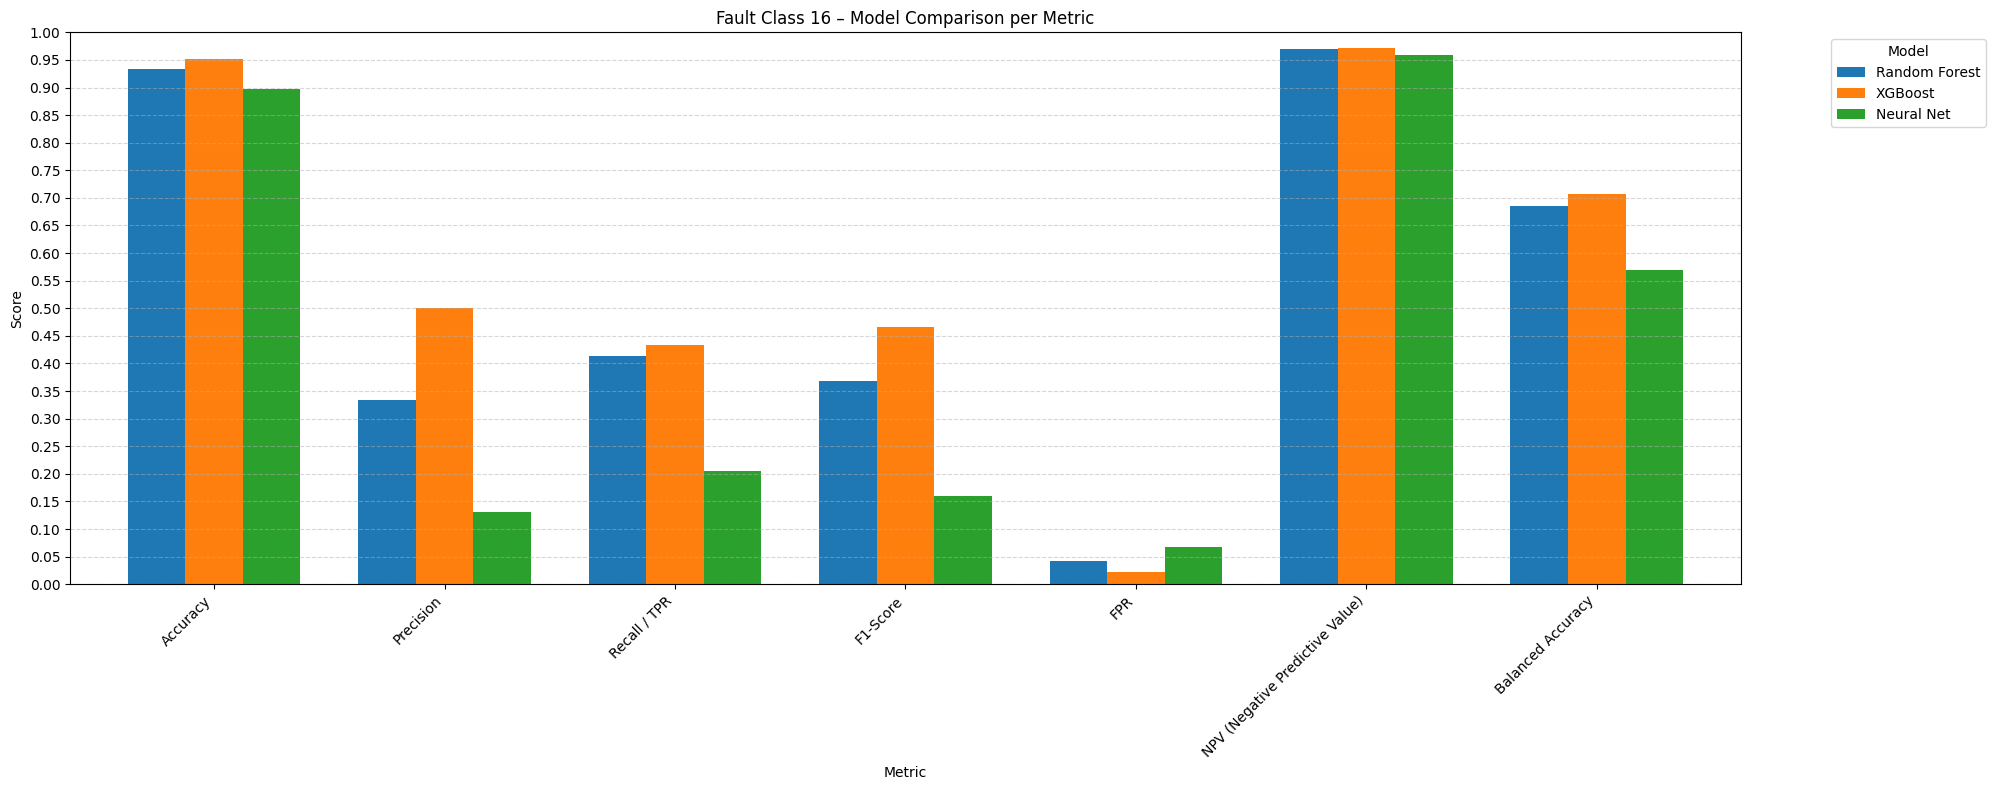

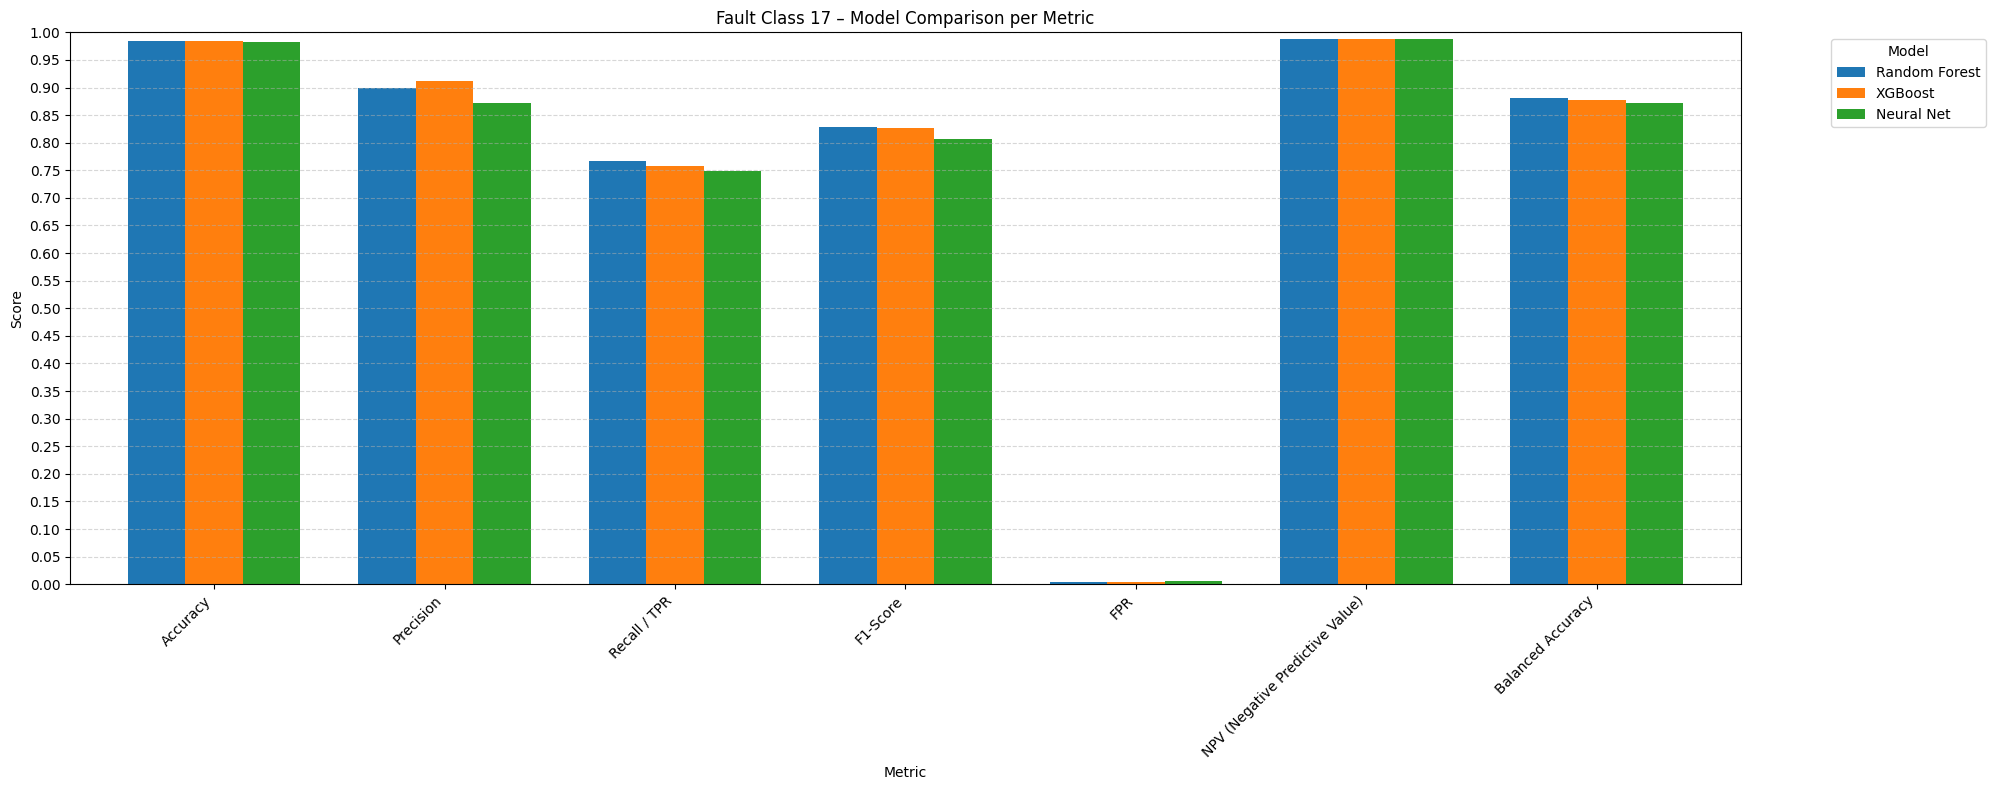

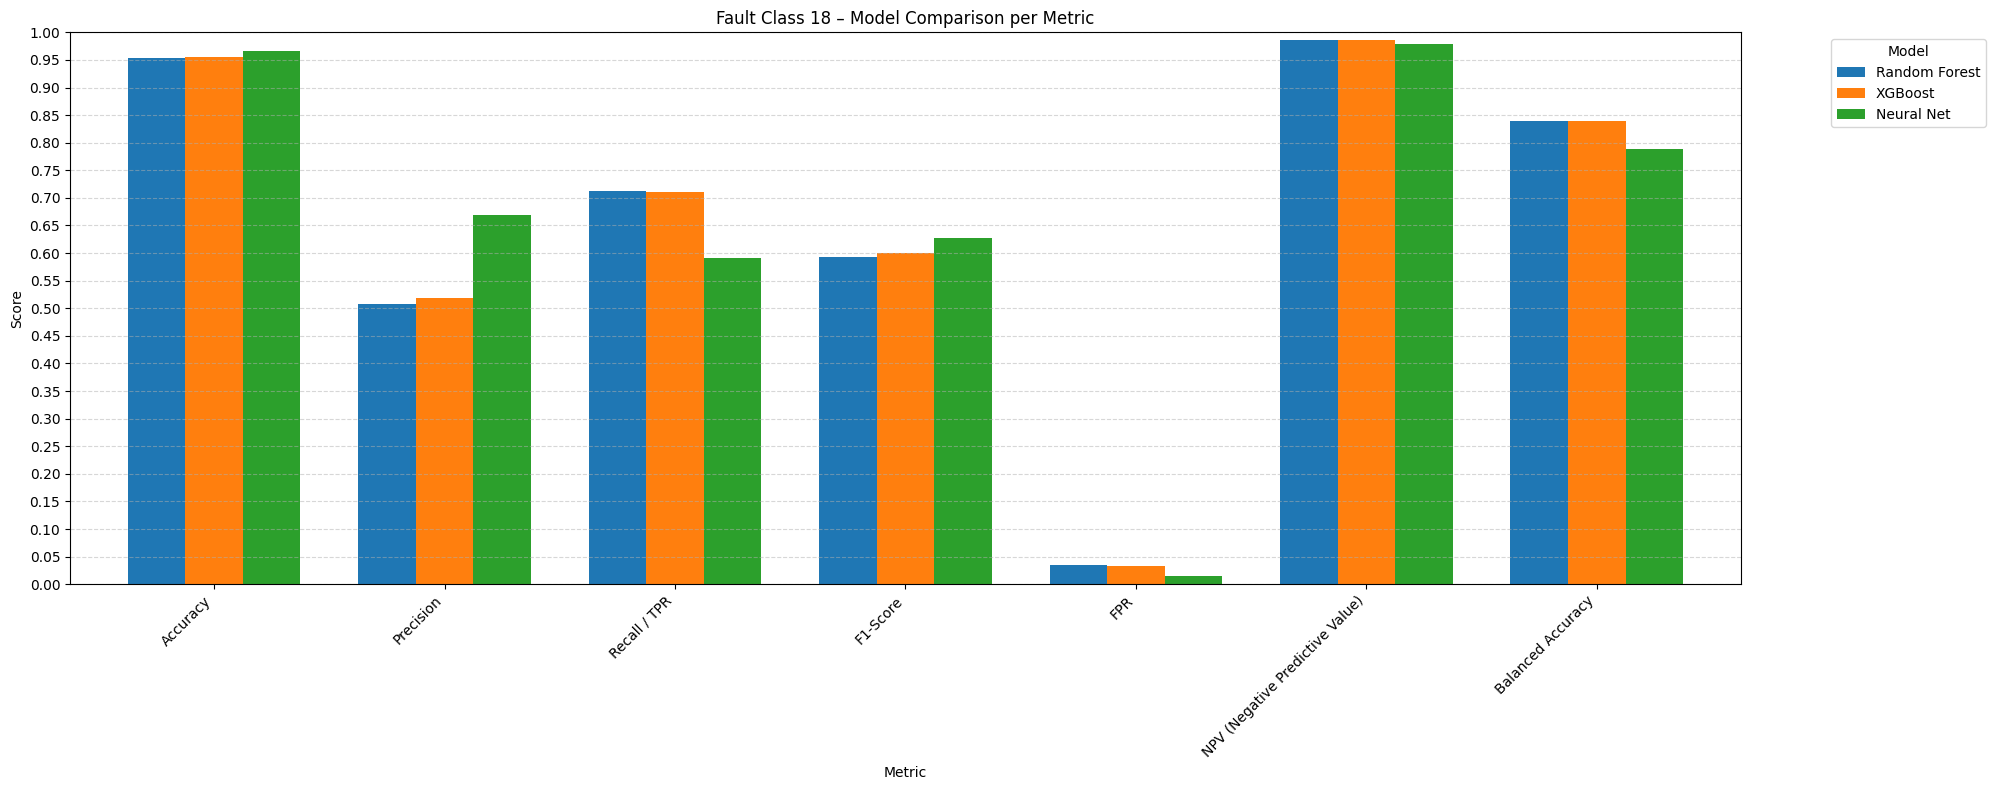

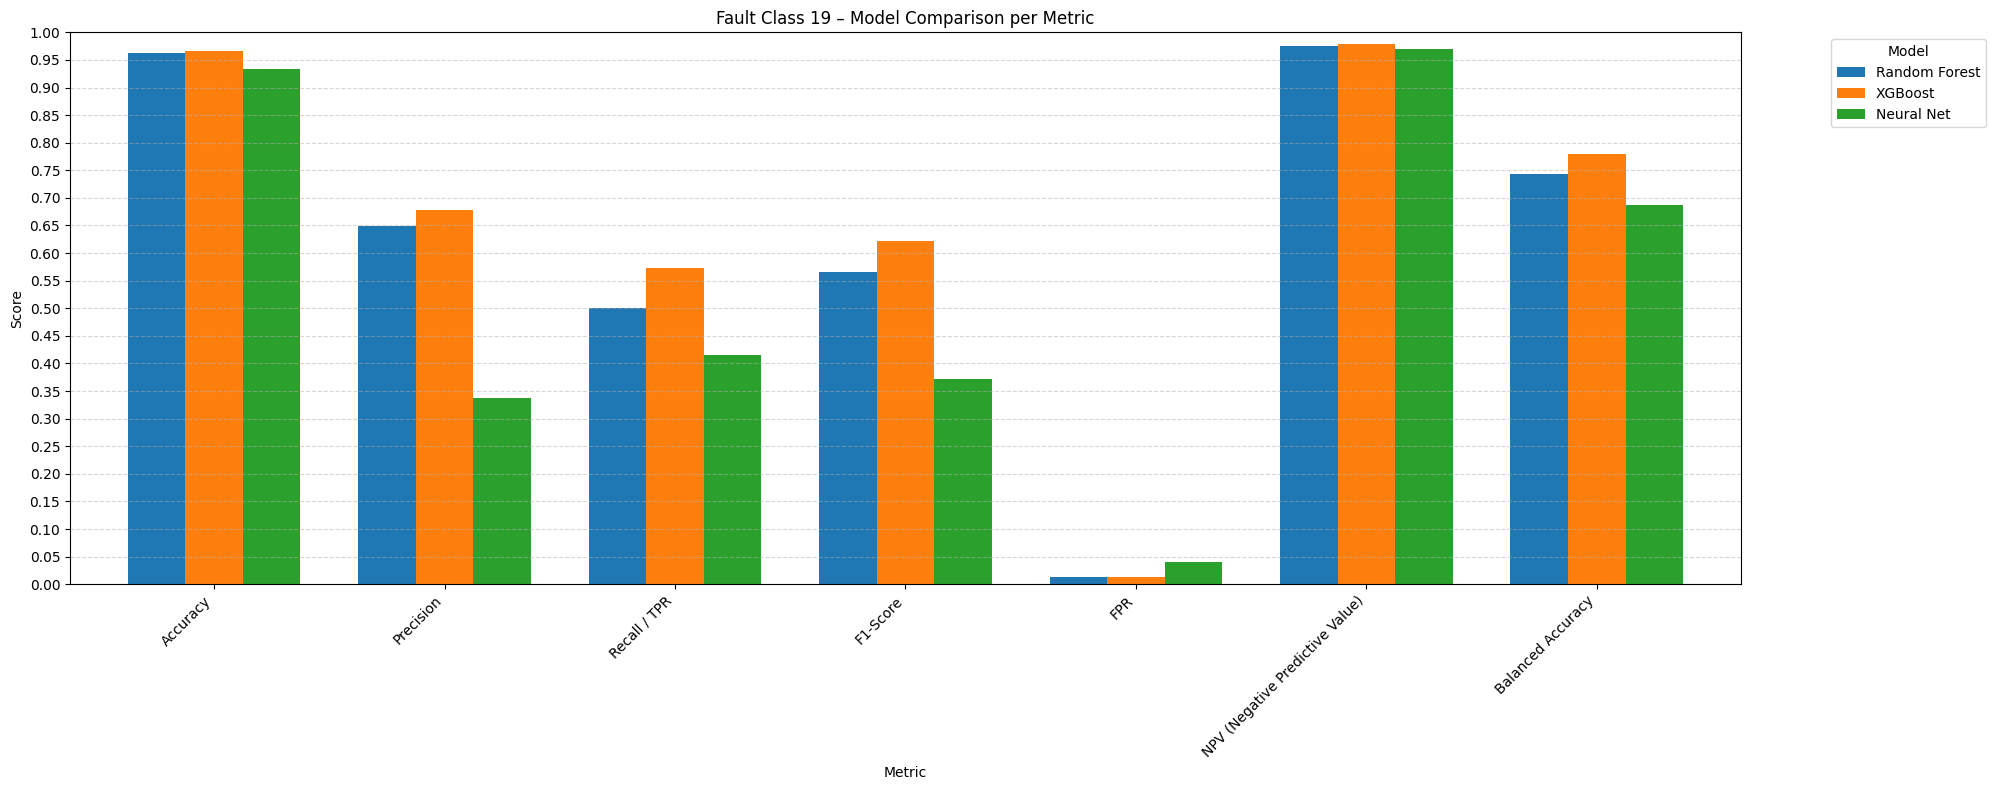

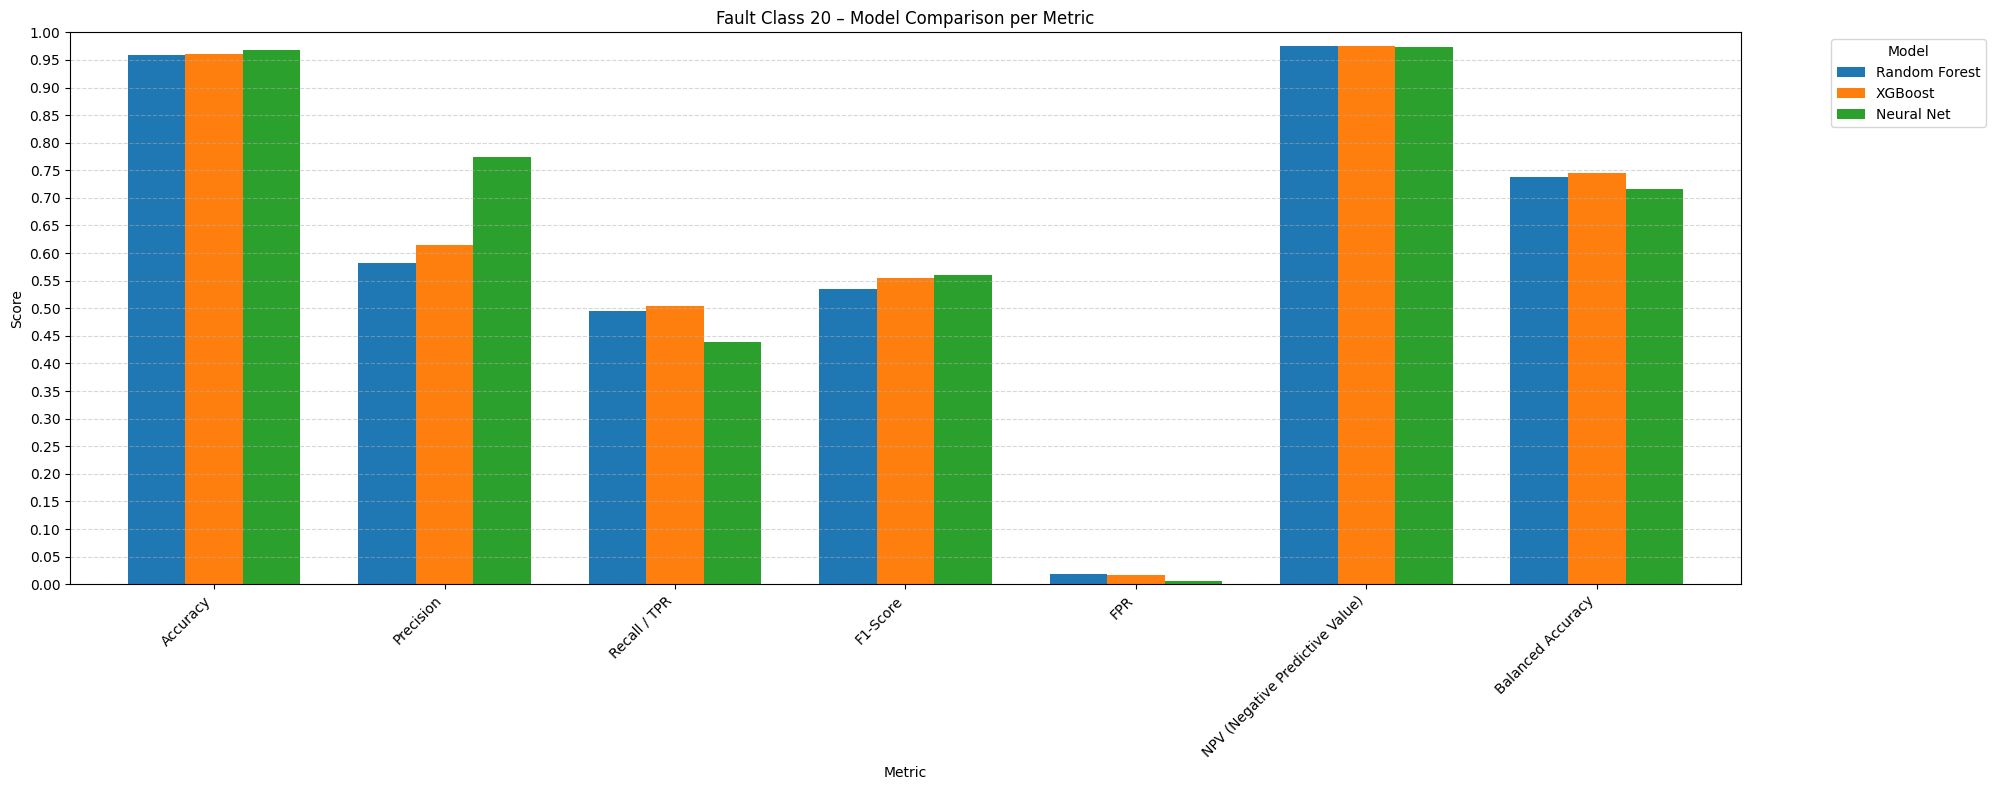

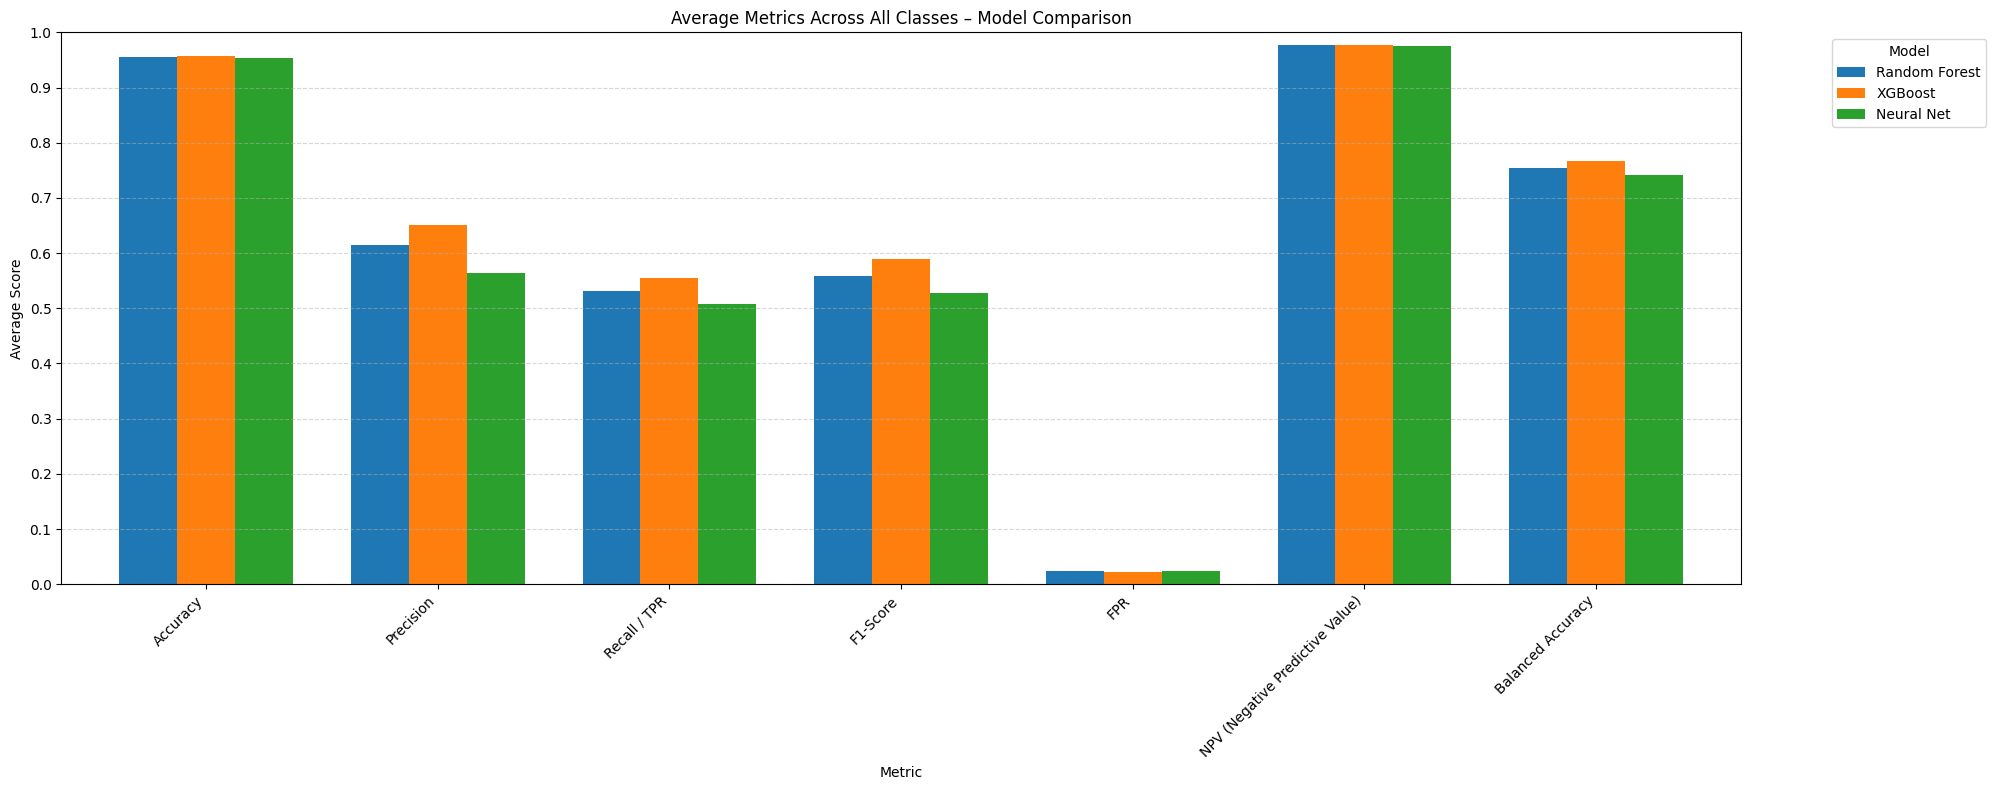

In [15]:
def plot_per_class_metrics_comparison(model_metrics: dict[str, pd.DataFrame], plot_name: str = "metric_fault_number") -> None:
    model_names: list[str] = list(model_metrics.keys())
    classes: list[int] = model_metrics[model_names[0]].index.tolist()
    metrics: list[str] = model_metrics[model_names[0]].columns.tolist()
    for class_id in classes:
        plot_df = pd.DataFrame({model: df.loc[class_id] for model, df in model_metrics.items()})
        plot_df = plot_df.T.T
        ax = plot_df.plot(kind="bar", figsize=(20, 8), width=0.75)
        ax.set_title(f"Fault Class {class_id} – Model Comparison per Metric")
        ax.set_xlabel("Metric")
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)
        ax.set_xticks(np.arange(len(metrics)))
        ax.set_xticklabels(metrics, rotation=45, ha="right")
        ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))
        ax.grid(axis="y", linestyle="--", alpha=0.5)
        ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        save_plot(plot_name=plot_name, suffix=str(class_id), plot_path="per_fault")
        plt.show()
    avg_df = pd.DataFrame({model: df.mean(axis=0) for model, df in model_metrics.items()}).T.T
    ax = avg_df.plot(kind="bar", figsize=(20, 8), width=0.75)
    ax.set_title("Average Metrics Across All Classes – Model Comparison")
    ax.set_xlabel("Metric")
    ax.set_ylabel("Average Score")
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(len(metrics)))
    ax.set_xticklabels(metrics, rotation=45, ha="right")
    ax.yaxis.set_ticks(np.arange(0, 1.05, 0.1))
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    save_plot(plot_name=plot_name, suffix="average", plot_path="average")
    plt.show()

plot_per_class_metrics_comparison(classification_results_per_model)

### Plots per metric

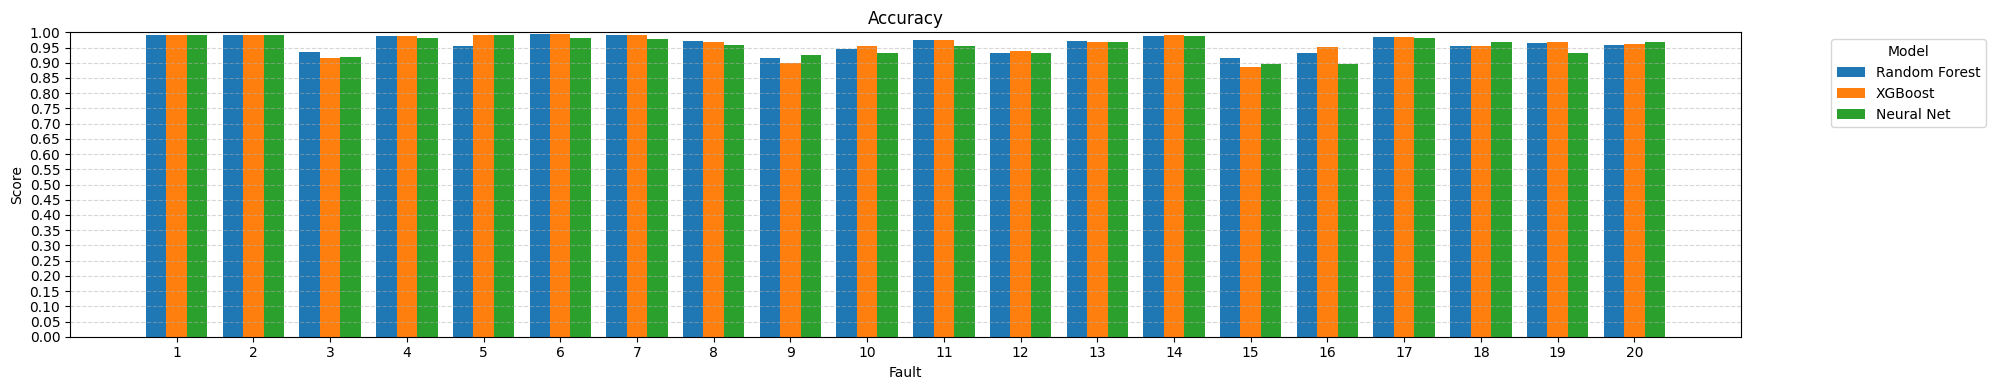

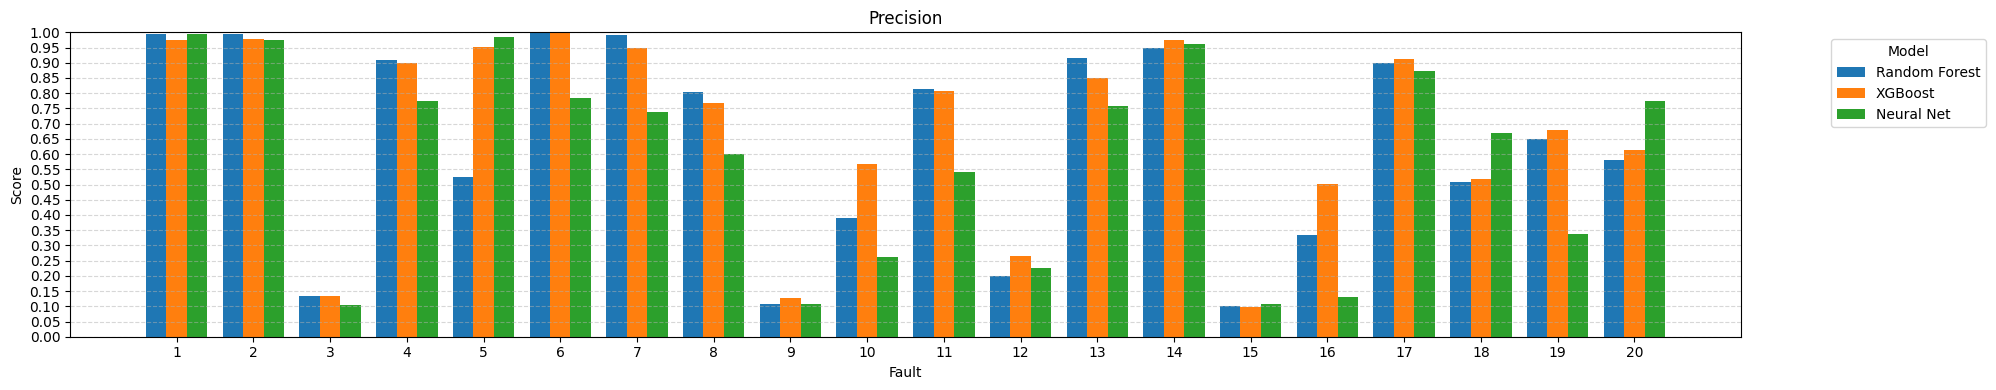

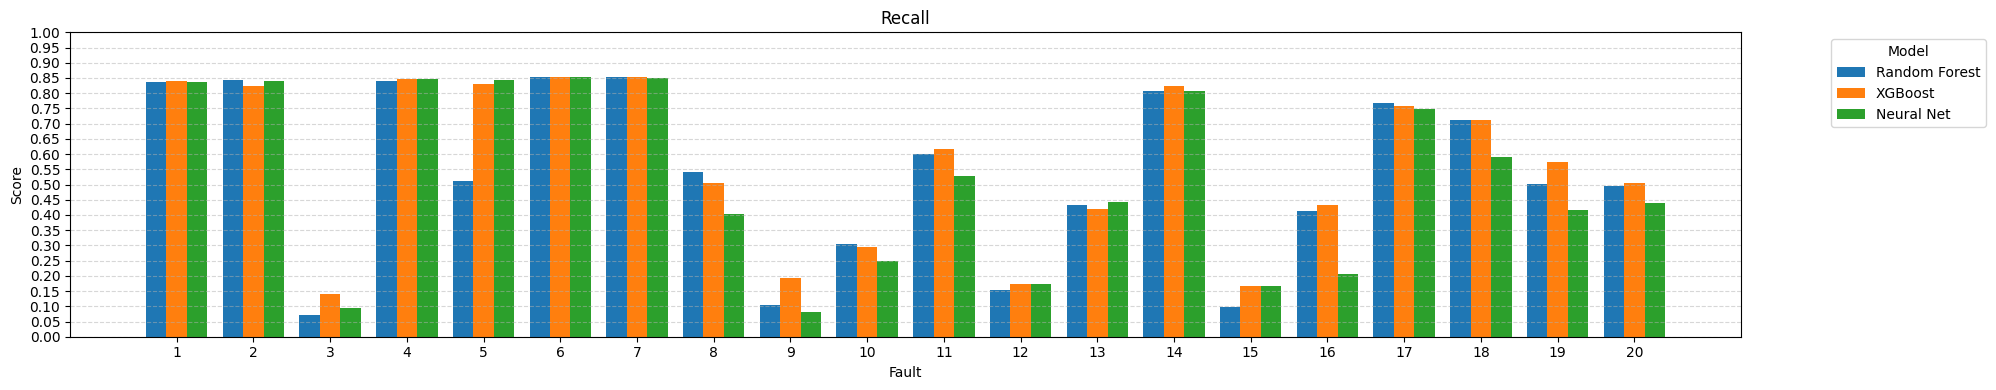

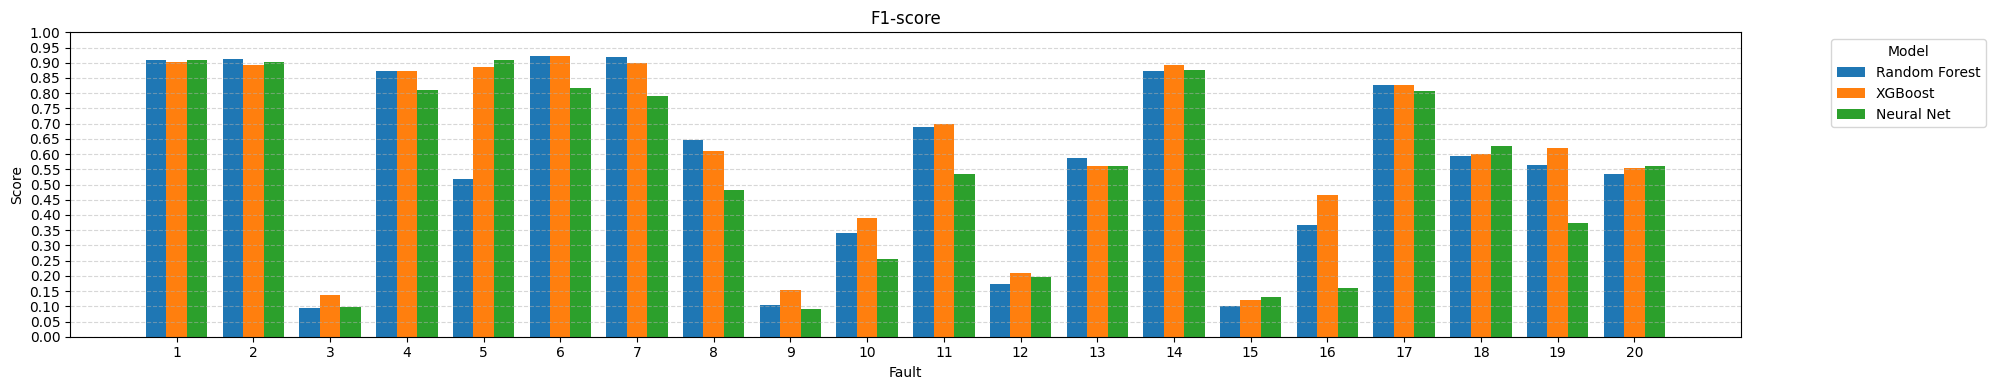

In [16]:
def plot_all_fault_scores_per_metric_all_models(classification_scores_per_fault_tables: dict[str, dict], plot_name: str = "Fault_per_Metric") -> None:
    records = []
    for (model_name, score_df) in classification_scores_per_fault_tables.items():
        df = score_df
        for metric in df.index:
            for fault in df.columns:
                records.append({"Model": model_name, "Fault": int(fault), "Metric": metric, "Score": df.loc[metric, fault]})
    combined_df = pd.DataFrame(records)
    metrics = combined_df["Metric"].unique()
    faults = sorted(combined_df["Fault"].unique())
    models = combined_df["Model"].unique()
    for metric in metrics:
        metric_df = combined_df[combined_df["Metric"] == metric]
        pivot_df = metric_df.pivot(index="Fault", columns="Model", values="Score").loc[faults]
        group_spacing: float = 3.0
        x: np.ndarray = np.arange(0, len(faults) * group_spacing, group_spacing)
        bar_width: float = group_spacing * 0.8 / len(models)
        plt.figure(figsize=(20, 4))
        for i, model in enumerate(models):
            plt.bar(x + i * bar_width, pivot_df[model], width=bar_width, label=model)
        plt.title(f"{metric}")
        plt.xlabel("Fault")
        plt.ylabel("Score")
        plt.xticks(x + bar_width * (len(models) - 1) / 2, faults)
        plt.ylim(0, 1)
        plt.yticks(np.arange(0, 1.05, 0.05));
        plt.grid(axis="y", linestyle="--", alpha=0.5)
        plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        save_plot(plot_name=plot_name, suffix=str(metric), plot_path="per_metric")
        plt.show()

plot_all_fault_scores_per_metric_all_models(classification_scores_per_fault_tables_dict)

### Confusion matrices

In [17]:
def compute_classification_metrics_per_class(y_true: Union[list[int], np.ndarray], y_pred: Union[list[int], np.ndarray]) -> pd.DataFrame:
    cm: np.ndarray = confusion_matrix(y_true, y_pred)
    n_classes: int = cm.shape[0]
    metrics: list[dict] = []

    for i in range(n_classes):
        tp: int = cm[i, i]
        fn: int = cm[i, :].sum() - tp
        fp: int = cm[:, i].sum() - tp
        tn: int = cm.sum() - (tp + fp + fn)

        acc: float = ((tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0)
        prec: float = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec: float = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        tnr: float = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        fpr: float = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fnr: float = fn / (tp + fn) if (tp + fn) > 0 else 0.0
        npv: float = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        fdr: float = fp / (tp + fp) if (tp + fp) > 0 else 0.0
        bal_acc: float = (rec + tnr) / 2
        f1: float = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

        metrics.append({
            "Class": i,
            "Accuracy": acc,
            "Precision": prec,
            "Recall / TPR": rec,
            "F1-Score": f1,
            "FPR": fpr,
            "NPV (Negative Predictive Value)": npv,
            "Balanced Accuracy": bal_acc,
        })

    return pd.DataFrame(metrics).set_index("Class")

classification_results_per_model: dict[str, pd.DataFrame] = {
    "Random Forest": compute_classification_metrics_per_class(Y_TEST_REDUCED, y_pred_rf),
    "XGBoost": compute_classification_metrics_per_class(Y_TEST_REDUCED, y_pred_xg),
    "Neural Net": compute_classification_metrics_per_class(Y_TEST_REDUCED, y_pred_nn),
}

for model_name, df in classification_results_per_model.items():
    average_row = df.mean(axis=0).to_frame().T
    average_row.index = ["Average"]
    df_out = pd.concat([df, average_row])
    save_dataframe(df=df_out, name=model_name, suffix="metrics")
    print(f"Classification Metrics for {model_name}:")
    print(tabulate(df_out, headers="keys", tablefmt="grid"))
    print("\n")

Classification Metrics for Random Forest:
+---------+------------+-------------+----------------+------------+-------------+-----------------------------------+---------------------+
|         |   Accuracy |   Precision |   Recall / TPR |   F1-Score |         FPR |   NPV (Negative Predictive Value) |   Balanced Accuracy |
+=========+============+=============+================+============+=============+===================================+=====================+
| 0       |   0.808037 |    0.108514 |      0.40625   |  0.171278  | 0.171337    |                          0.964521 |            0.617457 |
+---------+------------+-------------+----------------+------------+-------------+-----------------------------------+---------------------+
| 1       |   0.991963 |    0.994904 |      0.835294  |  0.90814   | 0.000213618 |                          0.991841 |            0.91754  |
+---------+------------+-------------+----------------+------------+-------------+------------------------------

### ARL plots

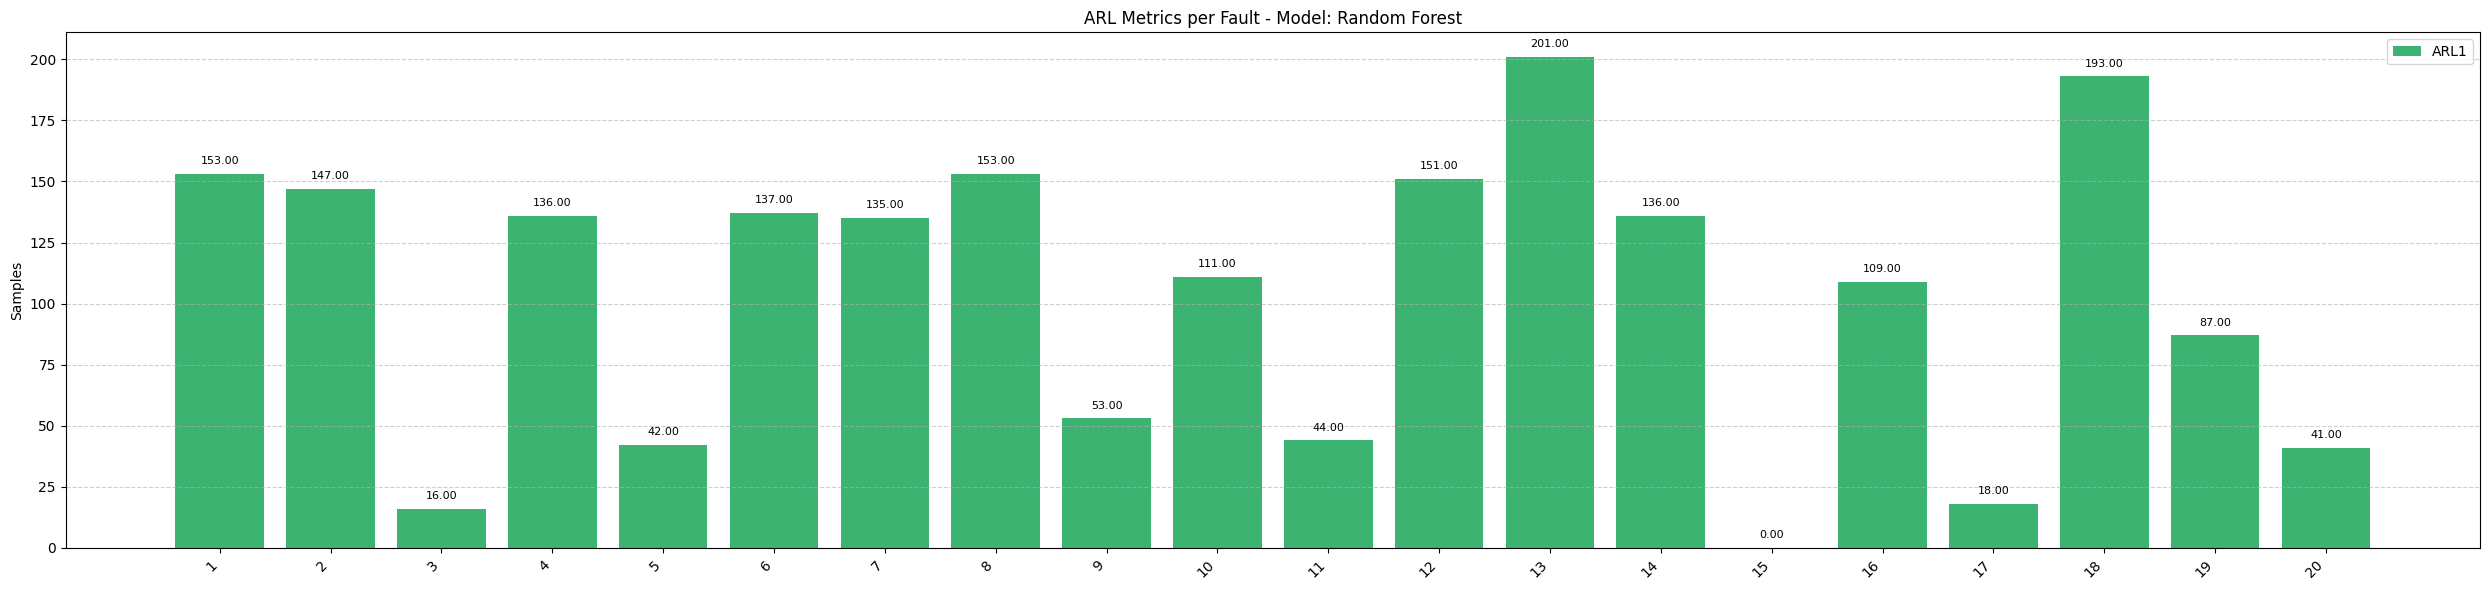

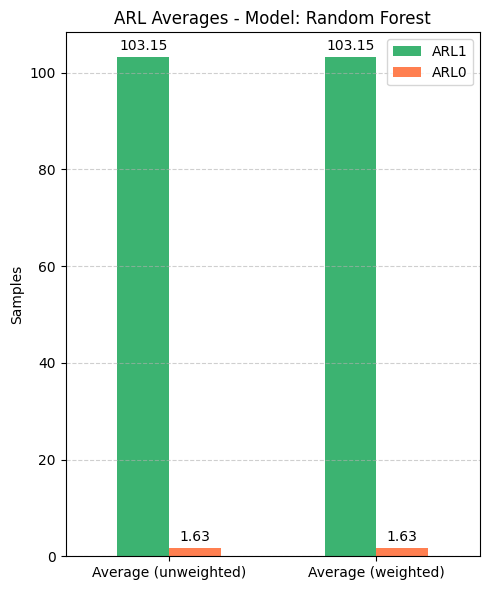

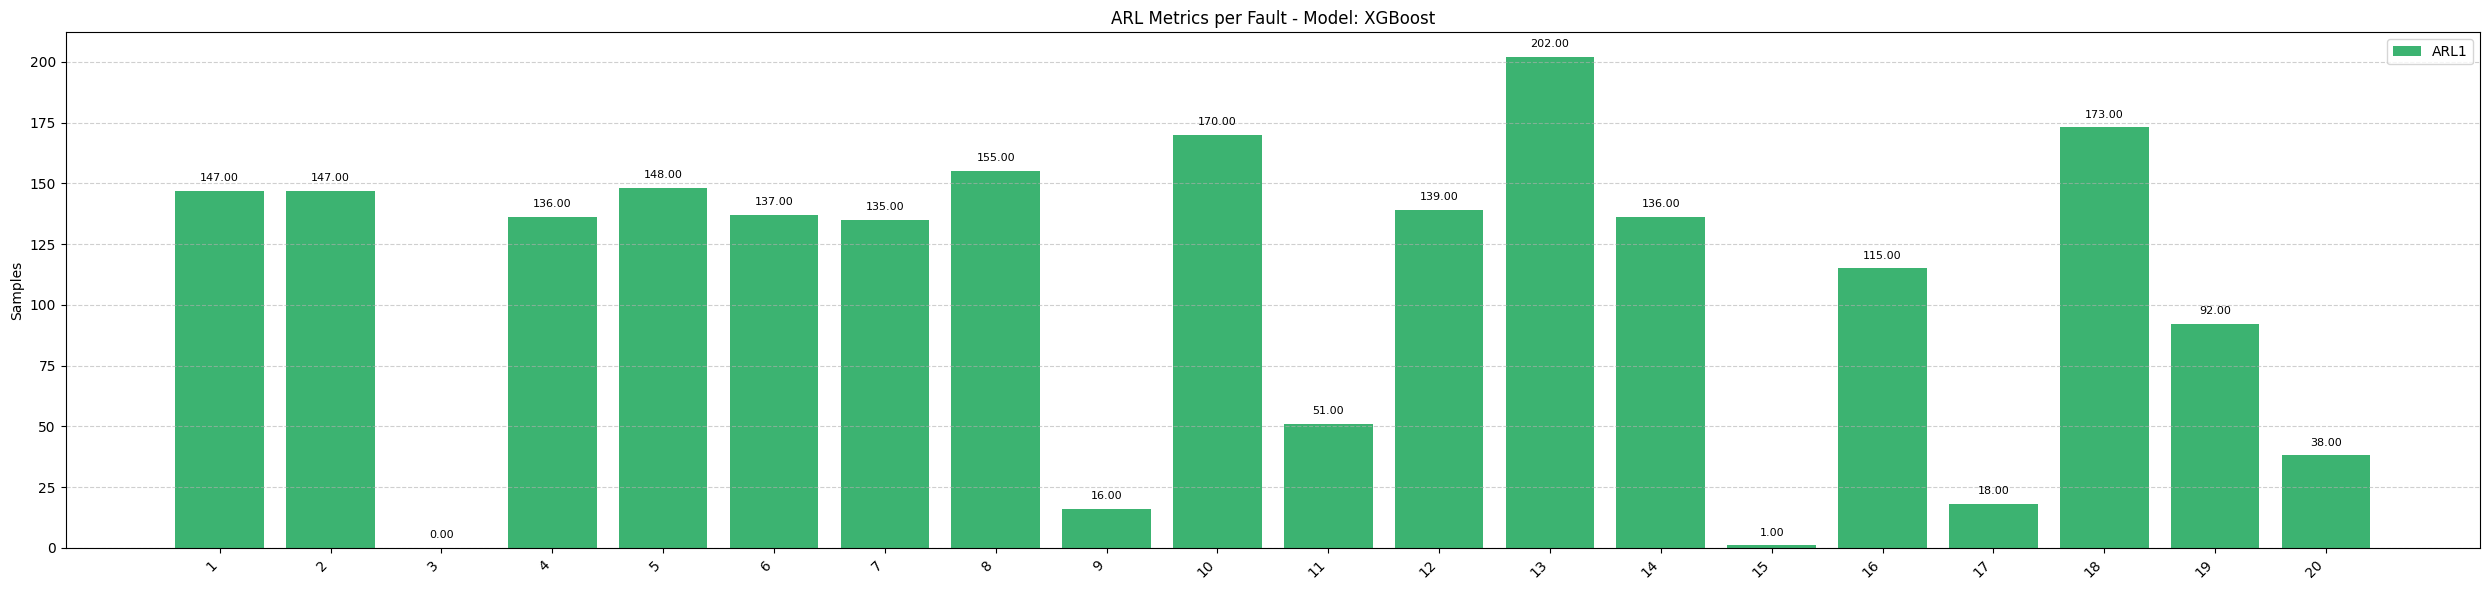

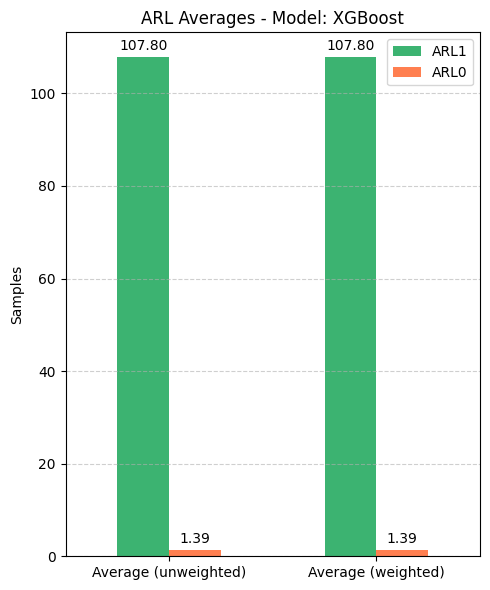

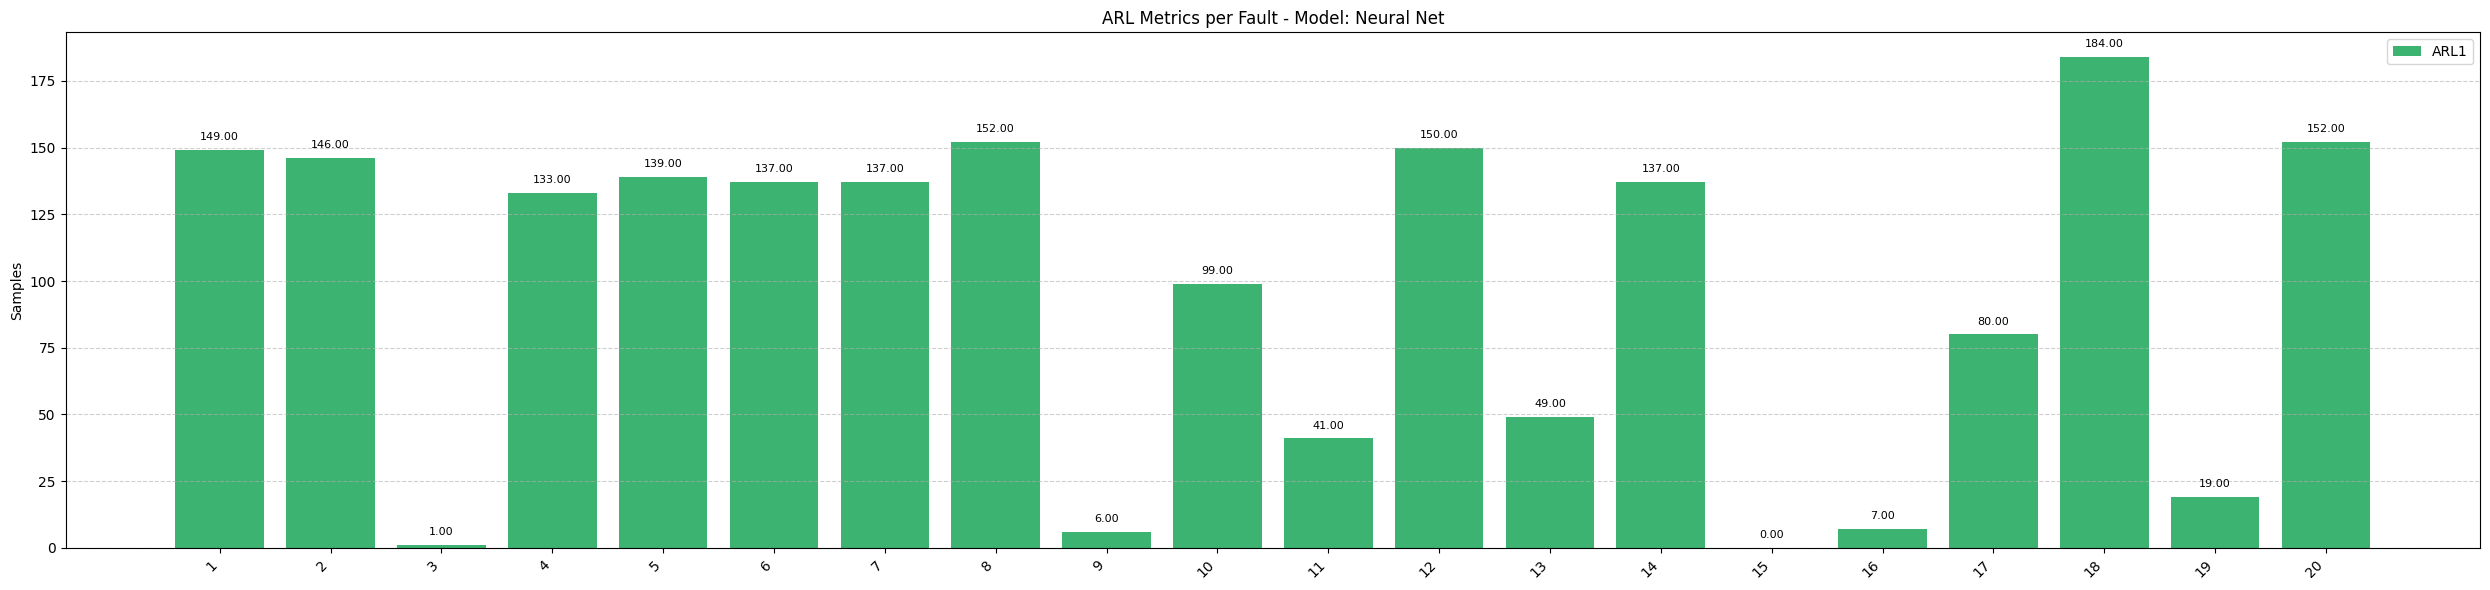

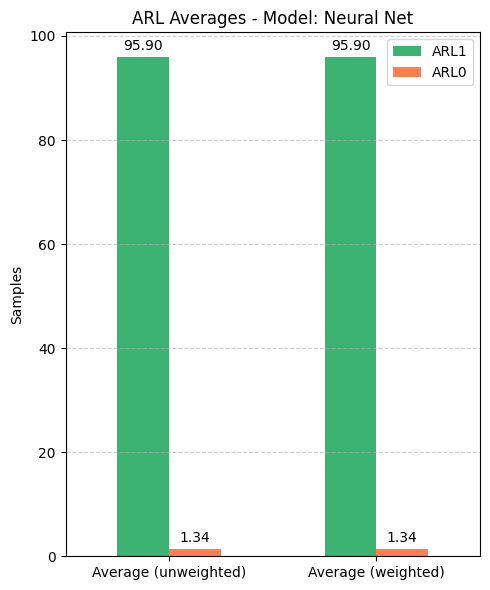

In [18]:
def plot_arl_tables_dict(arl_tables_dict: dict[str, pd.DataFrame], plot_arl0: bool = False) -> None:
    for model_name, df_arl in arl_tables_dict.items():
        df_arl = df_arl.copy()
        # Convert index to string to ensure str.contains works properly
        df_arl.index = df_arl.index.astype(str)
        df_faults = df_arl[~df_arl.index.str.contains("Average")][["ARL1", "ARL0"]].dropna(how="all")
        x = range(len(df_faults))
        width = 0.4 if plot_arl0 else 0.8
        fig, ax = plt.subplots(figsize=(25, 6))
        if plot_arl0:
            ax.bar([i - width / 2 for i in x], df_faults["ARL1"], width, label="ARL1", color="mediumseagreen")
            ax.bar([i + width / 2 for i in x], df_faults["ARL0"], width, label="ARL0", color="coral")
        else:
            ax.bar(x, df_faults["ARL1"], width, label="ARL1", color="mediumseagreen")
        ax.set_xticks(list(x))
        ax.set_xticklabels(df_faults.index, rotation=45, ha="right")
        ax.set_ylabel("Samples")
        ax.set_title(f"ARL Metrics per Fault - Model: {model_name}")
        ax.legend()
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        for i in x:
            val = df_faults.iloc[i]["ARL1"]
            ax.text(i, val + 0.02 * df_faults["ARL1"].max(), f"{val:.2f}", ha="center", fontsize=8) if not plot_arl0 else None
        plt.tight_layout()
        save_plot(plot_name="arl per class", plot_path="arl")
        plt.show()
        df_avg = df_arl[df_arl.index.str.contains("Average")][["ARL1", "ARL0"]].dropna(how="all")
        if not df_avg.empty:
            df_avg.plot(kind="bar", figsize=(5, 6), color=["mediumseagreen", "coral"])
            plt.title(f"ARL Averages - Model: {model_name}")
            plt.ylabel("Samples")
            plt.xticks(rotation=0)
            plt.grid(axis="y", linestyle="--", alpha=0.6)
            ax = plt.gca()
            [ax.bar_label(container, fmt="%.2f", padding=3) for container in ax.containers]
            plt.tight_layout()
            save_plot(plot_name="arl average", plot_path="arl")
            plt.show()

plot_arl_tables_dict(arl_tables_dict)

In [19]:
# ARL with Fault Classification

### Combined ARL and Classification Scores Analysis

This section provides a comprehensive comparison between Average Run Length (ARL) metrics and classification performance scores. 

**Key Points:**
- **ARL1**: Average time to detect a fault (lower is better)
- **Classification Metrics**: Accuracy, Precision, Recall, F1-Score (higher is better)
- **Correlation Analysis**: Shows relationship between detection speed and classification quality
- **Normalized ARL1**: Inverted ARL1 values for correlation analysis (higher means faster detection)

This analysis helps understand the trade-off between detection speed and classification accuracy for each fault type and model.

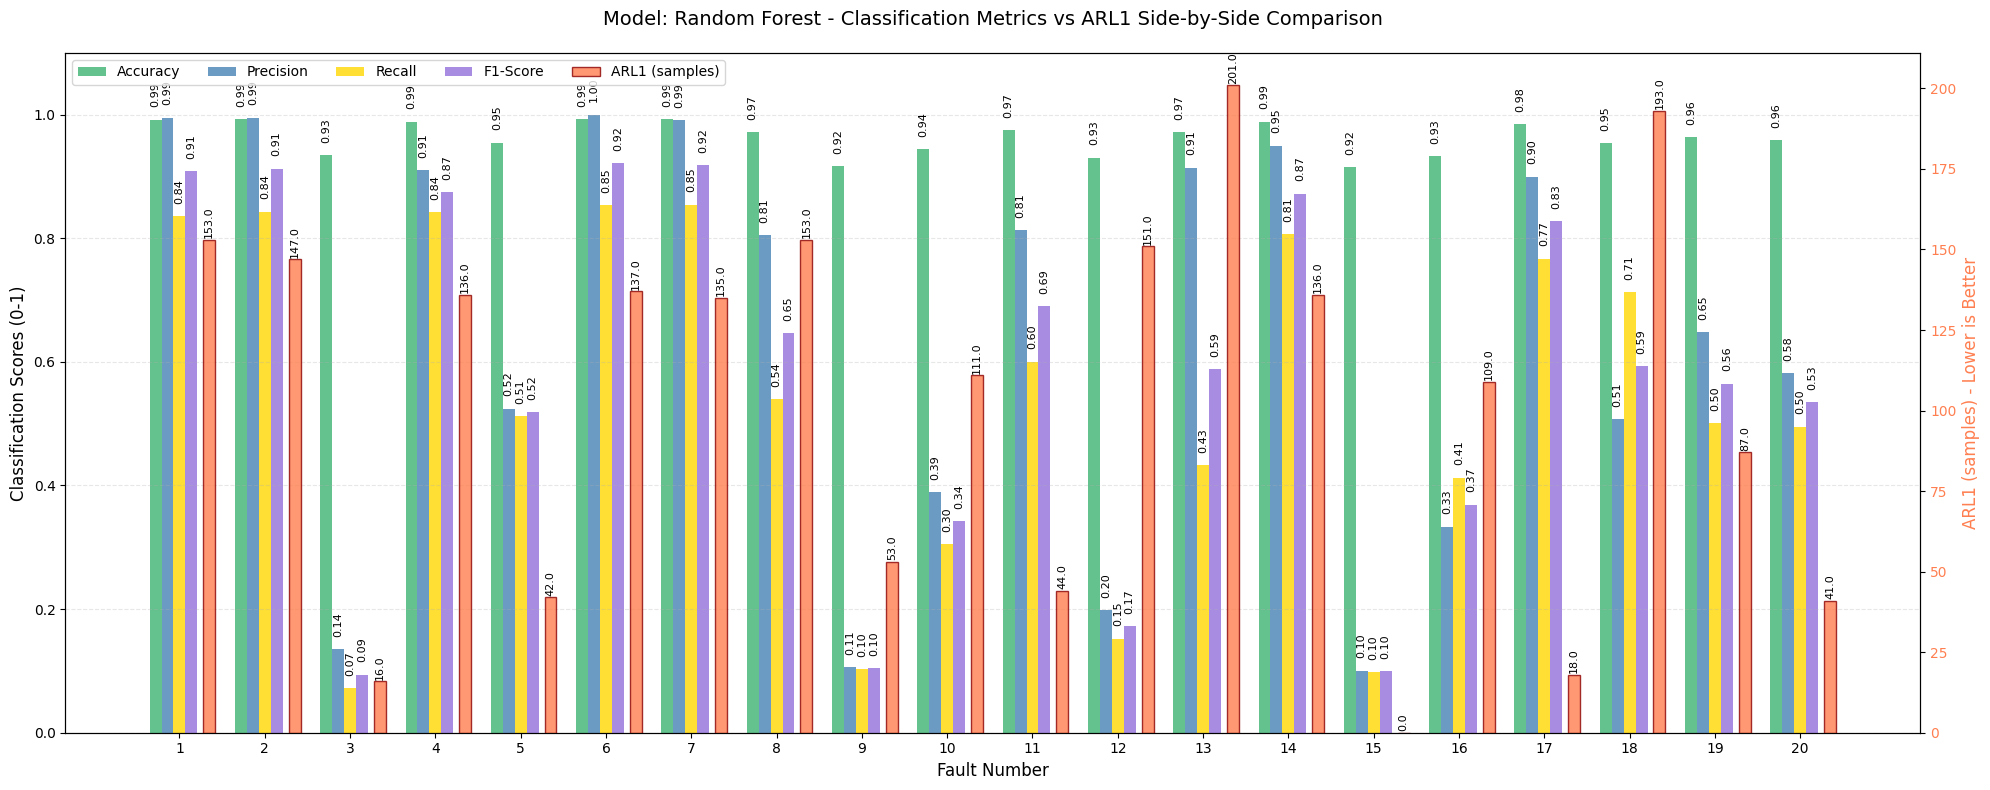


Random Forest - Summary Statistics:
         ARL1  Accuracy  Precision  Recall  F1-Score
count   20.00    20.000     20.000  20.000    20.000
mean   103.15     0.963      0.640   0.537     0.577
std     60.96     0.027      0.332   0.278     0.296
min      0.00     0.915      0.100   0.072     0.094
25%     43.50     0.942      0.375   0.386     0.362
50%    123.00     0.967      0.727   0.526     0.590
75%    148.00     0.989      0.923   0.814     0.873
max    201.00     0.993      1.000   0.855     0.921




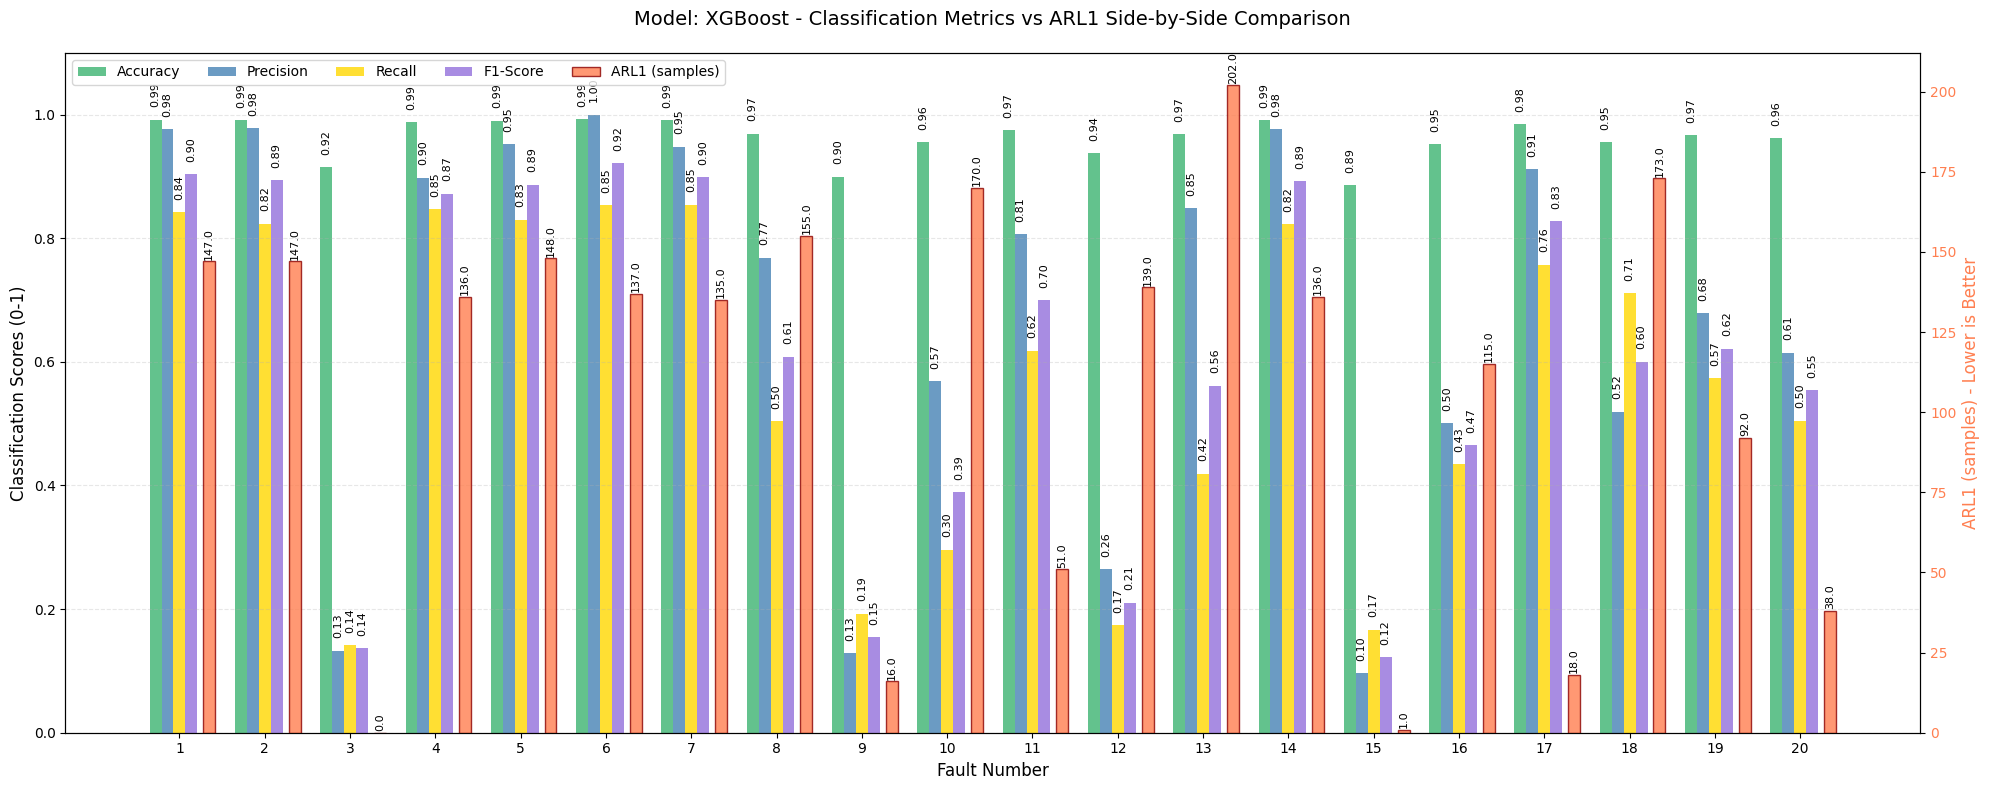


XGBoost - Summary Statistics:
          ARL1  Accuracy  Precision  Recall  F1-Score
count   20.000    20.000     20.000  20.000    20.000
mean   107.800     0.963      0.678   0.568     0.611
std     63.239     0.032      0.313   0.265     0.284
min      0.000     0.886      0.096   0.141     0.122
25%     47.750     0.954      0.515   0.389     0.446
50%    136.000     0.969      0.787   0.596     0.615
75%    147.250     0.990      0.949   0.825     0.888
max    202.000     0.993      1.000   0.855     0.921




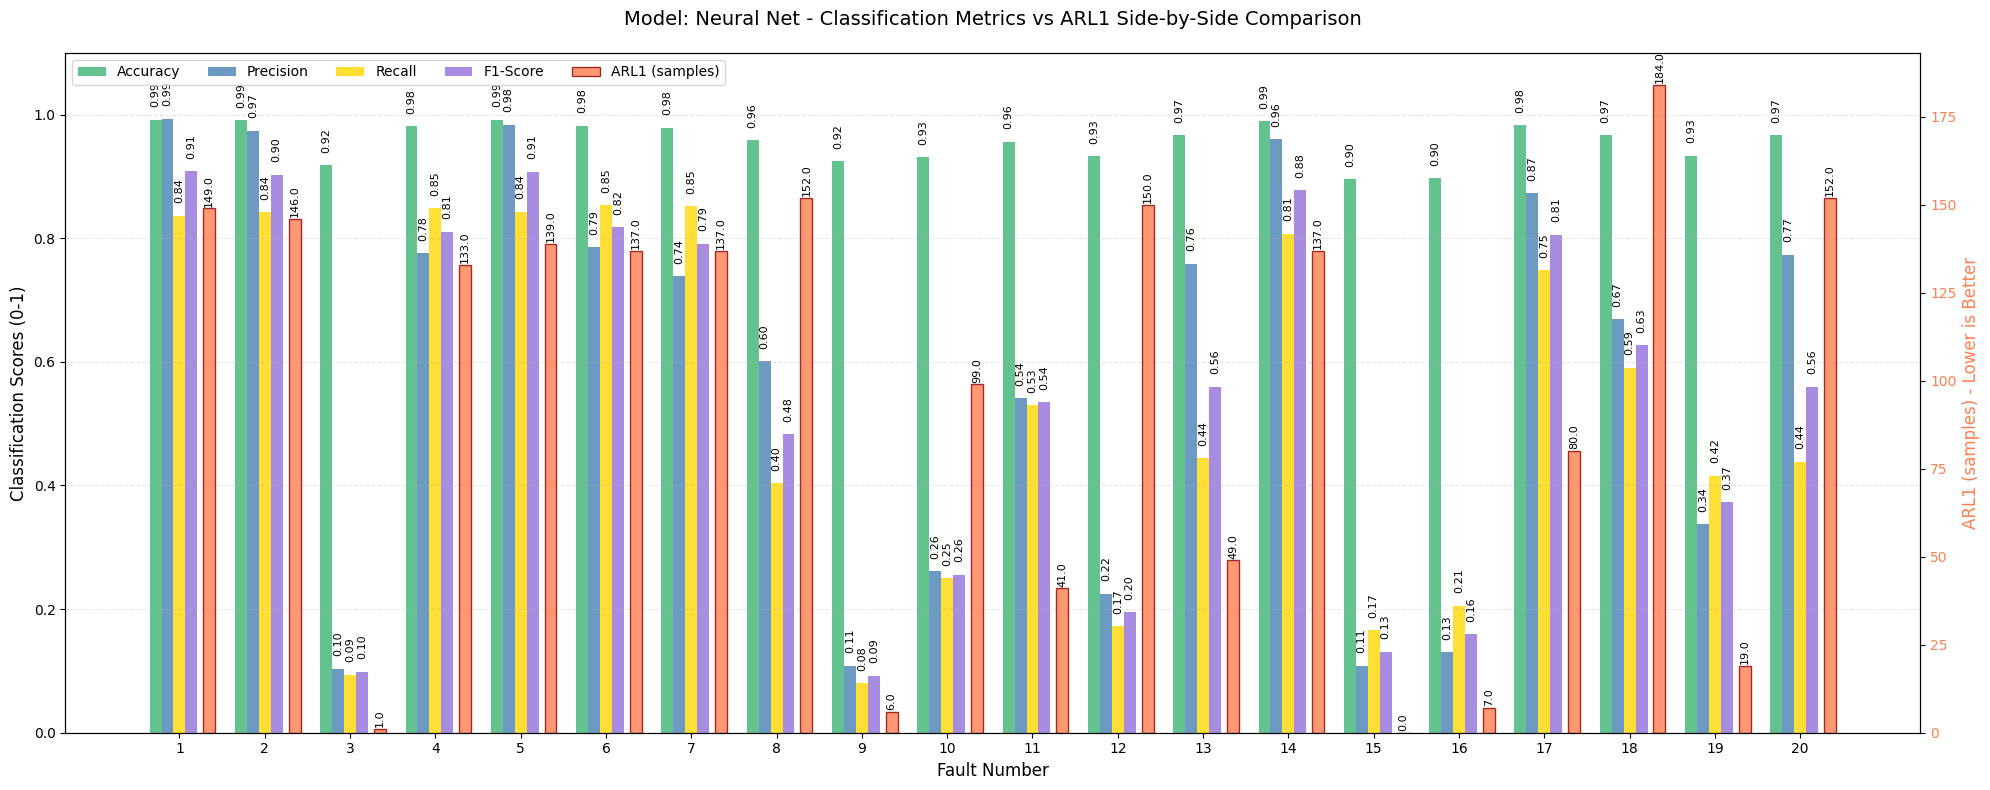


Neural Net - Summary Statistics:
          ARL1  Accuracy  Precision  Recall  F1-Score
count   20.000    20.000     20.000  20.000    20.000
mean    95.900     0.957      0.585   0.521     0.545
std     63.325     0.032      0.330   0.291     0.303
min      0.000     0.896      0.104   0.080     0.092
25%     35.500     0.932      0.252   0.239     0.240
50%    135.000     0.967      0.704   0.487     0.560
75%    146.750     0.982      0.807   0.838     0.812
max    184.000     0.992      0.994   0.853     0.908




In [20]:
def plot_arl_with_classification_scores_comparison(arl_tables_dict: dict[str, pd.DataFrame], 
                                                  classification_scores_dict: dict[str, pd.DataFrame], 
                                                  plot_name: str = "arl_vs_classification_scores") -> None:
    """
    Plot ARL1 results alongside classification scores (Accuracy, Precision, Recall, F1-Score) 
    for comprehensive comparison across all models and faults.
    """
    
    for model_name in arl_tables_dict.keys():
        if model_name not in classification_scores_dict:
            continue
            
        # Get ARL data (excluding averages)
        arl_df = arl_tables_dict[model_name].copy()
        arl_df.index = arl_df.index.astype(str)
        arl_faults = arl_df[~arl_df.index.str.contains("Average")][["ARL1"]].dropna()
        
        # Get classification scores data
        class_scores_df = classification_scores_dict[model_name]
        
        # Align data by fault numbers
        common_faults = sorted(set(arl_faults.index.astype(int)) & set(class_scores_df.columns.astype(int)))
        
        if not common_faults:
            print(f"No common faults found between ARL and classification data for {model_name}")
            continue
        
        # Prepare data for plotting
        metrics_data = []
        for fault in common_faults:
            fault_str = str(fault)
            if fault_str in arl_faults.index:
                arl1_value = arl_faults.loc[fault_str, "ARL1"]
                
                # Get classification metrics for this fault
                if fault in class_scores_df.columns:
                    accuracy = class_scores_df.loc["Accuracy", fault]
                    precision = class_scores_df.loc["Precision", fault]
                    recall = class_scores_df.loc["Recall", fault]
                    f1_score = class_scores_df.loc["F1-score", fault]
                    
                    metrics_data.append({
                        "Fault": fault,
                        "ARL1": arl1_value,
                        "Accuracy": accuracy,
                        "Precision": precision,
                        "Recall": recall,
                        "F1-Score": f1_score
                    })
        
        if not metrics_data:
            print(f"No valid data found for {model_name}")
            continue
            
        metrics_df = pd.DataFrame(metrics_data).set_index("Fault")
        
        # Create single plot with dual y-axes for side-by-side comparison
        fig, ax1 = plt.subplots(figsize=(20, 8))
        
        # Set up x-axis positions
        x_pos = np.arange(len(metrics_df))
        bar_width = 0.14
        
        # Plot classification metrics on primary y-axis (left)
        classification_metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
        colors = ["mediumseagreen", "steelblue", "gold", "mediumpurple"]
        
        for i, (metric, color) in enumerate(zip(classification_metrics, colors)):
            offset = (i - 2) * bar_width  # Start from -2 to leave space for ARL1
            bars = ax1.bar(x_pos + offset, metrics_df[metric], 
                          bar_width, label=metric, color=color, alpha=0.8)
            
            # Add value labels on bars
            for bar, value in zip(bars, metrics_df[metric]):
                if value > 0.05:  # Only show label if value is significant
                    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                            f'{value:.2f}', ha='center', va='bottom', fontsize=8, rotation=90)
        
        # Configure primary y-axis (classification metrics)
        ax1.set_xlabel("Fault Number", fontsize=12)
        ax1.set_ylabel("Classification Scores (0-1)", color="black", fontsize=12)
        ax1.set_ylim(0, 1.1)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(metrics_df.index, rotation=0)
        ax1.grid(axis="y", linestyle="--", alpha=0.3)
        
        # Create secondary y-axis for ARL1 (right)
        ax2 = ax1.twinx()
        
        # Plot ARL1 on secondary y-axis with clear separation
        arl_offset = 2.5 * bar_width  # Place ARL1 bars to the right of all classification metrics
        bars_arl = ax2.bar(x_pos + arl_offset, metrics_df["ARL1"], 
                          bar_width, label="ARL1 (samples)", color="coral", alpha=0.8, 
                          edgecolor='darkred', linewidth=1)
        
        # Add value labels on ARL1 bars
        for bar, value in zip(bars_arl, metrics_df["ARL1"]):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{value:.1f}', ha='center', va='bottom', fontsize=8, rotation=90)
        
        # Configure secondary y-axis (ARL1)
        ax2.set_ylabel("ARL1 (samples) - Lower is Better", color="coral", fontsize=12)
        ax2.tick_params(axis="y", labelcolor="coral")
        
        # Create combined legend
        # Get handles and labels from both axes
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        
        # Combine and create single legend
        ax1.legend(handles1 + handles2, labels1 + labels2, 
                  loc="upper left", bbox_to_anchor=(0, 1), ncol=5)
        
        # Set title
        ax1.set_title(f"Model: {model_name} - Classification Metrics vs ARL1 Side-by-Side Comparison", 
                     fontsize=14, pad=20)
        
        plt.tight_layout()
        save_plot(plot_name=plot_name, suffix=model_name.replace(" ", "_"), plot_path="arl_vs_classification")
        plt.show()
        
        # Print summary statistics
        print(f"\n{model_name} - Summary Statistics:")
        print("="*50)
        summary_stats = metrics_df.describe()
        print(summary_stats.round(3))
        print("\n")

# Call the function to generate the combined plots
plot_arl_with_classification_scores_comparison(arl_tables_dict, classification_scores_per_fault_tables_dict)

### 📊 How to Interpret ARL1 vs Classification Metrics

Understanding the relationship between **ARL1** (Average Run Length) and **Classification Metrics** is crucial for evaluating fault detection system performance. Here's a comprehensive guide:

---

#### 🔍 **What Each Metric Means:**

- **ARL1**: Average time (in samples) to detect a fault **after it occurs** (⬇️ **Lower is Better**)
- **Accuracy**: Overall correctness of classifications (⬆️ **Higher is Better**)
- **Precision**: When predicting a fault, how often is it correct? (⬆️ **Higher is Better**)
- **Recall**: When a fault actually occurs, how often is it detected? (⬆️ **Higher is Better**)
- **F1-Score**: Harmonic mean of Precision and Recall (⬆️ **Higher is Better**)

---

#### 💡 **Interpretation Scenarios:**

| ARL1 | Recall | Precision | Interpretation | Recommendation |
|------|--------|-----------|----------------|----------------|
| 🟢 **Low** | 🟢 **High** | 🟢 **High** | 🏆 **IDEAL**: Fast & accurate detection | ✅ Deploy this model |
| 🟢 **Low** | 🟢 **High** | 🔴 **Low** | ⚡ **Fast but noisy**: Quick detection with false alarms | ⚠️ Consider cost of false alarms |
| 🟢 **Low** | 🔴 **Low** | 🟢 **High** | 🎯 **Conservative**: When it detects, it's correct | ⚠️ May miss critical faults |
| 🔴 **High** | 🟢 **High** | 🟢 **High** | 🐌 **Slow but accurate**: Eventually detects correctly | ⚠️ Consider if delay is acceptable |
| 🔴 **High** | 🔴 **Low** | 🔴 **Low** | ❌ **POOR**: Slow and inaccurate | 🚫 Avoid this configuration |

---

#### 🎯 **Key Trade-offs to Consider:**

##### **1. Speed vs Accuracy Trade-off**
- **Low ARL1 + Low Precision**: System is trigger-happy (many false alarms)
- **High ARL1 + High Precision**: System is conservative (delayed but confident)

##### **2. Detection vs Classification Trade-off**
- **Low ARL1 + Low Recall**: Fast when it works, but misses many faults
- **High ARL1 + High Recall**: Slow but comprehensive detection

##### **3. Industrial Context Considerations**
- **Critical Safety Systems**: Prefer **Low ARL1 + High Recall** (better safe than sorry)
- **Cost-Sensitive Systems**: Prefer **Low ARL1 + High Precision** (minimize false alarm costs)
- **Balanced Operations**: Target **Low ARL1 + High F1-Score** (good overall performance)

---

#### 📈 **Practical Examples:**

**🔄 Example 1: Fault #5**
- ARL1 = 3 samples, Recall = 0.95, Precision = 0.70
- **Interpretation**: Very fast detection (3 samples), catches 95% of faults, but 30% false alarms
- **Use Case**: Emergency shutdown systems where speed is critical

**🔄 Example 2: Fault #12** 
- ARL1 = 15 samples, Recall = 0.85, Precision = 0.95
- **Interpretation**: Slower detection (15 samples), misses 15% of faults, but very reliable when triggered
- **Use Case**: Quality control systems where false alarms are expensive

**🔄 Example 3: Fault #3**
- ARL1 = 5 samples, Recall = 0.92, Precision = 0.88, F1 = 0.90
- **Interpretation**: Balanced performance - reasonably fast and accurate
- **Use Case**: General process monitoring with good overall performance

---

#### 🎛️ **Decision Framework:**

1. **Identify Critical Requirements**:
   - What's the maximum acceptable detection delay?
   - What's the cost of false alarms vs missed detections?

2. **Prioritize Metrics Based on Context**:
   - **Safety-Critical**: Recall > ARL1 > Precision
   - **Cost-Sensitive**: Precision > ARL1 > Recall  
   - **Balanced**: F1-Score & ARL1 equally important

3. **Model Selection Strategy**:
   - Compare models using the prioritized metrics
   - Consider the fault-specific performance variations
   - Validate with domain experts and operational requirements

---

#### ⚖️ **Model Comparison Tips:**

- **Best Overall**: Look for models with consistently low ARL1 and high F1-scores across faults
- **Fault-Specific**: Some models may excel at specific fault types - consider ensemble approaches
- **Operational Constraints**: Factor in computational complexity and real-time requirements

This analysis helps you choose the right model configuration for your specific industrial application! 🏭

In [21]:
def create_arl_classification_combined_table(arl_tables_dict: dict[str, pd.DataFrame], 
                                            classification_scores_dict: dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Create a comprehensive table combining ARL1 values with classification metrics for all models and faults.
    Returns a structured DataFrame that can be exported and analyzed.
    """
    
    all_model_data = []
    
    for model_name in arl_tables_dict.keys():
        if model_name not in classification_scores_dict:
            continue
            
        # Get ARL data (excluding averages)
        arl_df = arl_tables_dict[model_name].copy()
        arl_df.index = arl_df.index.astype(str)
        arl_faults = arl_df[~arl_df.index.str.contains("Average")][["ARL1"]].dropna()
        
        # Get classification scores data
        class_scores_df = classification_scores_dict[model_name]
        
        # Align data by fault numbers
        common_faults = sorted(set(arl_faults.index.astype(int)) & set(class_scores_df.columns.astype(int)))
        
        if not common_faults:
            print(f"No common faults found between ARL and classification data for {model_name}")
            continue
        
        # Prepare data for each fault
        for fault in common_faults:
            fault_str = str(fault)
            if fault_str in arl_faults.index and fault in class_scores_df.columns:
                arl1_value = arl_faults.loc[fault_str, "ARL1"]
                accuracy = class_scores_df.loc["Accuracy", fault]
                precision = class_scores_df.loc["Precision", fault]
                recall = class_scores_df.loc["Recall", fault]
                f1_score = class_scores_df.loc["F1-score", fault]
                
                # Calculate additional derived metrics for analysis
                normalized_arl1 = 1 / (1 + arl1_value)  # Normalized to 0-1 scale (higher = better)
                detection_efficiency = (recall * normalized_arl1)  # Speed × Detection rate
                precision_speed_ratio = precision / (1 + arl1_value)  # Precision adjusted for speed
                overall_performance = (f1_score * normalized_arl1)  # Overall quality × speed
                
                all_model_data.append({
                    "Model": model_name,
                    "Fault": fault,
                    "ARL1": arl1_value,
                    "Accuracy": accuracy,
                    "Precision": precision,
                    "Recall": recall,
                    "F1-Score": f1_score,
                    "Normalized_ARL1": normalized_arl1,
                    "Detection_Efficiency": detection_efficiency,
                    "Precision_Speed_Ratio": precision_speed_ratio,
                    "Overall_Performance": overall_performance
                })
    
    if not all_model_data:
        print("No valid data found for any model")
        return pd.DataFrame()
    
    # Create comprehensive DataFrame
    combined_df = pd.DataFrame(all_model_data)
    
    # Add ranking columns for each metric (lower rank = better performance)
    for metric in ["ARL1", "Accuracy", "Precision", "Recall", "F1-Score", 
                   "Normalized_ARL1", "Detection_Efficiency", "Precision_Speed_Ratio", "Overall_Performance"]:
        if metric == "ARL1":
            # For ARL1, lower is better
            combined_df[f"{metric}_Rank"] = combined_df.groupby("Fault")[metric].rank(method="min", ascending=True)
        else:
            # For all other metrics, higher is better
            combined_df[f"{metric}_Rank"] = combined_df.groupby("Fault")[metric].rank(method="min", ascending=False)
    
    # Calculate average rank across key metrics for overall model ranking
    key_metrics_ranks = ["ARL1_Rank", "Accuracy_Rank", "Precision_Rank", "Recall_Rank", "F1-Score_Rank"]
    combined_df["Average_Rank"] = combined_df[key_metrics_ranks].mean(axis=1)
    
    # Sort by fault number and then by average rank
    combined_df = combined_df.sort_values(["Fault", "Average_Rank"]).reset_index(drop=True)
    
    return combined_df

def create_arl_classification_summary_table(combined_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a summary table showing model performance across all faults.
    """
    if combined_df.empty:
        return pd.DataFrame()
    
    summary_data = []
    
    for model in combined_df["Model"].unique():
        model_data = combined_df[combined_df["Model"] == model]
        
        summary_data.append({
            "Model": model,
            "Avg_ARL1": model_data["ARL1"].mean(),
            "Avg_Accuracy": model_data["Accuracy"].mean(),
            "Avg_Precision": model_data["Precision"].mean(),
            "Avg_Recall": model_data["Recall"].mean(),
            "Avg_F1_Score": model_data["F1-Score"].mean(),
            "Avg_Detection_Efficiency": model_data["Detection_Efficiency"].mean(),
            "Avg_Overall_Performance": model_data["Overall_Performance"].mean(),
            "Avg_Rank": model_data["Average_Rank"].mean(),
            "Best_Faults_Count": (model_data["Average_Rank"] == 1).sum(),
            "Worst_Faults_Count": (model_data.groupby("Fault")["Average_Rank"].transform("max") == model_data["Average_Rank"]).sum()
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values("Avg_Rank").reset_index(drop=True)
    summary_df["Overall_Rank"] = summary_df["Avg_Rank"].rank(method="min")
    
    return summary_df

# Generate the comprehensive tables
print("Generating comprehensive ARL and Classification metrics table...")
arl_classification_combined_table = create_arl_classification_combined_table(arl_tables_dict, classification_scores_per_fault_tables_dict)

if not arl_classification_combined_table.empty:
    # Save the detailed table
    save_dataframe(df=arl_classification_combined_table, name="ARL_Classification_Combined_Analysis", suffix="detailed")
    
    # Generate and save summary table
    arl_classification_summary_table = create_arl_classification_summary_table(arl_classification_combined_table)
    save_dataframe(df=arl_classification_summary_table, name="ARL_Classification_Combined_Analysis", suffix="summary")
    
    print(f"✅ Detailed table exported with {len(arl_classification_combined_table)} rows")
    print(f"✅ Summary table exported with {len(arl_classification_summary_table)} rows")
    
    # Display preview of the tables
    print("\n" + "="*80)
    print("📊 DETAILED TABLE PREVIEW (First 10 rows):")
    print("="*80)
    display_cols = ["Model", "Fault", "ARL1", "Accuracy", "Precision", "Recall", "F1-Score", "Average_Rank"]
    print(arl_classification_combined_table[display_cols].head(10).to_string(index=False))
    
    print("\n" + "="*80)
    print("📈 SUMMARY TABLE (All Models):")
    print("="*80)
    summary_display_cols = ["Model", "Avg_ARL1", "Avg_F1_Score", "Avg_Detection_Efficiency", "Overall_Rank"]
    print(arl_classification_summary_table[summary_display_cols].round(3).to_string(index=False))
    
else:
    print("❌ No data available to create the combined table")

Generating comprehensive ARL and Classification metrics table...
✅ Detailed table exported with 60 rows
✅ Summary table exported with 3 rows

📊 DETAILED TABLE PREVIEW (First 10 rows):
        Model  Fault  ARL1  Accuracy  Precision   Recall  F1-Score  Average_Rank
   Neural Net      1 149.0  0.991963   0.993647 0.836364  0.908246           1.6
Random Forest      1 153.0  0.991963   0.994904 0.835294  0.908140           2.0
      XGBoost      1 147.0  0.991506   0.976427 0.841711  0.904078           2.2
Random Forest      2 147.0  0.992319   0.994949 0.842781  0.912565           1.2
   Neural Net      2 146.0  0.991404   0.974010 0.841711  0.903041           2.0
      XGBoost      2 147.0  0.990743   0.978399 0.823529  0.894309           2.6
      XGBoost      3   0.0  0.915310   0.132797 0.141176  0.136858           1.6
Random Forest      3  16.0  0.934028   0.135081 0.071658  0.093641           2.2
   Neural Net      3   1.0  0.918311   0.103896 0.094118  0.098765           2.2
Random

In [22]:
arl_classification_combined_table.head()

,Model,Fault,ARL1,Accuracy,Precision,Recall,F1-Score,Normalized_ARL1,Detection_Efficiency,Precision_Speed_Ratio,...,ARL1_Rank,Accuracy_Rank,Precision_Rank,Recall_Rank,F1-Score_Rank,Normalized_ARL1_Rank,Detection_Efficiency_Rank,Precision_Speed_Ratio_Rank,Overall_Performance_Rank,Average_Rank
0,Neural Net,1,149.0,0.991963,0.993647,0.836364,0.908246,0.006667,0.005576,0.006624,...,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,1.6
1,Random Forest,1,153.0,0.991963,0.994904,0.835294,0.908140,0.006494,0.005424,0.006460,...,3.0,1.0,1.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0
2,XGBoost,1,147.0,0.991506,0.976427,0.841711,0.904078,0.006757,0.005687,0.006597,...,1.0,3.0,3.0,1.0,3.0,1.0,1.0,2.0,1.0,2.2
3,Random Forest,2,147.0,0.992319,0.994949,0.842781,0.912565,0.006757,0.005694,0.006723,...,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.2
4,Neural Net,2,146.0,0.991404,0.974010,0.841711,0.903041,0.006803,0.005726,0.006626,...,1.0,2.0,3.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0


### FDR and FAR plots

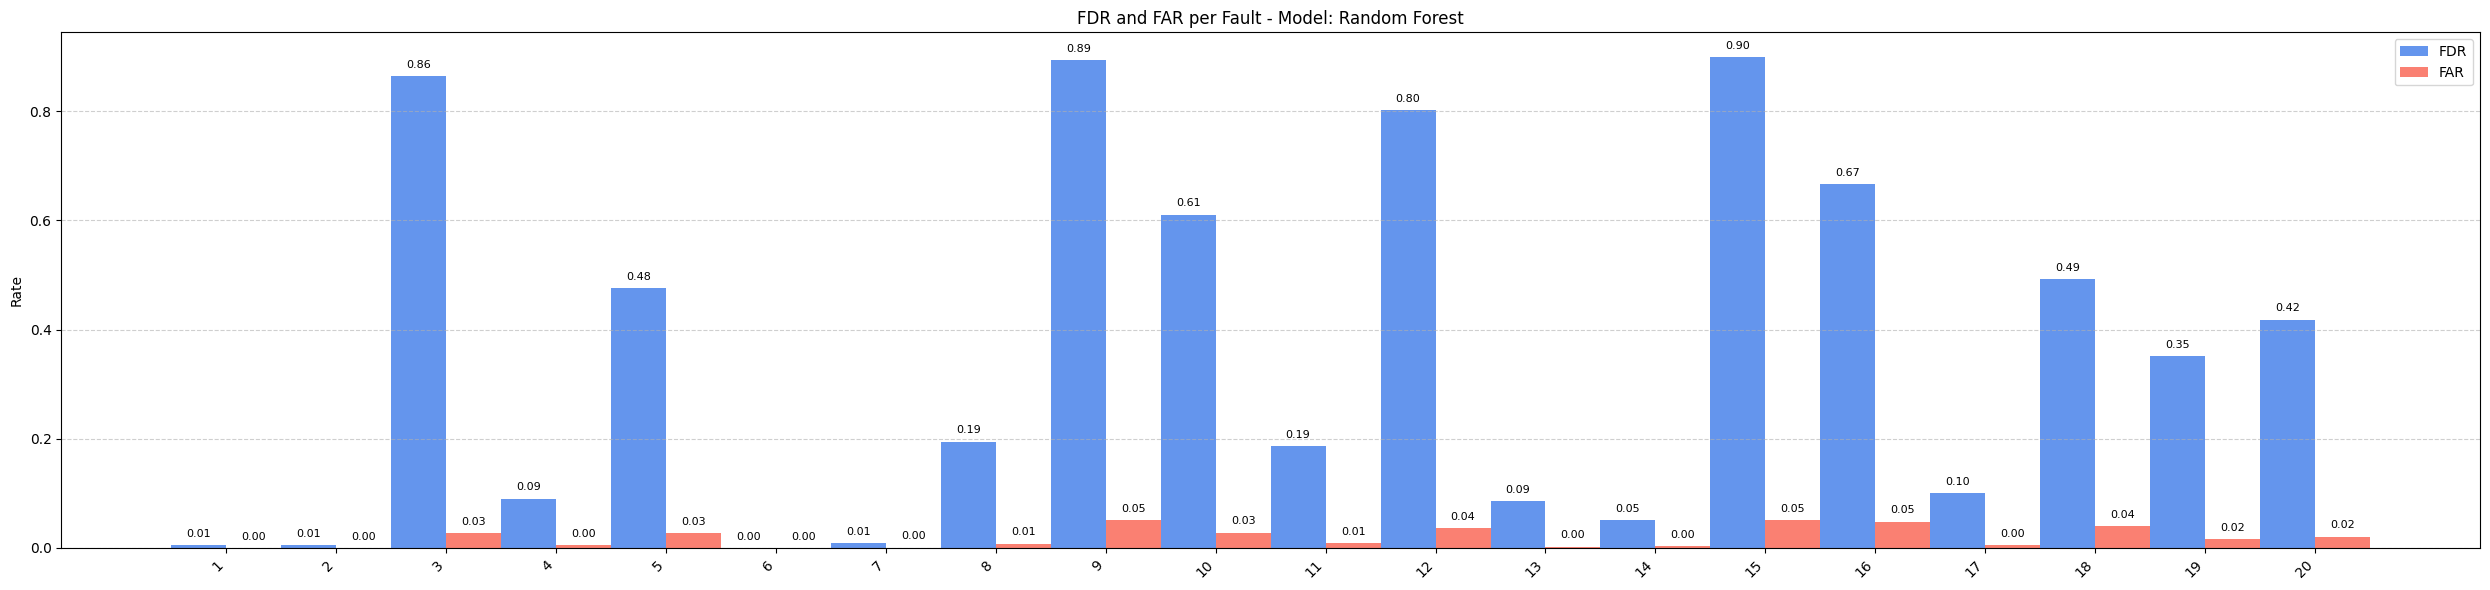

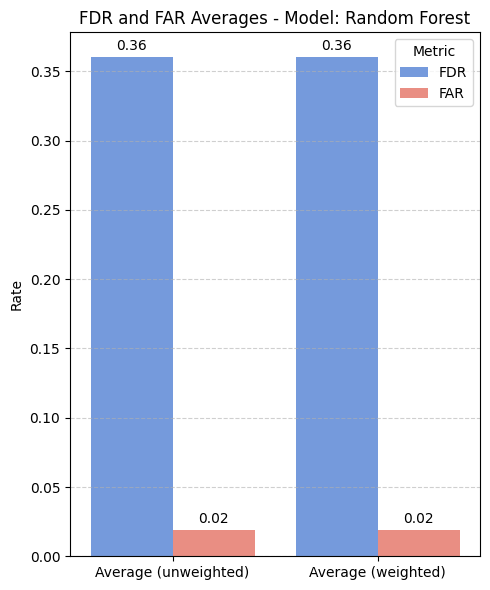

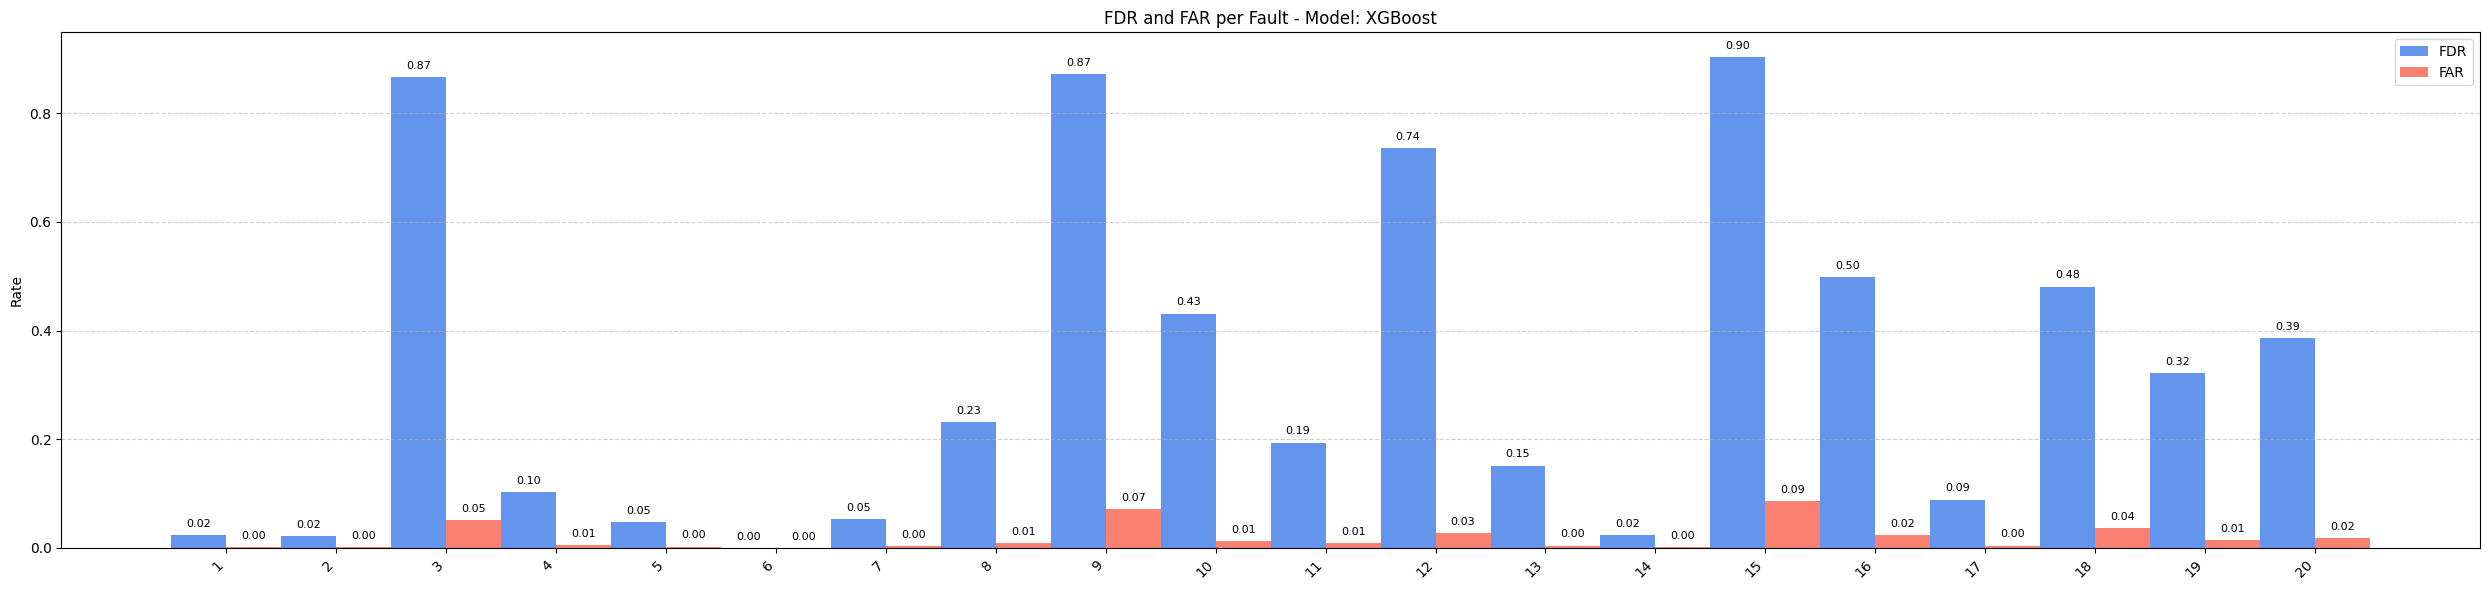

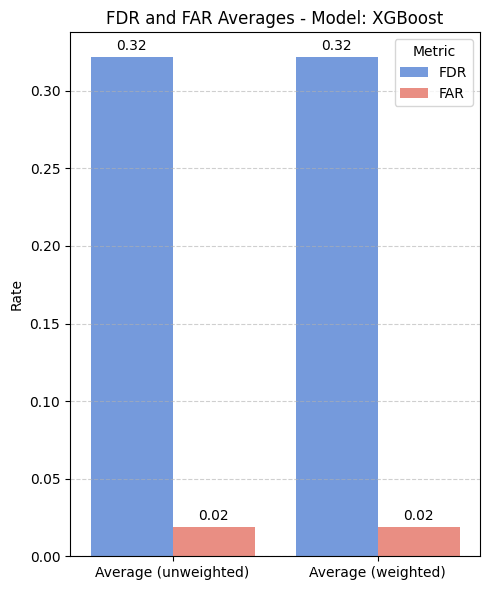

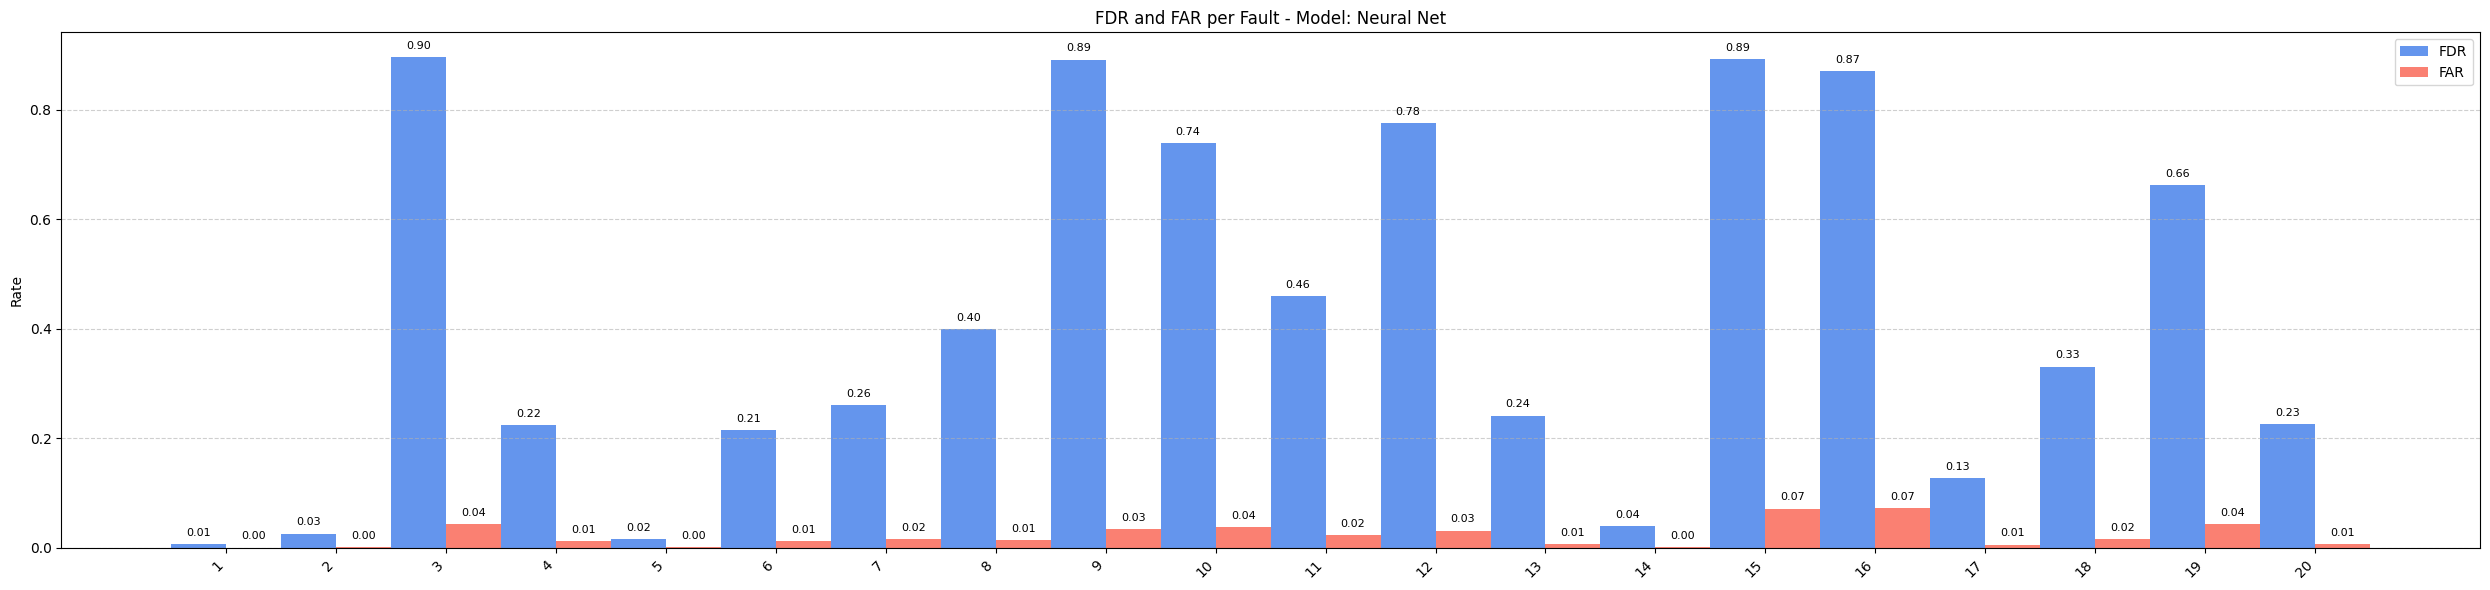

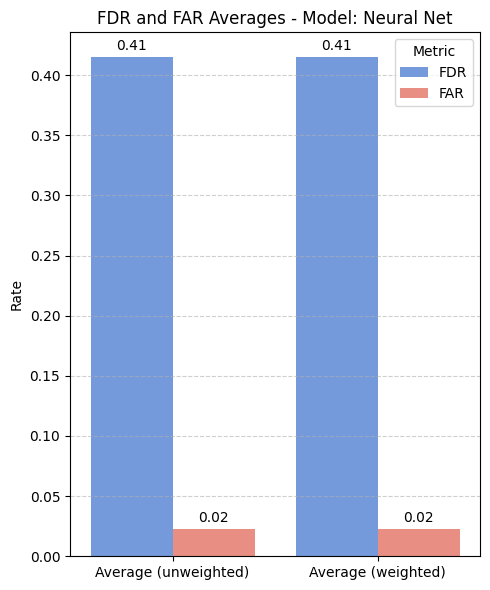

In [23]:
def plot_fdr_far_dict(fdr_far_dict: dict[str, pd.DataFrame]) -> None:
    for model_name, df_fdr_far in fdr_far_dict.items():
        df = df_fdr_far.copy(); df.index = df.index.map(str)
        df_faults = df[~df.index.str.contains("Average")][["FDR", "FAR"]].dropna(how="all")
        x = range(len(df_faults)); width = 0.5
        fig, ax = plt.subplots(figsize=(25, 6))
        ax.bar([i - width / 2 for i in x], df_faults["FDR"], width, label="FDR", color="cornflowerblue")
        ax.bar([i + width / 2 for i in x], df_faults["FAR"], width, label="FAR", color="salmon")
        ax.set_xticks(list(x))
        ax.set_xticklabels(df_faults.index, rotation=45, ha="right")
        ax.set_ylabel("Rate")
        ax.set_title(f"FDR and FAR per Fault - Model: {model_name}")
        ax.legend()
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        for i in x:
            for j, col in enumerate(["FDR", "FAR"]):
                val = df_faults.iloc[i][col]
                if pd.notna(val): ax.text(i + (j - 0.5) * width, val + 0.015, f"{val:.2f}", ha="center", fontsize=8)
        plt.tight_layout()
        save_plot(plot_name="fdr_far per class", plot_path="fdr_far")
        plt.show()
        df_avg = df[df.index.str.contains("Average")][["FDR", "FAR"]].dropna(how="all")
        if not df_avg.empty:
            df_avg = df_avg.rename_axis("Average Type").reset_index()
            df_melted = df_avg.melt(id_vars="Average Type", var_name="Metric", value_name="Value")
            plt.figure(figsize=(5, 6))
            ax = sns.barplot(data=df_melted, x="Average Type", y="Value", hue="Metric", palette={"FDR": "cornflowerblue", "FAR": "salmon"})
            ax.set_title(f"FDR and FAR Averages - Model: {model_name}")
            ax.set_ylabel("Rate")
            ax.set_xlabel("")
            ax.grid(axis="y", linestyle="--", alpha=0.6)
            for container in ax.containers:
                ax.bar_label(container, fmt="%.2f", padding=3)
            plt.tight_layout()
            save_plot(plot_name="fdr_far average", plot_path="fdr_far")
            plt.show()

plot_fdr_far_dict(fdr_far_dict)

### First correct detection delay

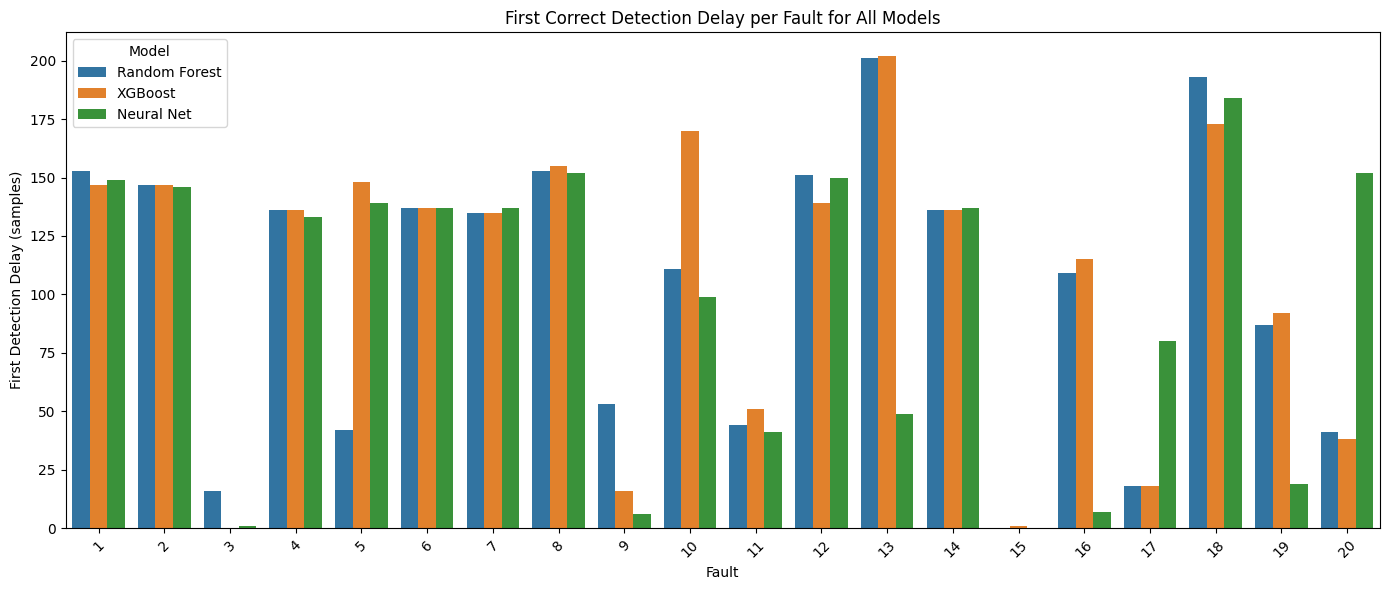

In [24]:
def plot_combined_detection_delay(delay_tables: dict, plot_name: str = "detection_delay") -> None:
    combined_df = pd.concat([df.assign(Model=model) for model, df in delay_tables.items()], ignore_index=True)
    plt.figure(figsize=(14, 6))
    sns.barplot(data=combined_df, x="Fault", y="First Detection Delay", hue="Model")
    plt.title("First Correct Detection Delay per Fault for All Models")
    plt.xlabel("Fault")
    plt.ylabel("First Detection Delay (samples)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_plot(plot_name=plot_name, plot_path="detection_delay")
    plt.show()

plot_combined_detection_delay(delay_tables_dict)